# Data import

In [3]:
import pandas

In [3]:
id = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/27/27id.dta')

In [4]:
relatives = []
for variable in id.columns:
    if 'WB' in variable and 'WB9_5' not in variable and 'WB9_1' not in variable and 'WB9_2' not in variable and 'WB9_3' not in variable and 'WB9_4' not in variable:
        if '9' in variable:
            relatives.append(variable)
        else:
            pass
    else:
        pass

# Who has children in household?

In [5]:
def child_func(df):
    generic = []
    for column in relatives:
        if 'Ñûí/äî÷ü' == df[column]:
            if column[3] == '_':
                ad_surv = column[:3]+ '_1'
            else:
                ad_surv = column[:4]+ '_1'
            if df[ad_surv] == 'Åñòü èíäèâèäóàëüíûé âîïðîñíèê':
                generic.append(1)
            else:
                generic.append(0)
        else:
            generic.append(0)
    if 1 in generic:
        return 1
    else:
        return 0

In [6]:
children = id.apply(child_func, axis = 1)

# Who are the parents?

In [7]:
network = []
for n in range(18237):
    new_list = []
    if children[n] == 1:
        for variable in relatives:
            if id[variable][n] == 'Ñûí/äî÷ü':
                new_list.append(variable)
            else:
                pass
    else:
        pass
    network.append(new_list)          

In [8]:
pandas.set_option("display.max_columns", 201)

In [9]:
numbered_network = []
for family in network:
    household = []
    for member in family:
        if member[3] == '_':
            if member[-2] == '_':
                numbered = [member[2],member[-1]]
            else:
                numbered = [member[2],member[-2] + member[-1]]
        else:
            if member[-2] == '_':
                numbered = [member[2] + member[3],member[-1]]
            else:
                numbered = [member[2] + member[3],member[-2] + member[-1]]
        household.append(numbered)
    numbered_network.append(household)

# Household re-indexing

In [10]:
household_list = []
n = 1
old = id['WREDID_H'][0]
for household in id['WREDID_H']:
    if old == household:
        household_list.append(n)
    else:
        n = n + 1
        household_list.append(n)
    old = household

# Who is a child?

In [11]:
child = []
for person in range(18237):
    you_r_child = []
    if children[person] == 1:
        for member in range(len(numbered_network[person])):
            if id.wh4[person] == int(numbered_network[person][member][0]):
                you_r_child.append(1)
            else:
                you_r_child.append(0)
    else:
        pass
    if 1 in you_r_child:
        child.append(1)
    else:
        child.append(0)

In [12]:
id['child'] = pandas.DataFrame(child)

# Sample limiting (who is a child)

In [74]:
import matplotlib.pyplot as plt

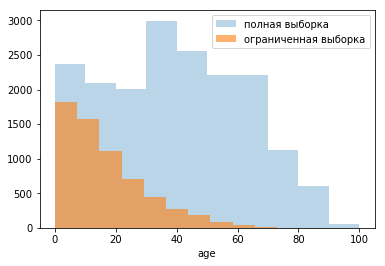

In [38]:
hist_full = plt.hist(id['w_age'], alpha = 0.3)
hist = plt.hist(id[id['child'] == 1]['w_age'], alpha = 0.6)
plt.xlabel('age')
plt.legend(['полная выборка', 'ограниченная выборка'])
plt.show()

# Sample limiting (who is a child with smoking status)

In [15]:
child_smoking_status = []
for person in range(18237):
    if pandas.isnull(id.wm71[person]) == False and id.child[person] == 1:
        child_smoking_status.append(1)
    else:
        child_smoking_status.append(0)

In [16]:
id['child_smoking_status'] = pandas.DataFrame(child_smoking_status)

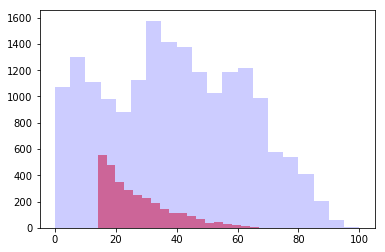

In [28]:
plt.clf()
hist = plt.hist(id[id['child_smoking_status'] == 1]['w_age'], alpha = 0.5, color ='red', bins = 20)
hist_full = plt.hist(id['w_age'], alpha = 0.2, color ='blue', bins = 20)
plt.show()

In [18]:
id['household_list'] = pandas.DataFrame(household_list)

# Sample limiting (who is a child with smoking status & parents info)

In [19]:
def parents_func(df):
    if df.child == 1:
        household = numbered_network[int(df.name)]
        connect = []
        for connection in household:
            if int(connection[0]) == df.wh4:
                connect.append(connection[-1])
        return connect
    else:
        return []

In [20]:
parents = id.apply(parents_func, axis = 1)

In [21]:
parents_exist = []
for person in parents:
    if len(person)>0:
        parents_exist.append(1)
    else:
        parents_exist.append(0) 

In [22]:
id['parents_exist']= parents_exist

In [23]:
def full_info_func(df):
    if df.child_smoking_status == 1 & df.parents_exist == 1:
        return 1
    else:
        return 0

In [24]:
full_info = id.apply(full_info_func, axis = 1)

In [25]:
id['full_info'] = full_info

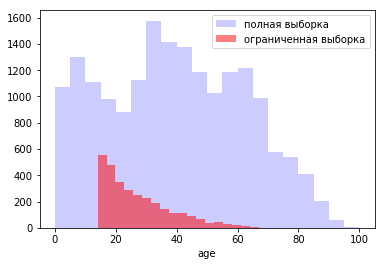

In [40]:
plt.clf()
hist_full = plt.hist(id['w_age'], alpha = 0.2, color ='blue', bins = 20)
hist = plt.hist(id[id['full_info'] == 1]['w_age'], alpha = 0.5, color ='red', bins = 20)
plt.xlabel('age')
plt.legend(['полная выборка', 'ограниченная выборка'])
plt.show()

# Variable of smoking parents

In [36]:
parent_list = []
for person in range(len(id)):
    parent_list = parent_list + parents[person]

In [37]:
parents_smoking = []
for child in range(len(id[id['full_info'] == 1])):
    household = id[id['household_list'] == id['household_list'][child]]
    parent = parents[child]
    smoking_family = []
    for member in parent:
        mom_dad = household[household.wh4 == int(member)]
        if list(mom_dad.wm71) == []:
            smoking_family.append('nan')
        else:
            if list(mom_dad.wm71)[0] == 'Äà':
                smoking_family.append(1)
            else:
                smoking_family.append(0)
    if 1 in smoking_family:
        parents_smoking.append(1)
    elif 0 in smoking_family:
        parents_smoking.append(0)
    else:
        parents_smoking.append('nan')

# Variable of smoking relatives

In [39]:
relative_smoking = []
for child in range(len(id[id['full_info'] == 1])):
    household = id[id['household_list'] == id['household_list'][child]]
    relatives = household[household.wh4 != household.wh4[child]]
    smoking_family = []
    for member in list(relatives.wm71):
        if member == 'Äà':
            smoking_family.append(1)
        elif member == 'nan':
            smoking_family.append('nan')
        else:
            smoking_family.append(0)
    if 1 in smoking_family:
        relative_smoking.append(1)
    elif 0 in smoking_family:
        relative_smoking.append(0)
    else:
        relative_smoking.append('nan')

# Full data

In [42]:
id27 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/27/27id.dta')
id26 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/26/26id.dta')
id25 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/25/25id.dta')
id24 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/24/24id.dta')
id23 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/23/23id.dta')
id22 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/22/22id.dta')
id21 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/21/21id.dta')
id20 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/20/20id.dta')
id19 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/19/19id.dta')
id18 = pandas.read_stata('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/18/18id.dta')

In [43]:
id_old = [id27, id26, id25, id24, id23, id22, id21, id20, id19, id18]

In [44]:
id = []
for dataset in id_old:
    letter = dataset.columns[0]
    dataset = dataset.sort_values(by=[letter])
    dataset['numbers'] = range(len(dataset))
    dataset = dataset.set_index('numbers')
    id.append(dataset)

In [45]:
all_relatives = []
for dataset in id:
    relatives = []
    letter = dataset.columns[0][0]
    if letter.isupper():
        b = 'B'
    else:
        b = 'b'
    nametag = letter + b
    for variable in dataset.columns:
        if nametag in variable and nametag + '9_5' not in variable and nametag + '9_1' not in variable and nametag + '9_2' not in variable and nametag + '9_3' not in variable and nametag +'9_4' not in variable:
            if '9' in variable:
                relatives.append(variable)
            else:
                pass
        else:
            pass
    all_relatives.append(relatives)

# Who has children

In [46]:
def child_func(df):
    generic = []
    for column in all_relatives[n]:
        if 'Ñûí/äî÷ü' == df[column]:
            if column[3] == '_':
                ad_surv = column[:3]+ '_1'
            else:
                ad_surv = column[:4]+ '_1'
            if df[ad_surv] == 'Åñòü èíäèâèäóàëüíûé âîïðîñíèê':
                generic.append(1)
            else:
                generic.append(0)
        else:
            generic.append(0)
    if 1 in generic:
        return 1
    else:
        return 0

In [48]:
children = []
n = 0
for dataset in id:
    child = dataset.apply(child_func, axis = 1)
    children.append(child)
    n = n + 1

# Who are the parents?

In [49]:
all_networks = []
k = 0
for dataset in id:
    network = []
    for n in range(len(dataset)):
        new_list = []
        if children[k][n] == 1:
            for variable in all_relatives[k]:
                if dataset[variable][n] == 'Ñûí/äî÷ü':
                    new_list.append(variable)
                else:
                    pass
        else:
            pass
        network.append(new_list)
    all_networks.append(network)
    k = k + 1

In [50]:
all_numbered_networks = []
for network in all_networks:
    numbered_network = []
    for family in network:
        household = []
        for member in family:
            if member[3] == '_':
                if member[-2] == '_':
                    numbered = [member[2],member[-1]]
                else:
                    numbered = [member[2],member[-2] + member[-1]]
            else:
                if member[-2] == '_':
                    numbered = [member[2] + member[3],member[-1]]
                else:
                    numbered = [member[2] + member[3],member[-2] + member[-1]]
            household.append(numbered)
        numbered_network.append(household)
    all_numbered_networks.append(numbered_network)

# Household re-indexing

In [51]:
all_households_list = []
for dataset in id:
    household_list = []
    n = 1
    old = dataset[dataset.columns[0]][0]
    for household in dataset[dataset.columns[0]]:
        if old == household:
            household_list.append(n)
        else:
            n = n + 1
            household_list.append(n)
        old = household
    all_households_list.append(household_list)

# Who is a child

In [52]:
n = 0
all_child = []
for dataset in id:
    child = []
    letter = dataset.columns[0][0]
    nametag = letter.lower() + 'h4'
    for person in range(len(dataset)):
        you_r_child = []
        if children[n][person] == 1:
            for member in range(len(all_numbered_networks[n][person])):
                if dataset[nametag][person] == int(all_numbered_networks[n][person][member][0]):
                    you_r_child.append(1)
                else:
                    you_r_child.append(0)
        else:
            pass
        if 1 in you_r_child:
            child.append(1)
        else:
            child.append(0)
    all_child.append(child)
    n = n + 1

In [53]:
n = 0
for dataset in id:
    dataset['child'] = pandas.DataFrame(all_child[n])
    n = n + 1

# Child Smoking Status

In [54]:
n = 0
all_child_smoking_status = []
for dataset in id:
    child_smoking_status = []
    letter = dataset.columns[0][0]
    nametag = letter.lower() + 'm71'
    for person in range(len(dataset)):
        if pandas.isnull(dataset[nametag][person]) == False and dataset.child[person] == 1:
            child_smoking_status.append(1)
        else:
            child_smoking_status.append(0)
    all_child_smoking_status.append(child_smoking_status)
    n = n + 1

In [55]:
n = 0
for dataset in id:
    dataset['child_smoking_status'] = pandas.DataFrame(all_child_smoking_status[n])
    n = n + 1

In [56]:
n = 0
for dataset in id:
    dataset['household_list'] = pandas.DataFrame(all_households_list[n])
    n = n + 1

# Children with full info

In [57]:
def parents_func(df):
    letter = df.keys()[0][0]
    nametag = letter.lower() + 'h4'
    if df.child == 1:
        household = all_numbered_networks[n][int(df.name)]
        connect = []
        for connection in household:
            if int(connection[0]) == df[nametag]:
                connect.append(connection[-1])
        return connect
    else:
        return []

In [58]:
all_parents = []
n = 0
for dataset in id:
    parent = dataset.apply(parents_func, axis = 1)
    all_parents.append(parent)
    n = n + 1

In [59]:
all_parents_exist = []
for parents in all_parents:
    parents_exist = []
    for person in parents:
        if len(person)>0:
            parents_exist.append(1)
        else:
            parents_exist.append(0)
    all_parents_exist.append(parents_exist)

In [60]:
n = 0
for dataset in id:
    dataset['parents_exist']= pandas.DataFrame(all_parents_exist[n])
    n = n + 1

In [61]:
def full_info_func(df):
    if df.child_smoking_status == 1 & df.parents_exist == 1:
        generic = []
        letter = df.keys()[0][0]
        nametag = letter.lower() + 'h4'
        columns = []
        for column in all_relatives[n]:
            if column[3] == '_':
                if int(column[2]) == df[nametag]:
                    columns.append(column)
                else:
                    pass
            else:
                if int(column[2] + column[3]) == df[nametag]:
                    columns.append(column)
                else:
                    pass 
        for column in columns:
            print(df.name)
            if 'Ñûí/äî÷ü' == df[column]:
                print(column)
                if column[-2] == '_':
                    ad_surv = column[:2] + column[-1]+ '_1'
                else:
                    ad_surv = column[:2] + column[-2:]+ '_1'
                if df[ad_surv] == 'Åñòü èíäèâèäóàëüíûé âîïðîñíèê':
                    generic.append(1)
                else:
                    generic.append(0)
            else:
                pass
        if 0 in generic:
            return 0
        else:
            return 1
    else:
        return 0

In [62]:
n = 0
for dataset in id:
    full_info = dataset.apply(full_info_func, axis = 1)
    dataset['full_info'] = pandas.DataFrame(full_info)
    n = n + 1

5
WB2_9_1
17
17
WB4_9_2
17
20
WB3_9_1
20
WB3_9_2
26
WB4_9_1
26
WB4_9_2
26
27
WB3_9_1
27
WB3_9_2
30
WB2_9_1
32
WB3_9_1
32
36
WB4_9_1
36
36
41
WB3_9_1
41
WB3_9_2
54
WB2_9_1
64
WB3_9_1
64
WB3_9_2
74
WB4_9_1
74
WB4_9_2
74
79
WB3_9_1
79
WB3_9_2
89
WB3_9_1
89
104
104
WB3_9_2
106
WB2_9_1
110
WB3_9_1
110
WB3_9_2
111
WB4_9_1
111
WB4_9_2
111
112
WB3_9_1
112
WB3_9_2
120
WB3_9_1
120
133
WB3_9_1
133
139
WB2_9_1
141
WB4_9_1
141
WB4_9_2
141
150
WB2_9_1
152
152
WB3_9_2
163
163
WB3_9_2
183
183
WB3_9_2
207
207
WB5_9_2
207
WB5_9_3
207
244
244
244
WB7_9_3
244
244
WB7_9_5
244
249
249
249
249
249
249
249
WB8_9_7
267
WB3_9_1
267
WB3_9_2
271
WB3_9_1
271
WB3_9_2
275
WB3_9_1
275
WB3_9_2
282
WB3_9_1
282
300
WB3_9_1
300
WB3_9_2
307
WB3_9_1
307
310
WB3_9_1
310
314
WB3_9_1
314
WB3_9_2
326
326
WB3_9_2
332
332
WB3_9_2
335
WB3_9_1
335
339
WB3_9_1
339
WB3_9_2
342
342
WB4_9_2
342
345
345
345
345
345
345
345
WB9_9_7
345
WB9_9_8
366
366
366
366
WB5_9_4
384
WB3_9_1
384
WB3_9_2
385
WB3_9_1
385
390
WB2_9_1
395
WB2_9_1
396
WB

2745
WB3_9_1
2745
WB3_9_2
2750
WB3_9_1
2750
WB3_9_2
2754
2754
2754
2754
2754
WB6_9_5
2755
WB5_9_1
2755
2755
2755
2756
2756
2756
2756
2756
WB7_9_5
2756
2759
2759
2759
2759
WB9_9_4
2759
2759
2759
2759
2760
2760
2760
2760
WB6_9_4
2760
2761
2761
2761
2761
WB6_9_4
2761
WB6_9_5
2766
2766
2766
WB5_9_3
2766
2768
WB3_9_1
2768
WB3_9_2
2776
2776
2776
WB9_9_3
2776
2776
2776
2776
WB9_9_7
2776
2779
2779
2779
2779
WB7_9_4
2779
WB7_9_5
2779
2781
2781
2781
2781
WB6_9_4
2781
WB6_9_5
2782
2782
2782
2782
WB8_9_4
2782
WB8_9_5
2782
2782
2796
WB3_9_1
2796
WB3_9_2
2806
2806
WB3_9_2
2808
WB4_9_1
2808
2808
2817
WB3_9_1
2817
WB3_9_2
2819
WB4_9_1
2819
WB4_9_2
2819
2823
WB4_9_1
2823
WB4_9_2
2823
2824
WB3_9_1
2824
WB3_9_2
2851
2851
2851
2851
2851
WB9_9_5
2851
2851
2851
2856
2856
2856
WB9_9_3
2856
2856
2856
2856
2856
2857
WB3_9_1
2857
2858
2858
2858
2858
2858
WB7_9_5
2858
2861
2861
2861
2861
2861
WB6_9_5
2862
WB5_9_1
2862
2862
2862
2866
WB2_9_1
2869
2869
2869
WB6_9_3
2869
2869
WB6_9_5
2875
WB2_9_1
2882
WB3_9_1
2882


4545
4545
WB4_9_2
4545
4559
WB2_9_1
4583
WB2_9_1
4590
WB3_9_1
4590
WB3_9_2
4592
WB4_9_1
4592
WB4_9_2
4592
4597
WB3_9_1
4597
WB3_9_2
4602
WB2_9_1
4613
WB2_9_1
4615
WB4_9_1
4615
4615
4621
WB4_9_1
4621
4621
4622
4622
4622
4622
WB5_9_4
4625
WB4_9_1
4625
4625
4629
WB3_9_1
4629
WB3_9_2
4630
WB4_9_1
4630
WB4_9_2
4630
4631
4631
4631
4631
WB5_9_4
4637
WB5_9_1
4637
4637
4637
WB5_9_4
4640
4640
4640
4640
WB5_9_4
4642
WB4_9_1
4642
WB4_9_2
4642
4643
WB3_9_1
4643
WB3_9_2
4655
WB3_9_1
4655
WB3_9_2
4657
WB3_9_1
4657
WB3_9_2
4661
4661
4661
WB6_9_3
4661
4661
4663
4663
4663
WB5_9_3
4663
4664
WB3_9_1
4664
4668
4668
4668
WB8_9_3
4668
4668
4668
4668
WB8_9_7
4670
WB4_9_1
4670
WB4_9_2
4670
4671
4671
WB3_9_2
4674
4674
4674
WB6_9_3
4674
4674
4679
WB3_9_1
4679
WB3_9_2
4684
WB2_9_1
4705
WB3_9_1
4705
WB3_9_2
4709
WB3_9_1
4709
WB3_9_2
4711
WB4_9_1
4711
WB4_9_2
4711
4717
WB3_9_1
4717
WB3_9_2
4723
WB3_9_1
4723
WB3_9_2
4727
WB2_9_1
4736
WB2_9_1
4739
WB2_9_1
4752
WB4_9_1
4752
WB4_9_2
4752
4758
WB3_9_1
4758
WB3_9_2
4761


6336
WB3_9_1
6336
WB3_9_2
6339
WB2_9_1
6350
6350
WB4_9_2
6350
WB4_9_3
6352
WB2_9_1
6362
WB3_9_1
6362
WB3_9_2
6372
WB2_9_1
6376
WB3_9_1
6376
WB3_9_2
6381
WB3_9_1
6381
6385
6385
6385
6385
WB6_9_4
6385
WB6_9_5
6390
WB2_9_1
6394
WB3_9_1
6394
WB3_9_2
6407
WB2_9_1
6419
WB3_9_1
6419
WB3_9_2
6431
WB3_9_1
6431
WB3_9_2
6435
WB2_9_1
6446
WB2_9_1
6456
WB3_9_1
6456
WB3_9_2
6458
WB2_9_1
6462
6462
6462
WB5_9_3
6462
WB5_9_4
6464
WB4_9_1
6464
WB4_9_2
6464
6465
WB3_9_1
6465
WB3_9_2
6475
WB3_9_1
6475
WB3_9_2
6476
WB4_9_1
6476
WB4_9_2
6476
6480
6480
WB3_9_2
6487
6487
WB5_9_2
6487
6487
6489
6489
WB3_9_2
6490
WB2_9_1
6494
WB3_9_1
6494
6518
WB4_9_1
6518
WB4_9_2
6518
6524
6524
WB4_9_2
6524
6530
WB3_9_1
6530
WB3_9_2
6533
6533
6533
6533
WB5_9_4
6534
WB4_9_1
6534
6534
6542
WB2_9_1
6544
WB2_9_1
6553
6553
6553
WB7_9_3
6553
6553
WB7_9_5
6553
6555
6555
6555
WB6_9_3
6555
6555
WB6_9_5
6568
WB3_9_1
6568
WB3_9_2
6571
6571
6571
WB4_9_3
6572
6572
WB3_9_2
6574
WB3_9_1
6574
6576
WB3_9_1
6576
6578
WB4_9_1
6578
6578
6593
WB2_

WB3_9_1
8033
8036
8036
WB3_9_2
8039
8039
WB5_9_2
8039
8039
8041
WB3_9_1
8041
8054
WB2_9_1
8059
WB2_9_1
8069
8069
8069
WB6_9_3
8069
8069
8072
WB3_9_1
8072
WB3_9_2
8078
8078
WB5_9_2
8078
8078
WB5_9_4
8082
8082
WB5_9_2
8082
8082
8084
8084
8084
WB5_9_3
8084
WB5_9_4
8094
WB3_9_1
8094
WB3_9_2
8096
WB4_9_1
8096
WB4_9_2
8096
8101
8101
WB3_9_2
8104
8104
WB4_9_2
8104
WB4_9_3
8105
8105
8105
WB5_9_3
8105
8106
8106
8106
WB6_9_3
8106
8106
8109
8109
8109
8109
WB6_9_4
8109
8111
8111
8111
8111
WB5_9_4
8122
WB3_9_1
8122
WB3_9_2
8128
WB2_9_1
8143
WB2_9_1
8149
WB3_9_1
8149
WB3_9_2
8173
WB2_9_1
8184
8184
WB3_9_2
8209
WB3_9_1
8209
8214
8214
WB3_9_2
8217
WB4_9_1
8217
WB4_9_2
8217
8218
8218
8218
8218
WB6_9_4
8218
8226
8226
8226
8226
8226
WB10_9_5
8226
8226
8226
8226
8231
WB4_9_1
8231
WB4_9_2
8231
8233
8233
8233
8233
WB5_9_4
8238
8238
8238
WB4_9_3
8267
WB2_9_1
8280
WB4_9_1
8280
WB4_9_2
8280
8294
8294
8294
8294
8294
WB13_9_5
8294
8294
8294
8294
8294
8294
8294
WB139_12
8295
WB4_9_1
8295
WB4_9_2
8295
8310
8310
83

9731
9731
WB3_9_2
9732
9732
9732
WB5_9_3
9732
9733
9733
9733
WB6_9_3
9733
9733
9734
9734
WB8_9_2
9734
9734
9734
9734
9734
9737
WB3_9_1
9737
WB3_9_2
9738
9738
9738
WB5_9_3
9738
WB5_9_4
9739
9739
9739
WB6_9_3
9739
WB6_9_4
9739
9743
WB3_9_1
9743
WB3_9_2
9744
9744
9744
WB6_9_3
9744
WB6_9_4
9744
9751
9751
WB5_9_2
9751
9751
9752
9752
WB3_9_2
9753
9753
WB4_9_2
9753
9756
WB3_9_1
9756
WB3_9_2
9757
9757
9757
WB6_9_3
9757
WB6_9_4
9757
9759
9759
9759
WB5_9_3
9759
WB5_9_4
9767
9767
9767
9767
9767
9767
WB7_9_6
9768
9768
9768
WB7_9_3
9768
WB7_9_4
9768
9768
9769
9769
9769
WB6_9_3
9769
WB6_9_4
9769
9771
9771
9771
WB5_9_3
9771
WB5_9_4
9773
9773
9773
WB6_9_3
9773
WB6_9_4
9773
9774
9774
9774
WB5_9_3
9774
WB5_9_4
9776
WB3_9_1
9776
WB3_9_2
9781
9781
9781
9781
WB6_9_4
9781
WB6_9_5
9785
9785
9785
9785
9785
9785
9785
WB9_9_7
9785
9786
9786
9786
9786
9786
9786
9786
WB8_9_7
9790
WB5_9_1
9790
WB5_9_2
9790
9790
9791
WB3_9_1
9791
WB3_9_2
9794
WB4_9_1
9794
WB4_9_2
9794
9797
9797
9797
9797
9797
9797
9797
WB11_9_7
979

11097
WB4_9_1
11097
11097
11103
WB2_9_1
11116
11116
WB3_9_2
11124
WB4_9_1
11124
WB4_9_2
11124
11126
WB4_9_1
11126
WB4_9_2
11126
11144
WB4_9_1
11144
WB4_9_2
11144
11151
WB2_9_1
11152
11152
WB3_9_2
11157
WB3_9_1
11157
WB3_9_2
11159
11159
11159
WB5_9_3
11159
WB5_9_4
11162
11162
WB5_9_2
11162
WB5_9_3
11162
11163
WB3_9_1
11163
11167
WB3_9_1
11167
WB3_9_2
11168
WB4_9_1
11168
WB4_9_2
11168
11171
11171
11171
WB7_9_3
11171
11171
11171
11186
WB3_9_1
11186
WB3_9_2
11189
WB9_9_1
11189
11189
11189
11189
11189
11189
11189
11190
11190
11190
11190
WB8_9_4
11190
11190
11190
11206
11206
11206
WB4_9_3
11208
11208
WB5_9_2
11208
11208
11223
11223
11223
11223
11223
11223
11223
WB8_9_7
11234
WB3_9_1
11234
WB3_9_2
11244
WB4_9_1
11244
WB4_9_2
11244
11268
WB6_9_1
11268
WB6_9_2
11268
11268
11268
11270
WB9_9_1
11270
WB9_9_2
11270
11270
11270
11270
11270
11270
11273
11273
WB6_9_2
11273
WB6_9_3
11273
11273
11284
11284
11284
11284
WB9_9_4
11284
11284
11284
11284
WB9_9_8
11289
11289
11289
WB13_9_3
11289
11289
11289
1

13134
13134
13134
WB4_9_3
13136
WB3_9_1
13136
13141
WB3_9_1
13141
13142
WB4_9_1
13142
13142
13144
13144
WB3_9_2
13148
WB4_9_1
13148
WB4_9_2
13148
13150
WB3_9_1
13150
WB3_9_2
13167
13167
WB3_9_2
13169
WB2_9_1
13173
13173
WB4_9_2
13173
13175
WB3_9_1
13175
WB3_9_2
13192
WB3_9_1
13192
13194
WB2_9_1
13212
WB3_9_1
13212
13213
WB4_9_1
13213
13213
13220
13220
WB3_9_2
13224
13224
WB3_9_2
13226
WB3_9_1
13226
WB3_9_2
13230
13230
WB10_9_2
13230
13230
13230
13230
13230
13230
13230
13232
13232
WB5_9_2
13232
13232
13236
13236
WB3_9_2
13285
13285
WB3_9_2
13287
WB2_9_1
13296
WB3_9_1
13296
WB3_9_2
13307
WB2_9_1
13313
WB3_9_1
13313
WB3_9_2
13316
WB5_9_1
13316
WB5_9_2
13316
13316
13321
WB3_9_1
13321
WB3_9_2
13322
WB4_9_1
13322
WB4_9_2
13322
13326
WB3_9_1
13326
WB3_9_2
13332
WB3_9_1
13332
13334
WB2_9_1
13339
WB2_9_1
13344
WB3_9_1
13344
WB3_9_2
13348
13348
13348
13348
WB7_9_4
13348
13348
13355
WB3_9_1
13355
WB3_9_2
13358
WB4_9_1
13358
WB4_9_2
13358
13361
13361
WB4_9_2
13361
WB4_9_3
13363
WB2_9_1
13367
13367

15918
WB4_9_1
15918
15918
15928
WB2_9_1
15936
WB2_9_1
15946
WB4_9_1
15946
15946
15948
WB3_9_1
15948
15950
WB4_9_1
15950
15950
15959
WB2_9_1
15962
15962
15962
WB4_9_3
15963
WB3_9_1
15963
15968
15968
WB4_9_2
15968
WB4_9_3
15973
15973
15973
15973
15973
15973
WB8_9_6
15973
WB8_9_7
15990
WB2_9_1
15995
WB3_9_1
15995
WB3_9_2
15999
15999
WB3_9_2
16011
16011
WB4_9_2
16011
16026
WB2_9_1
16029
16029
WB4_9_2
16029
16035
WB2_9_1
16044
WB2_9_1
16052
WB2_9_1
16053
16053
WB4_9_2
16053
16074
WB4_9_1
16074
WB4_9_2
16074
16075
WB3_9_1
16075
WB3_9_2
16079
WB3_9_1
16079
WB3_9_2
16084
WB3_9_1
16084
WB3_9_2
16089
16089
16089
WB5_9_3
16089
16092
16092
16092
WB4_9_3
16093
16093
16093
16093
WB5_9_4
16095
16095
WB3_9_2
16101
16101
WB6_9_2
16101
16101
16101
16115
16115
16115
16115
WB5_9_4
16125
WB3_9_1
16125
WB3_9_2
16129
16129
16129
WB7_9_3
16129
WB7_9_4
16129
16129
16131
16131
16131
16131
WB5_9_4
16133
16133
16133
16133
WB7_9_4
16133
16133
16161
16161
16161
WB5_9_3
16161
16164
WB5_9_1
16164
16164
16164
16169
WB

17759
WB4_9_1
17759
WB4_9_2
17759
17761
WB3_9_1
17761
WB3_9_2
17764
17764
WB4_9_2
17764
17780
17780
WB4_9_2
17780
WB4_9_3
17788
WB3_9_1
17788
WB3_9_2
17795
17795
WB4_9_2
17795
17799
17799
WB3_9_2
17801
WB3_9_1
17801
17830
17830
17830
17830
WB7_9_4
17830
17830
WB7_9_6
17833
17833
17833
17833
WB7_9_4
17833
17833
WB7_9_6
17845
WB2_9_1
17846
WB3_9_1
17846
17852
WB4_9_1
17852
17852
17853
17853
WB3_9_2
17856
WB4_9_1
17856
WB4_9_2
17856
17862
17862
17862
17862
17862
17862
WB8_9_6
17862
WB8_9_7
17869
17869
17869
17869
17869
17869
17869
17869
17869
WB10_9_9
17876
WB2_9_1
17880
17880
WB5_9_2
17880
17880
WB5_9_4
17883
17883
WB3_9_2
17884
17884
WB3_9_2
17885
WB2_9_1
17901
WB4_9_1
17901
WB4_9_2
17901
17903
WB4_9_1
17903
17903
17904
WB3_9_1
17904
17911
WB3_9_1
17911
WB3_9_2
17912
WB4_9_1
17912
WB4_9_2
17912
17938
WB4_9_1
17938
WB4_9_2
17938
17940
WB4_9_1
17940
17940
17946
17946
17946
17946
WB7_9_4
17946
17946
17951
17951
17951
WB5_9_3
17951
17952
17952
17952
WB4_9_3
17953
WB3_9_1
17953
WB3_9_2
17958

1782
VB3_9_1
1782
VB3_9_2
1788
1788
1788
1788
1788
1788
1788
1788
1788
1788
VB119_10
1793
1793
1793
1793
1793
1793
1793
1793
1793
1793
VB129_10
1793
1799
VB11_9_1
1799
VB11_9_2
1799
1799
1799
1799
1799
1799
1799
1799
1802
1802
1802
1802
VB5_9_4
1803
1803
1803
1803
VB5_9_4
1807
1807
1807
VB4_9_3
1810
1810
VB3_9_2
1819
VB3_9_1
1819
1820
1820
1820
VB4_9_3
1824
VB3_9_1
1824
1829
VB2_9_1
1833
VB4_9_1
1833
1833
VB4_9_3
1841
VB3_9_1
1841
VB3_9_2
1847
VB3_9_1
1847
VB3_9_2
1853
VB3_9_1
1853
1867
VB3_9_1
1867
VB3_9_2
1879
1879
VB4_9_2
1879
1880
1880
VB5_9_2
1880
1880
1884
VB2_9_1
1888
VB3_9_1
1888
VB3_9_2
1902
1902
VB3_9_2
1906
VB3_9_1
1906
VB3_9_2
1911
VB3_9_1
1911
VB3_9_2
1916
VB3_9_1
1916
VB3_9_2
1919
1919
VB3_9_2
1921
VB2_9_1
1923
1923
1923
VB5_9_3
1923
1943
1943
1943
VB4_9_3
1949
1949
1949
VB6_9_3
1949
VB6_9_4
1949
1951
1951
1951
VB5_9_3
1951
VB5_9_4
1954
1954
1954
VB4_9_3
1959
VB3_9_1
1959
VB3_9_2
1961
VB3_9_1
1961
1969
VB6_9_1
1969
VB6_9_2
1969
1969
1969
1970
VB9_9_1
1970
VB9_9_2
1970
197

3576
VB4_9_1
3576
3576
3577
VB4_9_1
3577
3577
3581
VB4_9_1
3581
VB4_9_2
3581
3587
VB3_9_1
3587
VB3_9_2
3588
VB4_9_1
3588
VB4_9_2
3588
3594
VB3_9_1
3594
3599
VB3_9_1
3599
VB3_9_2
3601
VB2_9_1
3608
VB3_9_1
3608
VB3_9_2
3613
3613
3613
VB4_9_3
3616
VB5_9_1
3616
VB5_9_2
3616
3616
3632
VB5_9_1
3632
VB5_9_2
3632
3632
3638
VB4_9_1
3638
VB4_9_2
3638
3644
VB3_9_1
3644
3646
VB5_9_1
3646
3646
3646
3647
3647
VB6_9_2
3647
3647
3647
3648
VB7_9_1
3648
3648
3648
3648
3648
3652
VB3_9_1
3652
3656
VB2_9_1
3658
VB3_9_1
3658
3660
VB2_9_1
3662
VB2_9_1
3664
3664
3664
VB7_9_3
3664
3664
3664
VB7_9_6
3690
3690
3690
3690
3690
3690
3690
VB8_9_7
3692
3692
3692
3692
3692
3692
3692
3692
3692
3692
VB119_10
3717
3717
3717
VB13_9_3
3717
3717
3717
3717
3717
3717
3717
3717
3717
3718
3718
VB5_9_2
3718
VB5_9_3
3718
3747
VB3_9_1
3747
3752
VB3_9_1
3752
3754
3754
VB5_9_2
3754
3754
3772
VB5_9_1
3772
VB5_9_2
3772
3772
3798
VB3_9_1
3798
VB3_9_2
3801
VB5_9_1
3801
VB5_9_2
3801
3801
3806
3806
3806
VB5_9_3
3806
3814
3814
VB3_9_2
3816

5274
VB4_9_1
5274
5274
5275
VB3_9_1
5275
5278
VB3_9_1
5278
VB3_9_2
5281
VB3_9_1
5281
VB3_9_2
5290
VB3_9_1
5290
VB3_9_2
5303
VB3_9_1
5303
VB3_9_2
5304
VB4_9_1
5304
VB4_9_2
5304
5306
5306
VB4_9_2
5306
5318
5318
5318
5318
5318
VB8_9_5
5318
5318
5327
VB4_9_1
5327
5327
5336
VB3_9_1
5336
5338
VB3_9_1
5338
5341
VB4_9_1
5341
VB4_9_2
5341
5344
VB3_9_1
5344
VB3_9_2
5345
5345
5345
VB6_9_3
5345
5345
5348
5348
5348
VB7_9_3
5348
5348
VB7_9_5
5348
5349
5349
5349
VB6_9_3
5349
5349
VB6_9_5
5360
VB3_9_1
5360
VB3_9_2
5370
5370
VB3_9_2
5371
5371
VB5_9_2
5371
5371
VB5_9_4
5373
VB4_9_1
5373
VB4_9_2
5373
5374
VB3_9_1
5374
VB3_9_2
5378
VB3_9_1
5378
VB3_9_2
5382
VB3_9_1
5382
VB3_9_2
5391
5391
5391
VB6_9_3
5391
5391
VB6_9_5
5400
VB4_9_1
5400
5400
5401
5401
5401
5401
VB5_9_4
5405
5405
5405
5405
5405
VB7_9_5
5405
VB7_9_6
5412
VB5_9_1
5412
5412
5412
5422
5422
VB5_9_2
5422
5422
VB5_9_4
5426
VB3_9_1
5426
5462
VB4_9_1
5462
VB4_9_2
5462
5464
VB2_9_1
5475
5475
5475
VB10_9_3
5475
5475
5475
5475
5475
5475
5500
5500
VB6_9

7758
VB2_9_1
7763
VB3_9_1
7763
VB3_9_2
7771
VB3_9_1
7771
7787
VB4_9_1
7787
VB4_9_2
7787
7791
7791
7791
VB5_9_3
7791
VB5_9_4
7820
VB2_9_1
7825
VB4_9_1
7825
VB4_9_2
7825
7827
VB3_9_1
7827
VB3_9_2
7829
VB3_9_1
7829
VB3_9_2
7835
VB4_9_1
7835
VB4_9_2
7835
7842
VB2_9_1
7847
VB4_9_1
7847
7847
7850
VB4_9_1
7850
VB4_9_2
7850
7871
VB5_9_1
7871
VB5_9_2
7871
7871
7876
VB4_9_1
7876
VB4_9_2
7876
7882
VB2_9_1
7888
VB2_9_1
7891
VB2_9_1
7892
7892
7892
7892
7892
VB6_9_5
7899
VB2_9_1
7906
VB5_9_1
7906
7906
7906
7917
7917
VB4_9_2
7917
7930
7930
7930
7930
VB5_9_4
7932
7932
7932
7932
VB7_9_4
7932
VB7_9_5
7932
7936
VB5_9_1
7936
VB5_9_2
7936
7936
7941
VB4_9_1
7941
VB4_9_2
7941
7943
VB3_9_1
7943
VB3_9_2
7956
7956
7956
VB5_9_3
7956
7960
7960
7960
VB8_9_3
7960
7960
7960
7960
VB8_9_7
7961
VB3_9_1
7961
7963
7963
7963
VB6_9_3
7963
7963
7968
7968
7968
VB6_9_3
7968
7968
7973
VB4_9_1
7973
VB4_9_2
7973
7974
VB3_9_1
7974
VB3_9_2
7977
VB3_9_1
7977
7978
VB2_9_1
7986
VB3_9_1
7986
VB3_9_2
7987
7987
7987
VB4_9_3
7997
VB3_9_1

9146
9146
VB10_9_2
9146
9146
9146
9146
9146
9146
9146
9148
9148
VB8_9_2
9148
9148
9148
9148
9148
9149
VB5_9_1
9149
VB5_9_2
9149
9149
9150
VB3_9_1
9150
VB3_9_2
9152
VB4_9_1
9152
VB4_9_2
9152
9157
9157
VB4_9_2
9157
VB4_9_3
9158
VB3_9_1
9158
9159
9159
9159
VB7_9_3
9159
9159
9159
9160
9160
9160
VB6_9_3
9160
9160
9161
9161
9161
VB5_9_3
9161
9164
9164
9164
9164
9164
9164
VB8_9_6
9164
9165
9165
9165
9165
9165
9165
VB9_9_6
9165
9165
9166
9166
VB5_9_2
9166
9166
9171
9171
VB3_9_2
9174
9174
VB3_9_2
9175
9175
VB3_9_2
9178
9178
9178
VB10_9_3
9178
9178
VB10_9_5
9178
9178
9178
9178
9179
9179
9179
VB9_9_3
9179
9179
VB9_9_5
9179
9179
9179
9180
9180
9180
VB11_9_3
9180
9180
VB11_9_5
9180
9180
9180
9180
9180
9185
9185
9185
VB10_9_3
9185
VB10_9_4
9185
9185
9185
9185
9185
9188
9188
9188
VB9_9_3
9188
VB9_9_4
9188
9188
9188
9188
9190
9190
9190
VB5_9_3
9190
VB5_9_4
9192
9192
9192
VB11_9_3
9192
VB11_9_4
9192
9192
9192
9192
9192
9192
9196
VB3_9_1
9196
VB3_9_2
9197
9197
9197
VB6_9_3
9197
VB6_9_4
9197
9199
VB3_9_1

10812
VB4_9_1
10812
VB4_9_2
10812
10816
VB3_9_1
10816
VB3_9_2
10825
VB3_9_1
10825
VB3_9_2
10840
VB2_9_1
10882
10882
10882
10882
10882
VB8_9_5
10882
10882
VB8_9_7
10894
VB4_9_1
10894
VB4_9_2
10894
10898
VB2_9_1
10901
VB2_9_1
10906
VB3_9_1
10906
VB3_9_2
10910
10910
10910
VB4_9_3
10918
VB3_9_1
10918
VB3_9_2
10922
VB2_9_1
10926
VB3_9_1
10926
VB3_9_2
10929
VB4_9_1
10929
VB4_9_2
10929
10935
10935
VB3_9_2
10940
10940
10940
VB5_9_3
10940
VB5_9_4
10946
VB4_9_1
10946
VB4_9_2
10946
10955
10955
10955
10955
VB5_9_4
10959
VB4_9_1
10959
10959
10962
VB3_9_1
10962
10967
VB3_9_1
10967
VB3_9_2
10968
VB4_9_1
10968
VB4_9_2
10968
10969
VB4_9_1
10969
VB4_9_2
10969
10971
VB3_9_1
10971
VB3_9_2
10974
VB3_9_1
10974
VB3_9_2
10977
VB2_9_1
10987
VB3_9_1
10987
VB3_9_2
10989
VB4_9_1
10989
VB4_9_2
10989
10990
VB3_9_1
10990
10994
VB2_9_1
10996
VB3_9_1
10996
11003
11003
VB3_9_2
11005
VB3_9_1
11005
VB3_9_2
11012
VB3_9_1
11012
11013
VB4_9_1
11013
11013
11015
VB4_9_1
11015
VB4_9_2
11015
11018
VB3_9_1
11018
VB3_9_2
11029
11

12862
12862
12862
VB5_9_3
12862
12863
12863
12863
12863
VB5_9_4
12865
12865
VB3_9_2
12866
VB2_9_1
12867
VB4_9_1
12867
12867
12870
VB3_9_1
12870
VB3_9_2
12878
VB3_9_1
12878
12900
VB3_9_1
12900
12902
12902
12902
VB4_9_3
12907
12907
VB4_9_2
12907
12916
VB3_9_1
12916
VB3_9_2
12924
VB2_9_1
12931
VB3_9_1
12931
VB3_9_2
12941
VB3_9_1
12941
VB3_9_2
12947
VB3_9_1
12947
VB3_9_2
12953
12953
VB7_9_2
12953
12953
12953
12953
VB7_9_6
12961
12961
VB3_9_2
12966
VB3_9_1
12966
VB3_9_2
12968
VB4_9_1
12968
VB4_9_2
12968
12974
VB2_9_1
12981
VB3_9_1
12981
12983
12983
12983
VB4_9_3
12986
VB2_9_1
12993
VB3_9_1
12993
VB3_9_2
12996
VB3_9_1
12996
VB3_9_2
13004
VB3_9_1
13004
VB3_9_2
13007
13007
13007
13007
VB5_9_4
13011
VB2_9_1
13012
VB3_9_1
13012
13016
VB3_9_1
13016
13018
VB2_9_1
13028
VB3_9_1
13028
VB3_9_2
13031
VB2_9_1
13039
VB4_9_1
13039
13039
13040
VB3_9_1
13040
13041
VB2_9_1
13042
VB5_9_1
13042
13042
13042
13044
VB2_9_1
13046
VB3_9_1
13046
VB3_9_2
13048
VB4_9_1
13048
VB4_9_2
13048
13087
13087
VB3_9_2
13097
VB

15004
VB3_9_1
15004
VB3_9_2
15024
VB3_9_1
15024
15025
VB2_9_1
15040
VB3_9_1
15040
15058
VB3_9_1
15058
VB3_9_2
15068
15068
15068
VB6_9_3
15068
15068
VB6_9_5
15069
15069
VB4_9_2
15069
15071
15071
15071
VB5_9_3
15071
15077
VB3_9_1
15077
VB3_9_2
15080
VB2_9_1
15081
15081
VB4_9_2
15081
VB4_9_3
15082
15082
VB5_9_2
15082
VB5_9_3
15082
15085
15085
VB3_9_2
15089
15089
VB3_9_2
15091
15091
15091
VB4_9_3
15117
VB3_9_1
15117
VB3_9_2
15118
VB3_9_1
15118
VB3_9_2
15124
VB3_9_1
15124
15130
15130
15130
VB5_9_3
15130
15139
VB2_9_1
15141
VB4_9_1
15141
VB4_9_2
15141
15150
VB3_9_1
15150
VB3_9_2
15158
VB3_9_1
15158
VB3_9_2
15170
VB4_9_1
15170
VB4_9_2
15170
15175
VB2_9_1
15176
15176
VB3_9_2
15180
15180
15180
15180
15180
15180
15180
15180
15180
15180
15180
VB129_11
15181
VB3_9_1
15181
15185
15185
VB3_9_2
15189
15189
VB3_9_2
15193
VB3_9_1
15193
VB3_9_2
15194
VB4_9_1
15194
VB4_9_2
15194
15204
VB3_9_1
15204
VB3_9_2
15221
VB2_9_1
15238
VB2_9_1
15242
15242
VB3_9_2
15248
VB2_9_1
15254
15254
15254
VB5_9_3
15254
15257

17507
VB3_9_1
17507
17512
VB3_9_1
17512
VB3_9_2
17527
17527
17527
VB5_9_3
17527
VB5_9_4
17532
VB3_9_1
17532
17537
VB4_9_1
17537
VB4_9_2
17537
17548
VB2_9_1
17560
VB2_9_1
17568
17568
17568
17568
17568
17568
17568
VB8_9_7
17576
VB3_9_1
17576
VB3_9_2
17578
17578
17578
VB4_9_3
17583
VB3_9_1
17583
VB3_9_2
17585
VB2_9_1
17586
17586
VB3_9_2
17590
17590
VB4_9_2
17590
17591
VB3_9_1
17591
17603
VB4_9_1
17603
VB4_9_2
17603
17606
VB2_9_1
17607
VB3_9_1
17607
17614
VB4_9_1
17614
VB4_9_2
17614
17618
VB3_9_1
17618
VB3_9_2
17619
VB4_9_1
17619
VB4_9_2
17619
17627
VB4_9_1
17627
VB4_9_2
17627
17634
VB3_9_1
17634
17635
17635
17635
VB4_9_3
17637
VB2_9_1
17644
17644
17644
VB4_9_3
17646
VB2_9_1
17660
VB2_9_1
17673
VB4_9_1
17673
17673
17677
17677
17677
VB4_9_3
17678
17678
17678
17678
VB5_9_4
17687
17687
VB5_9_2
17687
17687
17695
17695
VB4_9_2
17695
17701
17701
17701
17701
17701
VB6_9_5
17706
VB3_9_1
17706
VB3_9_2
17711
17711
17711
17711
VB5_9_4
17721
17721
VB4_9_2
17721
VB4_9_3
17728
VB5_9_1
17728
VB5_9_2
1772

725
UB2_9_1
732
UB4_9_1
732
UB4_9_2
732
733
UB3_9_1
733
UB3_9_2
745
UB4_9_1
745
UB4_9_2
745
748
UB3_9_1
748
UB3_9_2
753
UB4_9_1
753
753
757
UB3_9_1
757
758
UB4_9_1
758
UB4_9_2
758
763
UB4_9_1
763
UB4_9_2
763
775
UB3_9_1
775
UB3_9_2
779
779
UB4_9_2
779
780
UB2_9_1
786
UB3_9_1
786
UB3_9_2
789
UB3_9_1
789
795
UB2_9_1
797
UB3_9_1
797
801
801
UB4_9_2
801
802
UB2_9_1
805
UB3_9_1
805
808
UB4_9_1
808
UB4_9_2
808
817
UB3_9_1
817
UB3_9_2
820
UB3_9_1
820
UB3_9_2
829
UB2_9_1
832
UB3_9_1
832
UB3_9_2
833
UB4_9_1
833
UB4_9_2
833
838
UB3_9_1
838
UB3_9_2
844
UB3_9_1
844
UB3_9_2
845
UB4_9_1
845
UB4_9_2
845
851
UB3_9_1
851
UB3_9_2
855
855
855
UB4_9_3
881
UB2_9_1
884
UB3_9_1
884
UB3_9_2
890
890
890
890
890
890
890
890
890
890
890
UB139_11
890
891
891
891
891
891
891
891
891
891
891
891
UB129_11
930
930
930
930
UB6_9_4
930
935
UB3_9_1
935
UB3_9_2
937
UB3_9_1
937
UB3_9_2
959
UB2_9_1
967
UB3_9_1
967
UB3_9_2
973
973
973
UB4_9_3
975
UB2_9_1
979
UB5_9_1
979
979
UB5_9_3
979
982
UB2_9_1
985
UB4_9_1
985
UB4_9_2
98

3267
3267
UB7_9_2
3267
3267
3267
3267
UB7_9_6
3270
3270
3270
3270
UB6_9_4
3270
UB6_9_5
3274
3274
UB5_9_2
3274
UB5_9_3
3274
3278
3278
3278
3278
UB7_9_4
3278
3278
3281
3281
3281
3281
UB6_9_4
3281
3282
3282
3282
3282
3282
3282
UB7_9_6
3286
3286
3286
3286
3286
UB8_9_5
3286
UB8_9_6
3286
3299
3299
3299
UB5_9_3
3299
UB5_9_4
3300
3300
3300
UB6_9_3
3300
UB6_9_4
3300
3309
UB3_9_1
3309
UB3_9_2
3312
3312
3312
UB6_9_3
3312
3312
3313
UB5_9_1
3313
3313
3313
3314
UB4_9_1
3314
3314
3327
UB3_9_1
3327
3336
UB3_9_1
3336
3337
UB4_9_1
3337
3337
3339
UB5_9_1
3339
UB5_9_2
3339
3339
3346
3346
3346
UB6_9_3
3346
3346
3352
3352
3352
UB13_9_3
3352
3352
3352
3352
3352
3352
3352
3352
3352
UB139_12
3355
3355
3355
UB4_9_3
3363
3363
3363
UB6_9_3
3363
3363
UB6_9_5
3364
3364
3364
UB4_9_3
3371
UB5_9_1
3371
3371
3371
3373
3373
3373
3373
UB5_9_4
3375
3375
UB4_9_2
3375
3376
UB3_9_1
3376
UB3_9_2
3380
UB2_9_1
3382
UB5_9_1
3382
UB5_9_2
3382
3382
3384
UB6_9_1
3384
UB6_9_2
3384
3384
3384
3385
UB4_9_1
3385
UB4_9_2
3385
3387
UB3_9_

5075
UB4_9_1
5075
UB4_9_2
5075
5078
5078
5078
5078
5078
UB9_9_5
5078
5078
5078
5084
UB3_9_1
5084
UB3_9_2
5085
UB4_9_1
5085
UB4_9_2
5085
5108
5108
5108
UB4_9_3
5116
UB4_9_1
5116
UB4_9_2
5116
5118
UB4_9_1
5118
UB4_9_2
5118
5124
UB4_9_1
5124
UB4_9_2
5124
5125
UB4_9_1
5125
UB4_9_2
5125
5130
UB2_9_1
5132
5132
5132
UB13_9_3
5132
5132
5132
5132
5132
5132
5132
5132
5132
5133
5133
5133
UB12_9_3
5133
5133
5133
5133
5133
5133
5133
5133
5139
5139
5139
UB6_9_3
5139
5139
UB6_9_5
5146
5146
5146
5146
UB7_9_4
5146
UB7_9_5
5146
5148
5148
5148
5148
UB6_9_4
5148
UB6_9_5
5152
UB3_9_1
5152
5162
UB3_9_1
5162
UB3_9_2
5163
UB4_9_1
5163
UB4_9_2
5163
5164
UB3_9_1
5164
UB3_9_2
5172
UB3_9_1
5172
UB3_9_2
5184
UB4_9_1
5184
5184
5200
UB4_9_1
5200
5200
5207
UB3_9_1
5207
UB3_9_2
5242
5242
5242
UB7_9_3
5242
5242
5242
UB7_9_6
5251
UB4_9_1
5251
5251
5252
UB3_9_1
5252
5257
5257
5257
5257
UB5_9_4
5261
UB3_9_1
5261
5262
UB4_9_1
5262
5262
5266
UB3_9_1
5266
5284
5284
5284
5284
5284
5284
5284
UB8_9_7
5289
UB3_9_1
5289
UB3_9_2
5

7689
UB2_9_1
7694
7694
UB3_9_2
7702
UB2_9_1
7704
UB3_9_1
7704
7714
UB5_9_1
7714
7714
7714
7715
UB3_9_1
7715
7716
UB4_9_1
7716
7716
7735
7735
7735
7735
UB5_9_4
7739
UB3_9_1
7739
7747
UB4_9_1
7747
UB4_9_2
7747
7749
UB3_9_1
7749
UB3_9_2
7752
UB5_9_1
7752
UB5_9_2
7752
7752
7761
UB2_9_1
7767
UB4_9_1
7767
UB4_9_2
7767
7771
UB3_9_1
7771
7775
UB4_9_1
7775
UB4_9_2
7775
7783
7783
7783
UB4_9_3
7785
UB2_9_1
7786
UB3_9_1
7786
7798
UB3_9_1
7798
7801
UB3_9_1
7801
UB3_9_2
7805
7805
7805
7805
7805
UB6_9_5
7813
UB2_9_1
7816
UB3_9_1
7816
7822
UB3_9_1
7822
UB3_9_2
7823
UB4_9_1
7823
UB4_9_2
7823
7842
7842
UB3_9_2
7846
UB2_9_1
7869
UB3_9_1
7869
UB3_9_2
7876
7876
UB4_9_2
7876
7913
UB3_9_1
7913
7915
UB2_9_1
7916
UB3_9_1
7916
7921
UB2_9_1
7928
UB3_9_1
7928
UB3_9_2
7936
UB3_9_1
7936
7946
7946
UB4_9_2
7946
7947
7947
UB3_9_2
7949
UB4_9_1
7949
UB4_9_2
7949
7950
UB3_9_1
7950
UB3_9_2
7962
UB3_9_1
7962
UB3_9_2
7971
UB2_9_1
7974
UB3_9_1
7974
UB3_9_2
7982
UB2_9_1
7985
7985
UB3_9_2
7992
UB2_9_1
7996
UB3_9_1
7996
UB3_9_2

8604
UB4_9_1
8604
UB4_9_2
8604
8605
UB6_9_1
8605
UB6_9_2
8605
8605
8605
8609
8609
8609
UB9_9_3
8609
UB9_9_4
8609
8609
8609
8609
8610
8610
8610
UB10_9_3
8610
UB10_9_4
8610
8610
8610
8610
8610
8612
UB3_9_1
8612
UB3_9_2
8613
UB5_9_1
8613
UB5_9_2
8613
8613
8617
UB4_9_1
8617
UB4_9_2
8617
8622
UB5_9_1
8622
8622
8622
8623
UB2_9_1
8625
UB5_9_1
8625
UB5_9_2
8625
8625
8626
UB4_9_1
8626
UB4_9_2
8626
8627
UB3_9_1
8627
UB3_9_2
8629
8629
8629
UB8_9_3
8629
8629
8629
8629
UB8_9_7
8634
8634
8634
UB9_9_3
8634
8634
8634
8634
UB9_9_7
8634
8635
UB3_9_1
8635
UB3_9_2
8637
8637
8637
8637
UB6_9_4
8637
UB6_9_5
8644
UB2_9_1
8646
8646
8646
8646
8646
8646
UB8_9_6
8646
8647
8647
8647
8647
8647
8647
UB9_9_6
8647
8647
8649
UB3_9_1
8649
UB3_9_2
8651
8651
8651
UB5_9_3
8651
UB5_9_4
8652
8652
8652
UB6_9_3
8652
UB6_9_4
8652
8654
UB3_9_1
8654
8655
8655
UB4_9_2
8655
UB4_9_3
8663
UB2_9_1
8664
UB4_9_1
8664
UB4_9_2
8664
8665
UB3_9_1
8665
UB3_9_2
8668
UB2_9_1
8672
8672
UB5_9_2
8672
UB5_9_3
8672
8673
8673
UB4_9_2
8673
UB4_9_3
86

10310
UB3_9_1
10310
UB3_9_2
10322
UB2_9_1
10325
10325
10325
10325
UB5_9_4
10327
10327
10327
10327
10327
UB6_9_5
10330
UB5_9_1
10330
10330
10330
10332
10332
UB3_9_2
10333
UB2_9_1
10336
10336
10336
10336
10336
UB6_9_5
10338
10338
UB3_9_2
10341
UB4_9_1
10341
UB4_9_2
10341
10342
UB3_9_1
10342
UB3_9_2
10345
UB4_9_1
10345
UB4_9_2
10345
10353
UB3_9_1
10353
UB3_9_2
10357
UB4_9_1
10357
UB4_9_2
10357
10363
UB2_9_1
10364
10364
UB4_9_2
10364
10368
10368
UB3_9_2
10377
10377
10377
10377
UB5_9_4
10378
10378
UB4_9_2
10378
UB4_9_3
10379
UB3_9_1
10379
10384
UB2_9_1
10394
10394
10394
UB6_9_3
10394
UB6_9_4
10394
10398
UB3_9_1
10398
UB3_9_2
10409
UB4_9_1
10409
UB4_9_2
10409
10414
10414
10414
UB4_9_3
10422
10422
UB5_9_2
10422
10422
UB5_9_4
10426
UB2_9_1
10427
10427
UB5_9_2
10427
10427
10431
10431
10431
UB5_9_3
10431
UB5_9_4
10435
UB4_9_1
10435
UB4_9_2
10435
10445
10445
10445
10445
UB6_9_4
10445
10446
10446
10446
10446
UB5_9_4
10450
UB3_9_1
10450
UB3_9_2
10455
UB3_9_1
10455
UB3_9_2
10458
10458
10458
10458
UB

12354
UB3_9_1
12354
UB3_9_2
12363
UB3_9_1
12363
UB3_9_2
12376
12376
12376
12376
UB8_9_4
12376
12376
12376
12377
UB9_9_1
12377
12377
12377
12377
12377
12377
12377
12383
UB4_9_1
12383
12383
12395
UB3_9_1
12395
12402
UB3_9_1
12402
UB3_9_2
12418
UB3_9_1
12418
UB3_9_2
12426
12426
12426
UB4_9_3
12441
12441
12441
12441
12441
12441
12441
UB8_9_7
12448
12448
12448
UB8_9_3
12448
12448
12448
12448
UB8_9_7
12458
UB3_9_1
12458
12472
UB3_9_1
12472
UB3_9_2
12485
12485
UB3_9_2
12500
UB3_9_1
12500
UB3_9_2
12503
12503
UB4_9_2
12503
12505
UB2_9_1
12507
12507
UB5_9_2
12507
UB5_9_3
12507
12511
UB3_9_1
12511
12512
UB4_9_1
12512
12512
12516
UB2_9_1
12521
UB2_9_1
12525
UB4_9_1
12525
UB4_9_2
12525
12528
UB2_9_1
12529
UB3_9_1
12529
12533
UB4_9_1
12533
UB4_9_2
12533
12535
UB3_9_1
12535
UB3_9_2
12546
UB4_9_1
12546
UB4_9_2
12546
12558
12558
UB4_9_2
12558
12559
12559
UB3_9_2
12563
UB3_9_1
12563
12567
UB3_9_1
12567
12569
UB3_9_1
12569
UB3_9_2
12585
UB4_9_1
12585
UB4_9_2
12585
12594
UB4_9_1
12594
12594
12607
UB2_9_1


14348
UB7_9_1
14348
14348
14348
14348
14348
14349
UB6_9_1
14349
14349
14349
14349
14352
UB5_9_1
14352
14352
14352
14362
UB2_9_1
14372
UB3_9_1
14372
14378
UB3_9_1
14378
14383
UB2_9_1
14388
UB2_9_1
14390
14390
14390
UB4_9_3
14401
UB3_9_1
14401
UB3_9_2
14403
UB3_9_1
14403
UB3_9_2
14411
UB3_9_1
14411
UB3_9_2
14415
UB2_9_1
14421
UB3_9_1
14421
14427
UB3_9_1
14427
14430
14430
UB4_9_2
14430
14432
UB2_9_1
14438
14438
UB3_9_2
14440
UB2_9_1
14441
14441
UB3_9_2
14443
14443
UB4_9_2
14443
14446
UB2_9_1
14461
14461
14461
UB4_9_3
14479
14479
UB3_9_2
14481
14481
UB4_9_2
14481
14525
UB3_9_1
14525
UB3_9_2
14526
UB2_9_1
14538
UB4_9_1
14538
UB4_9_2
14538
14545
UB4_9_1
14545
UB4_9_2
14545
14547
UB5_9_1
14547
UB5_9_2
14547
14547
14549
14549
14549
UB4_9_3
14551
UB3_9_1
14551
14559
14559
14559
UB6_9_3
14559
14559
UB6_9_5
14560
UB4_9_1
14560
UB4_9_2
14560
14567
UB2_9_1
14575
UB3_9_1
14575
UB3_9_2
14580
14580
UB3_9_2
14582
14582
UB4_9_2
14582
14587
UB4_9_1
14587
14587
14592
14592
14592
14592
UB5_9_4
14599
UB4_9_

16464
UB2_9_1
16483
UB2_9_1
16488
16488
16488
16488
UB5_9_4
16489
16489
16489
16489
UB6_9_4
16489
16500
UB3_9_1
16500
16504
UB3_9_1
16504
UB3_9_2
16532
UB2_9_1
16539
UB2_9_1
16554
UB3_9_1
16554
UB3_9_2
16560
UB4_9_1
16560
UB4_9_2
16560
16564
UB3_9_1
16564
UB3_9_2
16566
UB4_9_1
16566
UB4_9_2
16566
16585
UB2_9_1
16588
16588
UB4_9_2
16588
UB4_9_3
16590
UB2_9_1
16597
UB3_9_1
16597
UB3_9_2
16602
UB3_9_1
16602
UB3_9_2
16609
UB3_9_1
16609
UB3_9_2
16612
UB3_9_1
16612
16613
16613
16613
UB4_9_3
16622
UB3_9_1
16622
16625
16625
UB3_9_2
16626
UB2_9_1
16632
UB2_9_1
16636
UB5_9_1
16636
16636
16636
16637
UB4_9_1
16637
16637
16638
UB3_9_1
16638
16647
16647
16647
16647
UB5_9_4
16648
UB4_9_1
16648
16648
16649
UB2_9_1
16651
16651
UB3_9_2
16652
16652
16652
UB5_9_3
16652
16653
UB4_9_1
16653
16653
16655
UB3_9_1
16655
16656
UB6_9_1
16656
16656
16656
16656
16657
16657
16657
16657
16657
16657
UB8_9_6
16657
UB8_9_7
16675
UB3_9_1
16675
UB3_9_2
16678
UB5_9_1
16678
UB5_9_2
16678
16678
16680
16680
16680
16680
UB6_9_

18339
UB4_9_1
18339
UB4_9_2
18339
18341
UB3_9_1
18341
UB3_9_2
18342
UB4_9_1
18342
UB4_9_2
18342
18346
UB3_9_1
18346
UB3_9_2
18348
UB2_9_1
18350
18350
18350
18350
UB7_9_4
18350
UB7_9_5
18350
18353
18353
18353
18353
UB5_9_4
18355
18355
18355
18355
UB5_9_4
18356
UB4_9_1
18356
UB4_9_2
18356
18366
18366
18366
UB7_9_3
18366
UB7_9_4
18366
18366
18370
UB3_9_1
18370
UB3_9_2
18371
UB4_9_1
18371
UB4_9_2
18371
18372
UB5_9_1
18372
UB5_9_2
18372
18372
18374
UB5_9_1
18374
18374
18374
18375
18375
18375
18375
18375
UB6_9_5
18377
18377
18377
18377
18377
UB7_9_5
18377
18389
18389
18389
UB4_9_3
18393
18393
UB3_9_2
18403
UB3_9_1
18403
18404
UB2_9_1
18420
UB5_9_1
18420
18420
18420
18428
UB2_9_1
18429
18429
UB4_9_2
18429
18430
UB3_9_1
18430
18432
UB3_9_1
18432
UB3_9_2
18433
18433
18433
UB9_9_3
18433
18433
UB9_9_5
18433
18433
18433
18435
18435
18435
18435
UB8_9_4
18435
18435
UB8_9_6
18435
18438
UB4_9_1
18438
UB4_9_2
18438
18441
UB3_9_1
18441
UB3_9_2
18442
UB4_9_1
18442
UB4_9_2
18442
18445
UB3_9_1
18445
18446


1591
1591
tb4_9_2
1591
1605
tb3_9_1
1605
1611
tb3_9_1
1611
1613
1613
tb5_9_2
1613
1613
1629
tb2_9_1
1632
tb5_9_1
1632
tb5_9_2
1632
1632
1637
tb2_9_1
1642
tb3_9_1
1642
1648
tb3_9_1
1648
1651
tb3_9_1
1651
tb3_9_2
1658
tb3_9_1
1658
tb3_9_2
1663
tb3_9_1
1663
tb3_9_2
1666
tb4_9_1
1666
tb4_9_2
1666
1667
tb3_9_1
1667
tb3_9_2
1670
1670
tb4_9_2
1670
tb4_9_3
1671
tb3_9_1
1671
1680
1680
tb4_9_2
1680
1683
tb2_9_1
1685
1685
tb4_9_2
1685
tb4_9_3
1688
tb3_9_1
1688
tb3_9_2
1697
tb2_9_1
1700
1700
1700
tb4_9_3
1701
1701
tb3_9_2
1707
tb4_9_1
1707
tb4_9_2
1707
1711
tb3_9_1
1711
tb3_9_2
1722
tb4_9_1
1722
tb4_9_2
1722
1724
1724
tb4_9_2
1724
tb4_9_3
1727
1727
tb5_9_2
1727
tb5_9_3
1727
1728
1728
tb6_9_2
1728
tb6_9_3
1728
1728
1732
tb5_9_1
1732
1732
1732
tb5_9_4
1738
tb3_9_1
1738
tb3_9_2
1742
tb2_9_1
1751
tb3_9_1
1751
1760
tb3_9_1
1760
tb3_9_2
1763
1763
1763
1763
tb6_9_4
1763
tb6_9_5
1770
tb3_9_1
1770
1771
tb4_9_1
1771
tb4_9_2
1771
1779
1779
tb5_9_2
1779
tb5_9_3
1779
1790
1790
1790
tb6_9_3
1790
tb6_9_4
1790
18

3500
tb4_9_1
3500
tb4_9_2
3500
3524
tb3_9_1
3524
tb3_9_2
3530
tb4_9_1
3530
tb4_9_2
3530
3535
tb3_9_1
3535
tb3_9_2
3548
tb2_9_1
3558
tb3_9_1
3558
tb3_9_2
3559
tb4_9_1
3559
tb4_9_2
3559
3564
3564
tb4_9_2
3564
3579
tb4_9_1
3579
tb4_9_2
3579
3582
3582
tb3_9_2
3594
3594
3594
3594
tb6_9_4
3594
tb6_9_5
3610
tb3_9_1
3610
tb3_9_2
3616
3616
tb3_9_2
3617
3617
tb6_9_2
3617
3617
3617
3618
3618
3618
tb7_9_3
3618
tb7_9_4
3618
3618
3623
3623
3623
tb5_9_3
3623
tb5_9_4
3641
3641
3641
tb5_9_3
3641
3648
tb4_9_1
3648
3648
3658
3658
3658
3658
3658
3658
tb14_9_6
3658
3658
3658
3658
3658
3658
3658
3666
3666
3666
3666
tb6_9_4
3666
tb6_9_5
3667
tb5_9_1
3667
3667
3667
3674
tb6_9_1
3674
tb6_9_2
3674
3674
3674
3694
3694
3694
3694
tb7_9_4
3694
3694
3711
tb4_9_1
3711
tb4_9_2
3711
3712
tb3_9_1
3712
tb3_9_2
3741
tb3_9_1
3741
tb3_9_2
3771
tb3_9_1
3771
tb3_9_2
3772
tb4_9_1
3772
tb4_9_2
3772
3776
tb3_9_1
3776
tb3_9_2
3778
tb3_9_1
3778
3785
tb3_9_1
3785
tb3_9_2
3790
tb3_9_1
3790
tb3_9_2
3793
tb5_9_1
3793
tb5_9_2
3793
3793

6157
tb3_9_1
6157
6166
tb2_9_1
6188
6188
tb5_9_2
6188
6188
tb5_9_4
6214
6214
6214
6214
6214
6214
tb7_9_6
6253
tb2_9_1
6257
tb4_9_1
6257
tb4_9_2
6257
6263
tb3_9_1
6263
tb3_9_2
6264
tb4_9_1
6264
tb4_9_2
6264
6267
tb3_9_1
6267
tb3_9_2
6271
tb3_9_1
6271
tb3_9_2
6272
tb4_9_1
6272
tb4_9_2
6272
6277
tb4_9_1
6277
tb4_9_2
6277
6279
tb3_9_1
6279
tb3_9_2
6282
tb3_9_1
6282
tb3_9_2
6286
tb4_9_1
6286
tb4_9_2
6286
6287
tb5_9_1
6287
tb5_9_2
6287
6287
6288
tb6_9_1
6288
tb6_9_2
6288
6288
6288
6289
tb2_9_1
6295
tb3_9_1
6295
tb3_9_2
6296
tb4_9_1
6296
tb4_9_2
6296
6297
6297
6297
6297
6297
6297
tb8_9_6
6297
6298
6298
6298
6298
6298
6298
tb7_9_6
6299
tb5_9_1
6299
tb5_9_2
6299
6299
6301
6301
tb7_9_2
6301
6301
6301
6301
6303
6303
6303
6303
6303
6303
6303
tb9_9_7
6303
tb9_9_8
6304
6304
6304
6304
6304
6304
6304
tb10_9_7
6304
tb10_9_8
6304
6306
tb4_9_1
6306
tb4_9_2
6306
6307
6307
6307
6307
tb8_9_4
6307
6307
6307
tb8_9_7
6310
tb6_9_1
6310
tb6_9_2
6310
6310
6310
6312
tb5_9_1
6312
tb5_9_2
6312
6312
6313
tb3_9_1
6313

6837
tb4_9_1
6837
tb4_9_2
6837
6838
tb5_9_1
6838
tb5_9_2
6838
6838
6841
tb3_9_1
6841
tb3_9_2
6844
tb3_9_1
6844
tb3_9_2
6845
tb4_9_1
6845
tb4_9_2
6845
6846
tb6_9_1
6846
6846
6846
6846
6847
tb2_9_1
6848
tb5_9_1
6848
6848
6848
6849
tb4_9_1
6849
6849
6851
tb3_9_1
6851
6855
tb3_9_1
6855
tb3_9_2
6857
tb4_9_1
6857
tb4_9_2
6857
6858
tb5_9_1
6858
tb5_9_2
6858
6858
6861
tb2_9_1
6864
tb2_9_1
6871
tb3_9_1
6871
6873
6873
tb4_9_2
6873
6876
6876
6876
tb6_9_3
6876
tb6_9_4
6876
6879
tb4_9_1
6879
6879
6884
tb4_9_1
6884
tb4_9_2
6884
6894
tb2_9_1
6899
tb3_9_1
6899
6903
6903
6903
tb6_9_3
6903
6903
6924
tb3_9_1
6924
6929
tb2_9_1
6930
tb2_9_1
6937
6937
6937
6937
tb5_9_4
6941
tb3_9_1
6941
tb3_9_2
6942
tb4_9_1
6942
tb4_9_2
6942
6947
6947
tb4_9_2
6947
6957
tb4_9_1
6957
6957
6963
6963
tb3_9_2
6971
tb4_9_1
6971
tb4_9_2
6971
6984
tb4_9_1
6984
tb4_9_2
6984
6985
tb5_9_1
6985
tb5_9_2
6985
6985
6988
6988
tb3_9_2
6990
tb3_9_1
6990
7000
7000
7000
7000
7000
tb6_9_5
7005
tb2_9_1
7008
7008
7008
7008
7008
tb7_9_5
7008
7011


tb3_9_1
8797
tb3_9_2
8810
tb3_9_1
8810
tb3_9_2
8811
tb4_9_1
8811
tb4_9_2
8811
8812
8812
8812
tb5_9_3
8812
8820
tb3_9_1
8820
tb3_9_2
8824
tb4_9_1
8824
8824
8825
8825
tb6_9_2
8825
tb6_9_3
8825
8825
8841
tb5_9_1
8841
tb5_9_2
8841
8841
8847
tb3_9_1
8847
8852
tb3_9_1
8852
tb3_9_2
8857
tb4_9_1
8857
tb4_9_2
8857
8859
tb2_9_1
8862
tb3_9_1
8862
8865
tb4_9_1
8865
8865
8871
tb3_9_1
8871
tb3_9_2
8873
tb3_9_1
8873
8875
tb4_9_1
8875
8875
8880
tb3_9_1
8880
tb3_9_2
8881
tb4_9_1
8881
tb4_9_2
8881
8886
tb2_9_1
8888
8888
8888
tb4_9_3
8901
tb3_9_1
8901
tb3_9_2
8902
tb4_9_1
8902
tb4_9_2
8902
8906
8906
tb4_9_2
8906
8915
8915
8915
8915
8915
tb8_9_5
8915
8915
8922
tb4_9_1
8922
8922
8941
8941
8941
tb6_9_3
8941
tb6_9_4
8941
8944
8944
8944
tb5_9_3
8944
tb5_9_4
8949
tb3_9_1
8949
tb3_9_2
8955
tb3_9_1
8955
tb3_9_2
8963
tb2_9_1
8974
tb2_9_1
8979
tb3_9_1
8979
tb3_9_2
8982
tb2_9_1
8991
8991
8991
tb6_9_3
8991
tb6_9_4
8991
8995
tb3_9_1
8995
tb3_9_2
9002
tb4_9_1
9002
tb4_9_2
9002
9009
9009
9009
tb4_9_3
9010
tb3_9_1
9010


10645
10645
10645
tb5_9_3
10645
tb5_9_4
10649
10649
10649
10649
tb10_9_4
10649
tb10_9_5
10649
10649
10649
10649
10660
tb3_9_1
10660
tb3_9_2
10663
tb4_9_1
10663
10663
10665
tb3_9_1
10665
tb3_9_2
10671
tb3_9_1
10671
tb3_9_2
10672
tb4_9_1
10672
tb4_9_2
10672
10673
tb3_9_1
10673
10677
10677
tb3_9_2
10680
tb3_9_1
10680
tb3_9_2
10687
tb3_9_1
10687
10690
tb3_9_1
10690
tb3_9_2
10699
10699
tb3_9_2
10700
tb3_9_1
10700
tb3_9_2
10704
tb2_9_1
10706
tb4_9_1
10706
10706
10710
tb3_9_1
10710
10716
10716
tb3_9_2
10718
10718
tb4_9_2
10718
10722
10722
tb3_9_2
10723
tb2_9_1
10729
10729
tb3_9_2
10731
10731
10731
tb6_9_3
10731
tb6_9_4
10731
10732
10732
10732
tb5_9_3
10732
tb5_9_4
10734
10734
10734
10734
tb5_9_4
10742
tb3_9_1
10742
tb3_9_2
10745
tb2_9_1
10759
tb3_9_1
10759
10762
tb3_9_1
10762
tb3_9_2
10765
tb2_9_1
10770
tb2_9_1
10775
tb3_9_1
10775
10788
10788
10788
tb4_9_3
10796
tb2_9_1
10802
tb2_9_1
10819
tb2_9_1
10826
tb3_9_1
10826
tb3_9_2
10839
tb2_9_1
10841
tb3_9_1
10841
10857
tb2_9_1
10866
tb3_9_1
10866


12593
tb3_9_1
12593
tb3_9_2
12596
tb3_9_1
12596
tb3_9_2
12597
tb4_9_1
12597
tb4_9_2
12597
12607
tb4_9_1
12607
tb4_9_2
12607
12613
tb2_9_1
12615
tb4_9_1
12615
tb4_9_2
12615
12617
tb3_9_1
12617
tb3_9_2
12631
tb4_9_1
12631
tb4_9_2
12631
12652
12652
12652
tb4_9_3
12657
tb4_9_1
12657
tb4_9_2
12657
12660
tb2_9_1
12685
tb4_9_1
12685
tb4_9_2
12685
12688
tb3_9_1
12688
tb3_9_2
12721
tb3_9_1
12721
12722
12722
12722
tb6_9_3
12722
12722
12729
tb4_9_1
12729
tb4_9_2
12729
12732
tb3_9_1
12732
tb3_9_2
12751
tb3_9_1
12751
tb3_9_2
12754
tb5_9_1
12754
12754
12754
12765
tb2_9_1
12777
tb2_9_1
12801
tb2_9_1
12805
tb4_9_1
12805
12805
12807
tb4_9_1
12807
tb4_9_2
12807
12810
12810
12810
12810
tb5_9_4
12812
12812
12812
12812
tb5_9_4
12814
12814
12814
12814
tb7_9_4
12814
tb7_9_5
12814
12816
tb5_9_1
12816
tb5_9_2
12816
12816
12817
tb4_9_1
12817
tb4_9_2
12817
12818
tb3_9_1
12818
tb3_9_2
12824
tb4_9_1
12824
tb4_9_2
12824
12825
tb3_9_1
12825
tb3_9_2
12838
tb4_9_1
12838
12838
12840
12840
12840
12840
tb5_9_4
12842
tb4_

15050
tb3_9_1
15050
15059
tb3_9_1
15059
tb3_9_2
15061
tb4_9_1
15061
tb4_9_2
15061
15069
tb2_9_1
15074
tb3_9_1
15074
tb3_9_2
15078
tb3_9_1
15078
tb3_9_2
15081
tb4_9_1
15081
tb4_9_2
15081
15088
tb2_9_1
15091
15091
15091
tb4_9_3
15093
tb3_9_1
15093
15097
tb2_9_1
15101
tb3_9_1
15101
tb3_9_2
15108
tb3_9_1
15108
tb3_9_2
15109
tb3_9_1
15109
tb3_9_2
15116
tb3_9_1
15116
tb3_9_2
15128
15128
15128
15128
tb5_9_4
15130
tb2_9_1
15136
tb3_9_1
15136
15137
tb2_9_1
15141
tb2_9_1
15142
tb3_9_1
15142
15161
tb3_9_1
15161
tb3_9_2
15163
tb2_9_1
15164
15164
tb3_9_2
15167
tb3_9_1
15167
tb3_9_2
15168
tb4_9_1
15168
tb4_9_2
15168
15171
tb2_9_1
15200
15200
tb4_9_2
15200
15213
15213
15213
15213
15213
15213
15213
tb8_9_7
15219
15219
tb3_9_2
15226
tb2_9_1
15233
tb3_9_1
15233
tb3_9_2
15239
tb3_9_1
15239
tb3_9_2
15240
tb4_9_1
15240
tb4_9_2
15240
15243
tb3_9_1
15243
tb3_9_2
15252
tb3_9_1
15252
15264
15264
15264
tb4_9_3
15269
15269
15269
15269
tb6_9_4
15269
15273
tb3_9_1
15273
tb3_9_2
15277
tb3_9_1
15277
15278
tb4_9_1
15

tb3_9_2
17054
tb3_9_1
17054
tb3_9_2
17059
tb4_9_1
17059
tb4_9_2
17059
17060
tb3_9_1
17060
tb3_9_2
17065
tb2_9_1
17066
tb3_9_1
17066
17069
tb3_9_1
17069
tb3_9_2
17071
tb4_9_1
17071
tb4_9_2
17071
17076
17076
tb3_9_2
17078
tb2_9_1
17079
tb3_9_1
17079
17086
tb3_9_1
17086
17087
tb3_9_1
17087
tb3_9_2
17092
tb2_9_1
17097
tb4_9_1
17097
tb4_9_2
17097
17102
tb2_9_1
17107
tb4_9_1
17107
tb4_9_2
17107
17116
tb4_9_1
17116
tb4_9_2
17116
17120
tb3_9_1
17120
tb3_9_2
17125
tb2_9_1
17145
tb3_9_1
17145
tb3_9_2
17149
tb3_9_1
17149
tb3_9_2
17153
17153
17153
tb4_9_3
17158
17158
tb4_9_2
17158
17175
tb2_9_1
17180
tb3_9_1
17180
17184
tb3_9_1
17184
17194
tb4_9_1
17194
17194
17197
17197
tb6_9_2
17197
17197
tb6_9_4
17197
17202
17202
17202
tb7_9_3
17202
17202
17202
17208
tb3_9_1
17208
17210
tb4_9_1
17210
17210
17211
tb2_9_1
17216
tb3_9_1
17216
tb3_9_2
17232
tb2_9_1
17241
tb2_9_1
17245
tb3_9_1
17245
tb3_9_2
17248
tb2_9_1
17253
17253
tb3_9_2
17254
tb4_9_1
17254
tb4_9_2
17254
17261
tb2_9_1
17267
tb4_9_1
17267
tb4_9_2


1150
sb4_9_1
1150
sb4_9_2
1150
1153
sb3_9_1
1153
sb3_9_2
1160
1160
1160
1160
sb5_9_4
1167
sb3_9_1
1167
sb3_9_2
1168
sb4_9_1
1168
sb4_9_2
1168
1172
sb5_9_1
1172
sb5_9_2
1172
1172
1174
sb3_9_1
1174
sb3_9_2
1175
sb4_9_1
1175
sb4_9_2
1175
1178
sb6_9_1
1178
sb6_9_2
1178
1178
1178
1179
sb7_9_1
1179
sb7_9_2
1179
1179
1179
1179
1181
1181
1181
sb10_9_3
1181
1181
1181
1181
1181
1181
1183
sb12_9_1
1183
sb12_9_2
1183
1183
1183
1183
1183
1183
1183
1183
1183
1184
sb13_9_1
1184
sb13_9_2
1184
1184
1184
1184
1184
1184
1184
1184
1184
1184
1193
sb4_9_1
1193
1193
1195
sb3_9_1
1195
1197
sb3_9_1
1197
1198
sb4_9_1
1198
1198
1199
sb2_9_1
1202
sb3_9_1
1202
sb3_9_2
1226
sb3_9_1
1226
sb3_9_2
1242
sb3_9_1
1242
1251
sb3_9_1
1251
sb3_9_2
1254
sb2_9_1
1260
sb3_9_1
1260
sb3_9_2
1269
sb4_9_1
1269
sb4_9_2
1269
1270
sb3_9_1
1270
sb3_9_2
1271
sb2_9_1
1272
sb3_9_1
1272
1283
sb3_9_1
1283
sb3_9_2
1284
sb4_9_1
1284
sb4_9_2
1284
1292
1292
sb3_9_2
1293
sb2_9_1
1296
sb4_9_1
1296
sb4_9_2
1296
1298
sb3_9_1
1298
sb3_9_2
1308
sb3_9

3431
sb3_9_1
3431
sb3_9_2
3434
sb4_9_1
3434
sb4_9_2
3434
3435
3435
3435
3435
3435
sb6_9_5
3436
3436
sb5_9_2
3436
sb5_9_3
3436
3444
sb2_9_1
3445
3445
3445
3445
sb7_9_4
3445
3445
3446
sb3_9_1
3446
3447
sb4_9_1
3447
3447
3448
3448
3448
3448
sb6_9_4
3448
3449
3449
3449
3449
3449
3449
sb11_9_6
3449
3449
3449
3449
3461
sb4_9_1
3461
sb4_9_2
3461
3462
sb3_9_1
3462
sb3_9_2
3470
3470
sb3_9_2
3472
sb3_9_1
3472
sb3_9_2
3476
sb2_9_1
3479
sb4_9_1
3479
sb4_9_2
3479
3482
sb3_9_1
3482
sb3_9_2
3485
sb5_9_1
3485
sb5_9_2
3485
3485
3490
sb3_9_1
3490
sb3_9_2
3493
sb3_9_1
3493
3494
3494
3494
sb4_9_3
3500
sb2_9_1
3509
sb3_9_1
3509
sb3_9_2
3518
sb4_9_1
3518
sb4_9_2
3518
3519
sb3_9_1
3519
sb3_9_2
3526
sb2_9_1
3539
sb3_9_1
3539
sb3_9_2
3544
3544
3544
sb5_9_3
3544
sb5_9_4
3547
sb2_9_1
3562
sb3_9_1
3562
3563
sb2_9_1
3575
sb3_9_1
3575
3582
3582
3582
3582
sb5_9_4
3589
sb4_9_1
3589
sb4_9_2
3589
3590
sb3_9_1
3590
sb3_9_2
3613
sb2_9_1
3618
sb3_9_1
3618
sb3_9_2
3625
sb3_9_1
3625
sb3_9_2
3626
sb3_9_1
3626
3635
sb3_9_1
36

5070
sb2_9_1
5085
sb3_9_1
5085
sb3_9_2
5097
sb3_9_1
5097
5100
sb3_9_1
5100
5112
sb2_9_1
5129
sb3_9_1
5129
5140
sb4_9_1
5140
sb4_9_2
5140
5143
sb5_9_1
5143
sb5_9_2
5143
5143
5144
sb2_9_1
5150
sb3_9_1
5150
sb3_9_2
5152
5152
5152
sb4_9_3
5153
sb3_9_1
5153
5160
sb3_9_1
5160
sb3_9_2
5162
sb4_9_1
5162
5162
5164
sb4_9_1
5164
sb4_9_2
5164
5172
sb4_9_1
5172
sb4_9_2
5172
5180
sb2_9_1
5182
sb2_9_1
5186
sb3_9_1
5186
5188
5188
sb3_9_2
5194
sb2_9_1
5198
5198
5198
sb6_9_3
5198
5198
sb6_9_5
5202
sb2_9_1
5204
sb2_9_1
5212
5212
sb3_9_2
5214
sb3_9_1
5214
sb3_9_2
5223
sb3_9_1
5223
sb3_9_2
5225
sb3_9_1
5225
sb3_9_2
5231
sb4_9_1
5231
sb4_9_2
5231
5236
5236
sb4_9_2
5236
5237
sb3_9_1
5237
sb3_9_2
5238
sb4_9_1
5238
sb4_9_2
5238
5247
5247
sb4_9_2
5247
sb4_9_3
5262
sb3_9_1
5262
5289
sb3_9_1
5289
sb3_9_2
5299
sb2_9_1
5303
5303
sb3_9_2
5306
sb2_9_1
5311
sb2_9_1
5319
sb5_9_1
5319
sb5_9_2
5319
5319
5320
sb3_9_1
5320
sb3_9_2
5336
sb2_9_1
5343
sb3_9_1
5343
5345
sb2_9_1
5347
sb2_9_1
5357
sb4_9_1
5357
5357
5376
sb3_9_1


7653
sb3_9_1
7653
7658
sb2_9_1
7673
sb2_9_1
7676
sb3_9_1
7676
7681
sb3_9_1
7681
7686
sb2_9_1
7690
sb3_9_1
7690
sb3_9_2
7696
sb2_9_1
7698
7698
7698
7698
sb9_9_4
7698
7698
7698
7698
sb9_9_8
7699
sb4_9_1
7699
7699
7705
7705
7705
7705
7705
sb7_9_5
7705
sb7_9_6
7710
7710
7710
sb6_9_3
7710
7710
7718
sb3_9_1
7718
sb3_9_2
7720
sb2_9_1
7733
7733
7733
sb5_9_3
7733
7738
sb2_9_1
7747
sb3_9_1
7747
sb3_9_2
7756
sb4_9_1
7756
sb4_9_2
7756
7766
sb5_9_1
7766
sb5_9_2
7766
7766
7772
sb3_9_1
7772
sb3_9_2
7775
sb2_9_1
7779
sb2_9_1
7783
7783
7783
sb4_9_3
7785
7785
sb3_9_2
7789
sb3_9_1
7789
7795
sb4_9_1
7795
7795
7797
sb4_9_1
7797
7797
7800
7800
sb3_9_2
7810
sb3_9_1
7810
7819
sb2_9_1
7821
sb3_9_1
7821
7825
7825
sb3_9_2
7826
sb2_9_1
7834
7834
sb3_9_2
7845
sb3_9_1
7845
sb3_9_2
7847
sb4_9_1
7847
sb4_9_2
7847
7866
sb3_9_1
7866
7877
sb2_9_1
7911
sb3_9_1
7911
sb3_9_2
7915
sb2_9_1
7919
sb3_9_1
7919
7931
sb2_9_1
7940
sb2_9_1
7960
7960
7960
7960
7960
7960
sb7_9_6
7972
7972
sb5_9_2
7972
7972
7982
7982
7982
sb5_9_3
7982

8746
sb4_9_1
8746
sb4_9_2
8746
8747
sb3_9_1
8747
sb3_9_2
8751
sb3_9_1
8751
sb3_9_2
8756
sb3_9_1
8756
8758
sb4_9_1
8758
8758
8777
sb4_9_1
8777
8777
8778
sb3_9_1
8778
8781
8781
sb3_9_2
8790
sb2_9_1
8795
sb4_9_1
8795
8795
sb4_9_3
8800
8800
sb3_9_2
8812
sb4_9_1
8812
8812
sb4_9_3
8814
sb5_9_1
8814
8814
sb5_9_3
8814
8815
sb3_9_1
8815
sb3_9_2
8817
sb4_9_1
8817
sb4_9_2
8817
8829
sb4_9_1
8829
sb4_9_2
8829
8831
sb3_9_1
8831
sb3_9_2
8837
sb3_9_1
8837
8838
sb2_9_1
8841
8841
sb3_9_2
8847
sb3_9_1
8847
sb3_9_2
8855
sb3_9_1
8855
sb3_9_2
8859
sb3_9_1
8859
8865
sb3_9_1
8865
sb3_9_2
8872
sb3_9_1
8872
8873
sb2_9_1
8878
sb4_9_1
8878
8878
8884
sb4_9_1
8884
sb4_9_2
8884
8886
sb3_9_1
8886
sb3_9_2
8906
sb3_9_1
8906
sb3_9_2
8920
sb4_9_1
8920
sb4_9_2
8920
8921
sb3_9_1
8921
sb3_9_2
8924
8924
8924
8924
sb12_9_4
8924
8924
8924
8924
8924
8924
8924
8925
sb2_9_1
8928
8928
8928
8928
sb6_9_4
8928
8929
8929
8929
8929
sb7_9_4
8929
8929
8931
8931
8931
8931
8931
8931
8931
sb9_9_7
8931
sb9_9_8
8932
8932
8932
8932
sb10_9_4
89

11300
11300
11300
sb7_9_3
11300
11300
11300
sb7_9_6
11307
sb5_9_1
11307
11307
sb5_9_3
11307
11310
11310
11310
sb4_9_3
11320
11320
11320
11320
sb7_9_4
11320
11320
11325
sb2_9_1
11327
11327
sb3_9_2
11328
11328
sb4_9_2
11328
11339
sb3_9_1
11339
sb3_9_2
11344
11344
11344
11344
sb6_9_4
11344
11348
sb3_9_1
11348
sb3_9_2
11352
sb3_9_1
11352
11355
sb3_9_1
11355
11357
11357
sb3_9_2
11363
sb3_9_1
11363
sb3_9_2
11370
sb3_9_1
11370
sb3_9_2
11378
sb2_9_1
11381
sb4_9_1
11381
sb4_9_2
11381
11384
sb3_9_1
11384
sb3_9_2
11386
sb7_9_1
11386
11386
11386
11386
11386
11387
sb10_9_1
11387
11387
11387
11387
11387
11387
11387
11387
11391
sb4_9_1
11391
11391
11392
sb3_9_1
11392
11398
sb2_9_1
11417
11417
sb3_9_2
11418
11418
11418
sb4_9_3
11427
sb3_9_1
11427
sb3_9_2
11439
sb2_9_1
11452
sb3_9_1
11452
sb3_9_2
11453
sb2_9_1
11459
sb3_9_1
11459
sb3_9_2
11460
sb4_9_1
11460
sb4_9_2
11460
11462
sb2_9_1
11476
11476
11476
sb6_9_3
11476
11476
11481
sb3_9_1
11481
sb3_9_2
11493
sb3_9_1
11493
sb3_9_2
11495
sb4_9_1
11495
11495

13245
13245
sb3_9_2
13249
sb4_9_1
13249
13249
13259
13259
13259
13259
13259
13259
sb7_9_6
13296
13296
13296
13296
13296
13296
sb7_9_6
13312
13312
13312
13312
13312
13312
sb8_9_6
13312
13316
13316
13316
sb6_9_3
13316
sb6_9_4
13316
13324
sb4_9_1
13324
sb4_9_2
13324
13327
sb3_9_1
13327
sb3_9_2
13334
13334
13334
sb4_9_3
13340
sb3_9_1
13340
sb3_9_2
13345
13345
sb5_9_2
13345
13345
13355
13355
13355
sb4_9_3
13365
13365
sb3_9_2
13367
sb3_9_1
13367
13376
13376
sb3_9_2
13382
13382
13382
13382
sb5_9_4
13383
13383
13383
sb5_9_3
13383
sb5_9_4
13387
sb3_9_1
13387
13394
13394
sb5_9_2
13394
13394
13395
13395
sb4_9_2
13395
13399
13399
sb4_9_2
13399
13401
13401
sb3_9_2
13403
sb4_9_1
13403
sb4_9_2
13403
13406
13406
13406
13406
sb5_9_4
13422
sb3_9_1
13422
sb3_9_2
13425
13425
13425
13425
sb5_9_4
13428
sb3_9_1
13428
sb3_9_2
13433
sb3_9_1
13433
sb3_9_2
13441
sb4_9_1
13441
13441
13445
sb3_9_1
13445
13457
sb4_9_1
13457
sb4_9_2
13457
13464
sb4_9_1
13464
sb4_9_2
13464
13475
sb3_9_1
13475
sb3_9_2
13477
sb2_9_1
13

15183
sb5_9_1
15183
15183
15183
15185
sb3_9_1
15185
sb3_9_2
15189
sb2_9_1
15193
sb3_9_1
15193
15195
sb4_9_1
15195
sb4_9_2
15195
15203
sb3_9_1
15203
sb3_9_2
15211
sb2_9_1
15217
15217
sb3_9_2
15231
sb3_9_1
15231
15236
sb2_9_1
15240
sb3_9_1
15240
sb3_9_2
15248
sb3_9_1
15248
sb3_9_2
15250
sb4_9_1
15250
sb4_9_2
15250
15251
sb3_9_1
15251
sb3_9_2
15260
sb2_9_1
15267
sb4_9_1
15267
sb4_9_2
15267
15268
sb3_9_1
15268
sb3_9_2
15275
sb3_9_1
15275
15281
15281
15281
sb5_9_3
15281
sb5_9_4
15287
sb4_9_1
15287
15287
sb4_9_3
15289
sb5_9_1
15289
15289
sb5_9_3
15289
15292
15292
sb5_9_2
15292
15292
15298
15298
sb5_9_2
15298
15298
sb5_9_4
15304
sb4_9_1
15304
15304
15306
sb2_9_1
15323
15323
sb3_9_2
15333
sb2_9_1
15338
sb2_9_1
15344
sb4_9_1
15344
15344
15349
sb2_9_1
15351
sb2_9_1
15353
15353
15353
15353
sb5_9_4
15355
sb3_9_1
15355
15358
15358
15358
15358
sb5_9_4
15370
sb3_9_1
15370
15372
sb2_9_1
15377
sb4_9_1
15377
sb4_9_2
15377
15379
sb3_9_1
15379
sb3_9_2
15382
sb4_9_1
15382
sb4_9_2
15382
15383
sb3_9_1
15383


16983
sb3_9_1
16983
sb3_9_2
16989
16989
16989
16989
16989
16989
16989
16989
16989
16989
sb129_10
16989
sb129_11
16992
sb2_9_1
16993
sb3_9_1
16993
16994
sb4_9_1
16994
16994
16997
sb5_9_1
16997
16997
16997
16999
sb2_9_1
17004
sb3_9_1
17004
sb3_9_2
17005
sb4_9_1
17005
17005
sb4_9_3
17009
17009
17009
sb4_9_3
17014
sb2_9_1
17019
sb3_9_1
17019
17020
sb4_9_1
17020
sb4_9_2
17020
17027
sb3_9_1
17027
sb3_9_2
17076
sb3_9_1
17076
sb3_9_2
17077
sb5_9_1
17077
sb5_9_2
17077
17077
17088
sb3_9_1
17088
17090
17090
sb4_9_2
17090
17098
sb2_9_1
17100
sb3_9_1
17100
sb3_9_2
17117
17117
sb4_9_2
17117
sb4_9_3
17124
sb2_9_1
17129
sb4_9_1
17129
sb4_9_2
17129
17131
17131
17131
17131
sb5_9_4
17133
17133
17133
17133
sb5_9_4
17134
sb4_9_1
17134
17134
17137
17137
17137
17137
sb7_9_4
17137
sb7_9_5
17137
17143
17143
17143
17143
sb5_9_4
17144
sb3_9_1
17144
17145
sb4_9_1
17145
17145
17149
sb4_9_1
17149
17149
17157
sb4_9_1
17157
sb4_9_2
17157
17160
sb3_9_1
17160
sb3_9_2
17162
17162
17162
sb4_9_3
17172
sb3_9_1
17172
sb3_9_

1090
rb2_9_1
1099
rb3_9_1
1099
1104
rb5_9_1
1104
1104
1104
1109
1109
1109
1109
1109
1109
1109
rb8_9_7
1117
rb3_9_1
1117
1130
rb3_9_1
1130
rb3_9_2
1132
rb4_9_1
1132
rb4_9_2
1132
1133
rb3_9_1
1133
rb3_9_2
1141
rb3_9_1
1141
1156
1156
rb3_9_2
1166
1166
1166
rb4_9_3
1170
rb2_9_1
1179
rb3_9_1
1179
rb3_9_2
1197
rb3_9_1
1197
1202
1202
1202
1202
1202
1202
1202
1202
1202
1202
rb129_10
1202
1205
1205
1205
1205
1205
1205
1205
1205
1205
1205
rb119_10
1209
1209
1209
rb6_9_3
1209
1209
rb6_9_5
1223
rb3_9_1
1223
rb3_9_2
1225
rb4_9_1
1225
rb4_9_2
1225
1241
rb3_9_1
1241
1253
rb3_9_1
1253
rb3_9_2
1259
rb3_9_1
1259
rb3_9_2
1273
1273
rb3_9_2
1281
1281
1281
rb4_9_3
1285
rb3_9_1
1285
rb3_9_2
1298
1298
rb3_9_2
1299
rb2_9_1
1308
1308
rb3_9_2
1315
rb2_9_1
1329
1329
1329
rb5_9_3
1329
rb5_9_4
1343
1343
1343
rb6_9_3
1343
1343
rb6_9_5
1356
rb3_9_1
1356
rb3_9_2
1363
rb3_9_1
1363
rb3_9_2
1366
rb4_9_1
1366
rb4_9_2
1366
1373
rb3_9_1
1373
rb3_9_2
1384
rb3_9_1
1384
rb3_9_2
1385
1385
1385
rb4_9_3
1394
rb3_9_1
1394
rb3_9_2


3650
rb4_9_1
3650
rb4_9_2
3650
3651
rb3_9_1
3651
rb3_9_2
3654
rb2_9_1
3656
rb2_9_1
3660
rb2_9_1
3696
3696
3696
3696
3696
3696
3696
3696
3696
3696
rb119_10
3724
rb4_9_1
3724
3724
3725
rb3_9_1
3725
3728
rb3_9_1
3728
rb3_9_2
3730
rb3_9_1
3730
3738
rb2_9_1
3740
rb3_9_1
3740
rb3_9_2
3758
rb3_9_1
3758
3768
3768
3768
3768
rb5_9_4
3778
3778
rb3_9_2
3782
rb2_9_1
3786
rb5_9_1
3786
rb5_9_2
3786
3786
3798
rb4_9_1
3798
rb4_9_2
3798
3806
rb3_9_1
3806
3812
3812
3812
3812
3812
3812
3812
3812
3812
3812
3812
rb129_11
3814
3814
rb3_9_2
3816
rb2_9_1
3817
rb4_9_1
3817
3817
3823
rb3_9_1
3823
rb3_9_2
3827
3827
3827
3827
rb5_9_4
3830
3830
3830
3830
rb6_9_4
3830
3844
rb4_9_1
3844
rb4_9_2
3844
3849
rb3_9_1
3849
rb3_9_2
3861
rb3_9_1
3861
rb3_9_2
3862
rb3_9_1
3862
rb3_9_2
3867
3867
3867
rb7_9_3
3867
3867
3867
rb7_9_6
3875
3875
3875
rb4_9_3
3883
rb2_9_1
3893
3893
3893
3893
rb6_9_4
3893
3908
rb3_9_1
3908
rb3_9_2
3913
rb3_9_1
3913
rb3_9_2
3917
rb2_9_1
3921
rb10_9_1
3921
3921
3921
3921
3921
3921
3921
3921
3922
rb7_9_

6080
rb4_9_1
6080
rb4_9_2
6080
6086
6086
rb4_9_2
6086
6101
rb4_9_1
6101
6101
6102
rb3_9_1
6102
6106
6106
rb3_9_2
6124
rb4_9_1
6124
rb4_9_2
6124
6125
rb5_9_1
6125
rb5_9_2
6125
6125
6128
6128
rb4_9_2
6128
6131
rb3_9_1
6131
rb3_9_2
6146
6146
6146
6146
6146
rb7_9_5
6146
6148
rb2_9_1
6157
rb4_9_1
6157
rb4_9_2
6157
6158
rb3_9_1
6158
rb3_9_2
6162
rb4_9_1
6162
6162
6164
rb3_9_1
6164
6167
rb2_9_1
6172
6172
rb4_9_2
6172
6173
rb3_9_1
6173
6175
rb4_9_1
6175
6175
6180
rb3_9_1
6180
6197
rb4_9_1
6197
6197
6199
rb3_9_1
6199
6204
6204
6204
rb6_9_3
6204
rb6_9_4
6204
6205
6205
6205
rb5_9_3
6205
rb5_9_4
6207
rb2_9_1
6214
rb3_9_1
6214
6223
rb3_9_1
6223
6228
rb5_9_1
6228
rb5_9_2
6228
6228
6231
rb3_9_1
6231
rb3_9_2
6233
rb4_9_1
6233
rb4_9_2
6233
6235
rb3_9_1
6235
rb3_9_2
6248
6248
rb4_9_2
6248
rb4_9_3
6255
rb4_9_1
6255
6255
6264
rb4_9_1
6264
rb4_9_2
6264
6282
rb2_9_1
6284
rb2_9_1
6331
rb3_9_1
6331
rb3_9_2
6341
rb3_9_1
6341
6344
rb3_9_1
6344
6351
rb3_9_1
6351
rb3_9_2
6360
rb3_9_1
6360
rb3_9_2
6369
rb3_9_1
636

7801
7801
7801
7801
rb6_9_4
7801
rb6_9_5
7804
rb4_9_1
7804
rb4_9_2
7804
7809
rb3_9_1
7809
rb3_9_2
7813
rb3_9_1
7813
rb3_9_2
7814
rb4_9_1
7814
rb4_9_2
7814
7816
rb5_9_1
7816
rb5_9_2
7816
7816
7819
7819
7819
7819
7819
7819
7819
rb10_9_7
7819
7819
7822
rb2_9_1
7825
rb5_9_1
7825
7825
7825
7828
7828
rb8_9_2
7828
7828
rb8_9_4
7828
7828
7828
7829
7829
rb10_9_2
7829
7829
rb10_9_4
7829
7829
7829
7829
7829
7830
rb5_9_1
7830
rb5_9_2
7830
7830
7831
rb3_9_1
7831
rb3_9_2
7833
rb4_9_1
7833
rb4_9_2
7833
7836
7836
rb4_9_2
7836
rb4_9_3
7838
rb3_9_1
7838
7840
rb6_9_1
7840
7840
rb6_9_3
7840
7840
7841
rb5_9_1
7841
7841
rb5_9_3
7841
7844
rb7_9_1
7844
7844
rb7_9_3
7844
7844
7844
7845
7845
7845
rb9_9_3
7845
7845
7845
rb9_9_6
7845
7845
7848
7848
7848
rb8_9_3
7848
7848
7848
rb8_9_6
7848
7851
7851
rb5_9_2
7851
7851
7853
7853
rb3_9_2
7856
7856
rb3_9_2
7859
7859
7859
rb11_9_3
7859
7859
rb11_9_5
7859
7859
7859
7859
7859
7861
7861
rb3_9_2
7862
7862
7862
rb10_9_3
7862
7862
rb10_9_5
7862
7862
7862
7862
7863
7863
7863


9051
rb3_9_1
9051
9052
rb4_9_1
9052
9052
9054
9054
9054
9054
rb5_9_4
9057
9057
9057
9057
rb6_9_4
9057
rb6_9_5
9068
9068
9068
rb4_9_3
9072
rb3_9_1
9072
9075
9075
9075
rb5_9_3
9075
rb5_9_4
9081
rb2_9_1
9086
rb3_9_1
9086
9087
rb4_9_1
9087
9087
9088
rb5_9_1
9088
9088
9088
9096
rb2_9_1
9097
rb3_9_1
9097
9108
rb3_9_1
9108
9110
rb2_9_1
9116
rb3_9_1
9116
rb3_9_2
9120
9120
9120
9120
rb9_9_4
9120
9120
9120
9120
rb9_9_8
9121
rb4_9_1
9121
9121
9127
9127
9127
9127
9127
rb7_9_5
9127
rb7_9_6
9136
9136
9136
rb6_9_3
9136
9136
9146
rb3_9_1
9146
rb3_9_2
9148
rb2_9_1
9157
9157
9157
rb5_9_3
9157
9163
rb2_9_1
9171
rb3_9_1
9171
rb3_9_2
9180
rb4_9_1
9180
rb4_9_2
9180
9192
rb3_9_1
9192
rb3_9_2
9194
rb5_9_1
9194
rb5_9_2
9194
9194
9201
rb3_9_1
9201
rb3_9_2
9203
rb2_9_1
9205
9205
9205
rb5_9_3
9205
9210
rb2_9_1
9217
rb3_9_1
9217
9236
rb3_9_1
9236
9241
rb3_9_1
9241
rb3_9_2
9249
rb3_9_1
9249
rb3_9_2
9254
9254
9254
9254
rb5_9_4
9263
rb3_9_1
9263
rb3_9_2
9265
rb4_9_1
9265
rb4_9_2
9265
9268
rb3_9_1
9268
rb3_9_2
9281
rb

11597
11597
rb3_9_2
11602
rb4_9_1
11602
rb4_9_2
11602
11604
11604
rb3_9_2
11606
11606
rb3_9_2
11609
rb3_9_1
11609
rb3_9_2
11613
11613
rb4_9_2
11613
11617
rb4_9_1
11617
rb4_9_2
11617
11618
rb3_9_1
11618
rb3_9_2
11623
rb2_9_1
11627
rb2_9_1
11636
11636
11636
11636
rb6_9_4
11636
11637
11637
11637
11637
rb5_9_4
11645
rb3_9_1
11645
rb3_9_2
11651
rb2_9_1
11653
rb2_9_1
11657
rb3_9_1
11657
rb3_9_2
11664
rb4_9_1
11664
rb4_9_2
11664
11670
rb3_9_1
11670
rb3_9_2
11677
rb3_9_1
11677
11680
rb4_9_1
11680
rb4_9_2
11680
11681
rb3_9_1
11681
rb3_9_2
11688
11688
rb3_9_2
11692
rb3_9_1
11692
rb3_9_2
11694
rb2_9_1
11695
rb3_9_1
11695
11696
rb4_9_1
11696
rb4_9_2
11696
11713
11713
11713
11713
rb5_9_4
11718
11718
rb3_9_2
11719
rb2_9_1
11724
rb3_9_1
11724
11725
rb3_9_1
11725
rb3_9_2
11737
rb3_9_1
11737
11738
rb4_9_1
11738
rb4_9_2
11738
11742
rb4_9_1
11742
rb4_9_2
11742
11745
rb3_9_1
11745
rb3_9_2
11757
rb4_9_1
11757
rb4_9_2
11757
11758
rb3_9_1
11758
11761
rb4_9_1
11761
rb4_9_2
11761
11768
rb2_9_1
11779
rb3_9_1
11

13457
rb5_9_1
13457
rb5_9_2
13457
13457
13475
13475
rb3_9_2
13483
rb2_9_1
13488
13488
13488
rb6_9_3
13488
13488
rb6_9_5
13498
rb3_9_1
13498
rb3_9_2
13499
rb4_9_1
13499
rb4_9_2
13499
13506
rb2_9_1
13507
rb3_9_1
13507
13510
13510
rb3_9_2
13513
rb3_9_1
13513
rb3_9_2
13520
rb5_9_1
13520
13520
rb5_9_3
13520
13522
rb4_9_1
13522
13522
rb4_9_3
13529
rb4_9_1
13529
rb4_9_2
13529
13532
rb3_9_1
13532
rb3_9_2
13543
rb2_9_1
13550
rb3_9_1
13550
rb3_9_2
13554
rb3_9_1
13554
13555
rb2_9_1
13559
rb3_9_1
13559
rb3_9_2
13568
rb3_9_1
13568
13571
rb3_9_1
13571
rb3_9_2
13577
rb2_9_1
13579
rb3_9_1
13579
13583
rb4_9_1
13583
13583
13587
rb4_9_1
13587
rb4_9_2
13587
13588
rb3_9_1
13588
rb3_9_2
13607
rb4_9_1
13607
rb4_9_2
13607
13609
rb3_9_1
13609
rb3_9_2
13620
13620
rb4_9_2
13620
rb4_9_3
13621
rb2_9_1
13632
rb2_9_1
13634
rb3_9_1
13634
rb3_9_2
13641
rb3_9_1
13641
rb3_9_2
13642
rb4_9_1
13642
rb4_9_2
13642
13647
13647
13647
13647
rb12_9_4
13647
13647
13647
13647
13647
13647
13647
13649
13649
13649
13649
rb10_9_4
1364

15260
rb3_9_1
15260
15272
rb2_9_1
15275
rb3_9_1
15275
rb3_9_2
15285
rb3_9_1
15285
15293
rb4_9_1
15293
rb4_9_2
15293
15294
rb3_9_1
15294
rb3_9_2
15298
rb6_9_1
15298
15298
15298
15298
15302
rb3_9_1
15302
15304
rb4_9_1
15304
rb4_9_2
15304
15306
rb3_9_1
15306
rb3_9_2
15312
rb5_9_1
15312
rb5_9_2
15312
15312
15316
rb3_9_1
15316
rb3_9_2
15319
rb7_9_1
15319
rb7_9_2
15319
15319
15319
15319
15330
rb2_9_1
15335
rb3_9_1
15335
rb3_9_2
15337
rb4_9_1
15337
rb4_9_2
15337
15343
rb4_9_1
15343
rb4_9_2
15343
15346
rb3_9_1
15346
rb3_9_2
15364
rb3_9_1
15364
rb3_9_2
15370
rb3_9_1
15370
rb3_9_2
15380
rb2_9_1
15381
15381
rb3_9_2
15392
15392
15392
15392
15392
15392
15392
15392
15392
rb10_9_9
15407
rb3_9_1
15407
rb3_9_2
15411
rb2_9_1
15414
15414
rb4_9_2
15414
rb4_9_3
15416
rb2_9_1
15426
rb2_9_1
15427
rb3_9_1
15427
15431
rb3_9_1
15431
rb3_9_2
15437
rb4_9_1
15437
15437
rb4_9_3
15453
rb2_9_1
15456
15456
rb4_9_2
15456
15457
rb2_9_1
15458
15458
rb3_9_2
15460
15460
rb3_9_2
15461
15461
rb5_9_2
15461
15461
rb5_9_4
15464

17850
17850
rb4_9_2
17850
17857
rb2_9_1
17861
17861
17861
17861
rb7_9_4
17861
17861
17862
17862
17862
17862
rb6_9_4
17862
17869
17869
17869
17869
17869
17869
rb9_9_6
17869
17869
17873
17873
17873
17873
17873
rb8_9_5
17873
rb8_9_6
17873
17877
rb3_9_1
17877
rb3_9_2
17882
rb4_9_1
17882
rb4_9_2
17882
17891
rb3_9_1
17891
17893
rb4_9_1
17893
rb4_9_2
17893
17904
rb2_9_1
17913
rb3_9_1
17913
17914
rb3_9_1
17914
rb3_9_2
17918
rb4_9_1
17918
rb4_9_2
17918
17919
rb3_9_1
17919
rb3_9_2
17926
rb2_9_1
17943
rb3_9_1
17943
17946
rb4_9_1
17946
17946
17948
rb3_9_1
17948
rb3_9_2
17965
rb3_9_1
17965
17982
rb2_9_1
17992
rb3_9_1
17992
rb3_9_2
18008
18008
18008
18008
18008
18008
18008
18008
rb10_9_8
18008
18009
18009
18009
18009
18009
18009
18009
18009
rb14_9_8
18009
18009
18009
18009
18009
18010
18010
18010
18010
18010
18010
18010
18010
rb9_9_8
18013
18013
rb3_9_2
18028
rb3_9_1
18028
rb3_9_2
18029
rb2_9_1
18034
rb3_9_1
18034
rb3_9_2
18040
18040
18040
18040
18040
18040
rb7_9_6
18046
18046
18046
18046
18046
1804

19786
19786
19786
rb5_9_3
19786
19795
rb3_9_1
19795
19802
rb3_9_1
19802
rb3_9_2
19814
rb3_9_1
19814
rb3_9_2
19822
19822
19822
rb4_9_3
19825
rb3_9_1
19825
rb3_9_2
19837
rb2_9_1
19838
rb3_9_1
19838
19839
rb4_9_1
19839
19839
19850
rb2_9_1
19855
rb3_9_1
19855
rb3_9_2
19871
rb3_9_1
19871
rb3_9_2
19876
rb2_9_1
19879
rb3_9_1
19879
19892
rb2_9_1
19895
rb4_9_1
19895
19895
19903
rb2_9_1
19911
rb2_9_1
19942
rb2_9_1
19951
rb2_9_1
19954
rb2_9_1
19961
rb3_9_1
19961
19966
rb3_9_1
19966
19989
19989
rb5_9_2
19989
19989
19993
rb4_9_1
19993
rb4_9_2
19993
19994
rb5_9_1
19994
rb5_9_2
19994
19994
20005
rb3_9_1
20005
20008
rb3_9_1
20008
20021
20021
20021
rb4_9_3
20025
rb3_9_1
20025
rb3_9_2
20026
rb4_9_1
20026
rb4_9_2
20026
20039
20039
20039
20039
20039
rb6_9_5
20042
20042
rb7_9_2
20042
20042
20042
20042
20043
rb3_9_1
20043
rb3_9_2
20060
20060
20060
rb6_9_3
20060
rb6_9_4
20060
20068
rb3_9_1
20068
rb3_9_2
20074
rb2_9_1
20078
rb4_9_1
20078
20078
20083
rb3_9_1
20083
20090
20090
20090
rb5_9_3
20090
rb5_9_4
20093


619
619
619
619
qb7_9_4
619
qb7_9_5
619
621
621
621
621
qb6_9_4
621
qb6_9_5
633
633
633
qb5_9_3
633
638
qb3_9_1
638
qb3_9_2
647
qb4_9_1
647
qb4_9_2
647
650
qb3_9_1
650
655
qb4_9_1
655
655
658
qb4_9_1
658
qb4_9_2
658
660
qb3_9_1
660
qb3_9_2
664
qb2_9_1
673
qb3_9_1
673
qb3_9_2
676
qb4_9_1
676
qb4_9_2
676
691
691
691
qb5_9_3
691
703
qb4_9_1
703
qb4_9_2
703
704
qb3_9_1
704
qb3_9_2
707
qb3_9_1
707
qb3_9_2
715
qb4_9_1
715
715
716
qb3_9_1
716
731
qb5_9_1
731
qb5_9_2
731
731
741
qb2_9_1
743
qb3_9_1
743
750
qb3_9_1
750
qb3_9_2
766
qb3_9_1
766
qb3_9_2
769
qb3_9_1
769
773
qb4_9_1
773
773
799
qb3_9_1
799
qb3_9_2
809
qb3_9_1
809
813
qb2_9_1
814
qb2_9_1
827
qb3_9_1
827
qb3_9_2
850
qb3_9_1
850
qb3_9_2
851
qb4_9_1
851
qb4_9_2
851
853
qb3_9_1
853
856
qb3_9_1
856
qb3_9_2
861
qb3_9_1
861
qb3_9_2
867
qb3_9_1
867
qb3_9_2
872
qb3_9_1
872
qb3_9_2
876
qb5_9_1
876
qb5_9_2
876
876
877
qb4_9_1
877
qb4_9_2
877
878
qb3_9_1
878
qb3_9_2
893
893
893
qb4_9_3
915
qb4_9_1
915
qb4_9_2
915
919
qb4_9_1
919
qb4_9_2
919
920


3110
3110
qb4_9_2
3110
qb4_9_3
3112
qb2_9_1
3117
qb2_9_1
3127
qb2_9_1
3155
3155
qb3_9_2
3162
qb2_9_1
3190
qb6_9_1
3190
qb6_9_2
3190
3190
3190
3193
3193
3193
qb4_9_3
3195
qb2_9_1
3197
qb5_9_1
3197
3197
3197
qb5_9_4
3198
qb3_9_1
3198
qb3_9_2
3203
qb3_9_1
3203
3209
qb6_9_1
3209
qb6_9_2
3209
3209
3209
3211
qb7_9_1
3211
qb7_9_2
3211
3211
3211
3211
3212
qb5_9_1
3212
qb5_9_2
3212
3212
3241
qb2_9_1
3250
qb2_9_1
3270
qb4_9_1
3270
qb4_9_2
3270
3275
qb2_9_1
3281
qb3_9_1
3281
qb3_9_2
3283
3283
3283
qb4_9_3
3290
qb2_9_1
3293
3293
3293
3293
3293
3293
3293
qb9_9_7
3293
qb9_9_8
3297
3297
3297
3297
3297
3297
3297
qb10_9_7
3297
qb10_9_8
3297
3300
3300
qb4_9_2
3300
3308
qb3_9_1
3308
qb3_9_2
3312
qb2_9_1
3315
3315
3315
3315
3315
3315
qb7_9_6
3329
3329
qb3_9_2
3330
3330
qb4_9_2
3330
3332
3332
qb5_9_2
3332
3332
3338
qb5_9_1
3338
qb5_9_2
3338
3338
3339
qb4_9_1
3339
qb4_9_2
3339
3340
qb3_9_1
3340
qb3_9_2
3346
3346
3346
3346
qb6_9_4
3346
3347
3347
3347
3347
qb5_9_4
3353
qb3_9_1
3353
qb3_9_2
3358
qb5_9_1
3358
q

5109
qb3_9_1
5109
qb3_9_2
5125
qb2_9_1
5135
5135
qb3_9_2
5148
qb2_9_1
5149
5149
qb3_9_2
5153
qb3_9_1
5153
5154
qb4_9_1
5154
5154
5158
5158
qb3_9_2
5173
5173
5173
qb5_9_3
5173
qb5_9_4
5177
qb3_9_1
5177
qb3_9_2
5186
qb2_9_1
5188
qb3_9_1
5188
qb3_9_2
5195
qb3_9_1
5195
5200
qb2_9_1
5203
5203
5203
5203
5203
qb7_9_5
5203
qb7_9_6
5209
qb2_9_1
5216
qb4_9_1
5216
5216
5220
qb3_9_1
5220
qb3_9_2
5225
qb4_9_1
5225
qb4_9_2
5225
5234
qb3_9_1
5234
qb3_9_2
5237
qb6_9_1
5237
qb6_9_2
5237
5237
5237
5239
qb3_9_1
5239
qb3_9_2
5240
qb4_9_1
5240
qb4_9_2
5240
5248
5248
qb3_9_2
5251
qb2_9_1
5255
qb3_9_1
5255
qb3_9_2
5257
qb4_9_1
5257
qb4_9_2
5257
5264
qb2_9_1
5269
qb2_9_1
5280
qb3_9_1
5280
qb3_9_2
5286
qb3_9_1
5286
qb3_9_2
5287
qb4_9_1
5287
qb4_9_2
5287
5288
qb5_9_1
5288
qb5_9_2
5288
5288
5292
qb3_9_1
5292
qb3_9_2
5295
qb3_9_1
5295
qb3_9_2
5304
qb3_9_1
5304
5305
qb4_9_1
5305
qb4_9_2
5305
5306
qb5_9_1
5306
5306
5306
5310
qb2_9_1
5317
qb2_9_1
5324
qb2_9_1
5331
qb3_9_1
5331
5332
qb2_9_1
5338
qb2_9_1
5349
qb4_9_1


6415
qb3_9_1
6415
qb3_9_2
6416
qb5_9_1
6416
qb5_9_2
6416
6416
6419
6419
6419
qb7_9_3
6419
qb7_9_4
6419
6419
6420
qb3_9_1
6420
6421
6421
6421
qb5_9_3
6421
qb5_9_4
6423
6423
6423
qb6_9_3
6423
qb6_9_4
6423
6426
6426
6426
qb5_9_3
6426
qb5_9_4
6427
6427
6427
qb6_9_3
6427
qb6_9_4
6427
6428
6428
6428
qb7_9_3
6428
qb7_9_4
6428
6428
6431
6431
qb4_9_2
6431
6435
6435
qb4_9_2
6435
6437
6437
qb3_9_2
6440
6440
qb3_9_2
6441
6441
qb5_9_2
6441
6441
6442
qb5_9_1
6442
qb5_9_2
6442
6442
6446
qb3_9_1
6446
qb3_9_2
6447
qb4_9_1
6447
qb4_9_2
6447
6449
qb3_9_1
6449
qb3_9_2
6450
qb4_9_1
6450
qb4_9_2
6450
6451
qb8_9_1
6451
qb8_9_2
6451
6451
6451
6451
6451
6453
6453
6453
qb8_9_3
6453
qb8_9_4
6453
6453
6453
6455
qb3_9_1
6455
qb3_9_2
6458
6458
6458
qb9_9_3
6458
qb9_9_4
6458
6458
6458
6458
6460
6460
qb3_9_2
6461
6461
6461
qb5_9_3
6461
6462
6462
6462
qb6_9_3
6462
6462
6463
6463
qb8_9_2
6463
6463
6463
6463
6463
6466
6466
6466
qb6_9_3
6466
qb6_9_4
6466
6469
6469
6469
qb5_9_3
6469
qb5_9_4
6470
qb3_9_1
6470
qb3_9_2
6472


7978
qb3_9_1
7978
qb3_9_2
7981
qb4_9_1
7981
7981
7983
qb3_9_1
7983
7988
qb3_9_1
7988
qb3_9_2
7989
qb4_9_1
7989
qb4_9_2
7989
7990
qb5_9_1
7990
qb5_9_2
7990
7990
8034
qb3_9_1
8034
qb3_9_2
8039
qb2_9_1
8041
qb3_9_1
8041
qb3_9_2
8043
qb2_9_1
8048
8048
8048
qb5_9_3
8048
qb5_9_4
8065
qb4_9_1
8065
qb4_9_2
8065
8073
qb3_9_1
8073
8082
8082
8082
8082
qb5_9_4
8094
qb3_9_1
8094
qb3_9_2
8098
8098
qb3_9_2
8102
qb2_9_1
8103
qb5_9_1
8103
qb5_9_2
8103
8103
8105
8105
8105
8105
8105
qb6_9_5
8116
qb3_9_1
8116
qb3_9_2
8117
qb4_9_1
8117
qb4_9_2
8117
8127
qb3_9_1
8127
8136
8136
8136
8136
qb5_9_4
8139
8139
8139
8139
8139
8139
8139
8139
8139
8139
8139
qb129_11
8142
8142
qb3_9_2
8144
qb2_9_1
8149
qb3_9_1
8149
8151
qb4_9_1
8151
8151
8160
qb3_9_1
8160
qb3_9_2
8165
qb3_9_1
8165
qb3_9_2
8173
8173
8173
8173
qb5_9_4
8174
8174
8174
8174
qb6_9_4
8174
8176
8176
8176
qb5_9_3
8176
8177
8177
qb4_9_2
8177
qb4_9_3
8179
qb3_9_1
8179
qb3_9_2
8195
qb4_9_1
8195
qb4_9_2
8195
8197
qb4_9_1
8197
qb4_9_2
8197
8198
qb3_9_1
8198
qb3_9_

10456
10456
10456
10456
qb5_9_4
10457
qb4_9_1
10457
qb4_9_2
10457
10467
qb3_9_1
10467
qb3_9_2
10471
qb2_9_1
10481
qb3_9_1
10481
10486
qb2_9_1
10490
qb3_9_1
10490
qb3_9_2
10494
qb2_9_1
10528
qb3_9_1
10528
qb3_9_2
10554
qb3_9_1
10554
qb3_9_2
10569
qb3_9_1
10569
qb3_9_2
10573
qb3_9_1
10573
qb3_9_2
10574
qb4_9_1
10574
qb4_9_2
10574
10583
qb2_9_1
10592
qb3_9_1
10592
10594
qb5_9_1
10594
qb5_9_2
10594
10594
10595
qb3_9_1
10595
qb3_9_2
10596
qb4_9_1
10596
qb4_9_2
10596
10600
qb2_9_1
10604
qb2_9_1
10609
qb3_9_1
10609
qb3_9_2
10654
qb3_9_1
10654
10655
qb2_9_1
10662
qb3_9_1
10662
10681
qb3_9_1
10681
qb3_9_2
10696
qb2_9_1
10707
qb3_9_1
10707
10709
qb4_9_1
10709
qb4_9_2
10709
10711
qb3_9_1
10711
qb3_9_2
10721
qb3_9_1
10721
qb3_9_2
10744
qb3_9_1
10744
10769
qb5_9_1
10769
10769
10769
10774
qb3_9_1
10774
qb3_9_2
10776
qb3_9_1
10776
qb3_9_2
10778
qb4_9_1
10778
10778
10779
10779
10779
10779
qb5_9_4
10784
10784
qb4_9_2
10784
10785
10785
qb5_9_2
10785
10785
10786
10786
qb3_9_2
10790
10790
10790
10790
qb6_

12296
qb2_9_1
12300
qb2_9_1
12324
qb3_9_1
12324
qb3_9_2
12325
qb4_9_1
12325
qb4_9_2
12325
12331
12331
qb3_9_2
12335
qb4_9_1
12335
qb4_9_2
12335
12337
qb3_9_1
12337
qb3_9_2
12338
qb4_9_1
12338
qb4_9_2
12338
12342
qb3_9_1
12342
qb3_9_2
12346
qb5_9_1
12346
qb5_9_2
12346
12346
12348
qb4_9_1
12348
qb4_9_2
12348
12349
qb3_9_1
12349
qb3_9_2
12354
qb3_9_1
12354
qb3_9_2
12355
qb4_9_1
12355
qb4_9_2
12355
12357
qb2_9_1
12369
qb4_9_1
12369
qb4_9_2
12369
12371
qb3_9_1
12371
12372
qb5_9_1
12372
12372
12372
12376
qb3_9_1
12376
qb3_9_2
12385
12385
qb3_9_2
12389
qb3_9_1
12389
12391
qb3_9_1
12391
qb3_9_2
12396
qb4_9_1
12396
qb4_9_2
12396
12401
qb3_9_1
12401
qb3_9_2
12402
12402
12402
qb4_9_3
12422
qb3_9_1
12422
qb3_9_2
12427
qb3_9_1
12427
12430
qb2_9_1
12436
qb4_9_1
12436
qb4_9_2
12436
12442
qb3_9_1
12442
12443
12443
qb4_9_2
12443
qb4_9_3
12444
12444
qb5_9_2
12444
qb5_9_3
12444
12445
qb3_9_1
12445
qb3_9_2
12448
qb4_9_1
12448
qb4_9_2
12448
12461
12461
12461
12461
12461
12461
12461
12461
12461
12461
12461


14230
14230
qb4_9_2
14230
14231
qb3_9_1
14231
14237
qb2_9_1
14238
14238
qb3_9_2
14246
qb3_9_1
14246
qb3_9_2
14253
14253
qb3_9_2
14256
qb2_9_1
14261
qb4_9_1
14261
qb4_9_2
14261
14262
qb3_9_1
14262
qb3_9_2
14273
qb2_9_1
14278
qb3_9_1
14278
qb3_9_2
14280
qb3_9_1
14280
qb3_9_2
14282
qb4_9_1
14282
qb4_9_2
14282
14287
qb2_9_1
14296
qb3_9_1
14296
14302
qb2_9_1
14307
qb2_9_1
14308
qb3_9_1
14308
14317
qb3_9_1
14317
14323
qb3_9_1
14323
qb3_9_2
14329
qb3_9_1
14329
qb3_9_2
14338
qb3_9_1
14338
qb3_9_2
14340
qb3_9_1
14340
qb3_9_2
14353
14353
14353
14353
qb6_9_4
14353
14358
qb2_9_1
14365
qb2_9_1
14368
qb3_9_1
14368
14369
qb2_9_1
14372
qb2_9_1
14395
qb2_9_1
14397
14397
qb3_9_2
14398
qb2_9_1
14402
qb3_9_1
14402
qb3_9_2
14403
qb4_9_1
14403
qb4_9_2
14403
14410
qb2_9_1
14415
qb3_9_1
14415
qb3_9_2
14419
qb4_9_1
14419
14419
14425
qb3_9_1
14425
qb3_9_2
14432
qb3_9_1
14432
qb3_9_2
14437
qb2_9_1
14443
14443
14443
14443
14443
14443
14443
14443
14443
14443
qb129_10
14443
qb129_11
14444
qb4_9_1
14444
14444
14447


16834
qb4_9_1
16834
qb4_9_2
16834
16835
qb3_9_1
16835
16850
qb2_9_1
16851
qb3_9_1
16851
16857
qb2_9_1
16868
qb3_9_1
16868
qb3_9_2
16870
qb4_9_1
16870
qb4_9_2
16870
16871
qb2_9_1
16872
qb3_9_1
16872
16875
qb4_9_1
16875
qb4_9_2
16875
16876
qb3_9_1
16876
qb3_9_2
16881
qb5_9_1
16881
qb5_9_2
16881
16881
16882
qb4_9_1
16882
qb4_9_2
16882
16883
qb3_9_1
16883
16884
qb2_9_1
16891
qb2_9_1
16904
qb3_9_1
16904
qb3_9_2
16905
qb3_9_1
16905
16923
qb3_9_1
16923
qb3_9_2
16926
qb2_9_1
16929
16929
16929
16929
16929
qb6_9_5
16949
qb2_9_1
16953
qb3_9_1
16953
qb3_9_2
16959
qb3_9_1
16959
16963
qb3_9_1
16963
qb3_9_2
16964
qb4_9_1
16964
qb4_9_2
16964
16970
qb3_9_1
16970
16971
qb3_9_1
16971
16987
qb3_9_1
16987
16992
16992
qb3_9_2
16993
16993
qb4_9_2
16993
16996
qb2_9_1
16998
qb3_9_1
16998
17000
qb2_9_1
17003
qb3_9_1
17003
qb3_9_2
17005
qb6_9_1
17005
qb6_9_2
17005
17005
17005
17018
qb4_9_1
17018
qb4_9_2
17018
17019
qb3_9_1
17019
qb3_9_2
17030
qb3_9_1
17030
qb3_9_2
17034
qb2_9_1
17048
qb2_9_1
17053
qb3_9_1
17053


18500
18500
18500
qb4_9_3
18508
qb3_9_1
18508
qb3_9_2
18510
qb3_9_1
18510
18511
qb4_9_1
18511
18511
18517
qb2_9_1
18520
qb3_9_1
18520
qb3_9_2
18523
qb5_9_1
18523
qb5_9_2
18523
18523
18524
qb3_9_1
18524
qb3_9_2
18534
qb3_9_1
18534
qb3_9_2
18537
qb3_9_1
18537
qb3_9_2
18547
qb3_9_1
18547
qb3_9_2
18550
qb4_9_1
18550
18550
18555
qb2_9_1
18559
qb3_9_1
18559
qb3_9_2
18567
18567
qb4_9_2
18567
18572
qb2_9_1
18577
qb3_9_1
18577
qb3_9_2
18580
qb3_9_1
18580
qb3_9_2
18586
18586
qb4_9_2
18586
18587
18587
qb3_9_2
18593
qb3_9_1
18593
18596
qb2_9_1
18602
qb5_9_1
18602
qb5_9_2
18602
18602
18603
qb4_9_1
18603
qb4_9_2
18603
18608
18608
18608
18608
18608
qb8_9_5
18608
18608
18613
18613
18613
18613
18613
qb6_9_5
18619
qb2_9_1
18623
qb4_9_1
18623
qb4_9_2
18623
18624
qb3_9_1
18624
qb3_9_2
18631
qb3_9_1
18631
qb3_9_2
18632
qb4_9_1
18632
qb4_9_2
18632
18636
qb3_9_1
18636
18637
qb2_9_1
18641
18641
qb4_9_2
18641
18650
qb3_9_1
18650
18673
18673
qb3_9_2
18674
qb2_9_1
18679
qb4_9_1
18679
qb4_9_2
18679
18681
18681
qb

20246
20246
20246
20246
20246
20246
20246
20246
qb9_9_8
20250
20250
20250
20250
20250
20250
20250
20250
qb14_9_8
20250
20250
20250
20250
20250
20256
qb3_9_1
20256
qb3_9_2
20257
qb4_9_1
20257
qb4_9_2
20257
20266
20266
20266
20266
20266
qb8_9_5
20266
qb8_9_6
20266
20267
20267
20267
qb7_9_3
20267
qb7_9_4
20267
20267
20269
qb5_9_1
20269
qb5_9_2
20269
20269
20270
qb3_9_1
20270
qb3_9_2
20276
qb2_9_1
20296
qb3_9_1
20296
20301
qb3_9_1
20301
qb3_9_2
20305
20305
qb3_9_2
20319
qb3_9_1
20319
qb3_9_2
20324
qb2_9_1
20351
20351
qb3_9_2
20371
qb3_9_1
20371
qb3_9_2
20374
qb6_9_1
20374
qb6_9_2
20374
20374
20374
20376
qb5_9_1
20376
qb5_9_2
20376
20376
20398
qb4_9_1
20398
qb4_9_2
20398
20399
qb5_9_1
20399
qb5_9_2
20399
20399
20401
qb3_9_1
20401
qb3_9_2
20408
qb2_9_1
20412
20412
qb3_9_2
20417
qb3_9_1
20417
qb3_9_2
20422
qb3_9_1
20422
20428
qb3_9_1
20428
qb3_9_2
20434
qb3_9_1
20434
qb3_9_2
20440
qb4_9_1
20440
qb4_9_2
20440
20443
qb3_9_1
20443
qb3_9_2
20455
qb4_9_1
20455
qb4_9_2
20455
20458
qb4_9_1
20458
204

22408
22408
22408
qb5_9_3
22408
qb5_9_4
22423
qb3_9_1
22423
22430
qb3_9_1
22430
22431
qb4_9_1
22431
22431
22437
qb3_9_1
22437
qb3_9_2
22441
22441
22441
22441
qb5_9_4
22445
22445
qb4_9_2
22445
22455
qb3_9_1
22455
22470
22470
qb4_9_2
22470
22498
qb5_9_1
22498
qb5_9_2
22498
22498
22499
qb4_9_1
22499
qb4_9_2
22499
22500
qb3_9_1
22500
qb3_9_2
22525
qb3_9_1
22525
22526
qb2_9_1
22532
qb2_9_1
13
pb2_9_1
15
pb5_9_1
15
pb5_9_2
15
15
19
pb2_9_1
25
pb3_9_1
25
pb3_9_2
26
pb2_9_1
28
pb3_9_1
28
pb3_9_2
32
pb3_9_1
32
pb3_9_2
43
pb3_9_1
43
pb3_9_2
48
pb2_9_1
51
pb4_9_1
51
pb4_9_2
51
52
pb3_9_1
52
pb3_9_2
56
pb5_9_1
56
56
56
pb5_9_4
66
pb3_9_1
66
90
pb2_9_1
98
pb2_9_1
108
pb3_9_1
108
pb3_9_2
109
pb3_9_1
109
pb3_9_2
117
pb3_9_1
117
pb3_9_2
118
pb4_9_1
118
pb4_9_2
118
123
pb3_9_1
123
pb3_9_2
124
pb3_9_1
124
pb3_9_2
127
pb2_9_1
134
pb3_9_1
134
pb3_9_2
142
pb3_9_1
142
pb3_9_2
144
pb3_9_1
144
pb3_9_2
150
pb3_9_1
150
pb3_9_2
159
pb3_9_1
159
pb3_9_2
163
pb2_9_1
164
pb3_9_1
164
168
pb3_9_1
168
pb3_9_2
172
pb4_9

2068
pb4_9_1
2068
pb4_9_2
2068
2073
2073
2073
2073
2073
pb9_9_5
2073
pb9_9_6
2073
2073
2074
2074
2074
2074
2074
pb8_9_5
2074
pb8_9_6
2074
2075
2075
2075
2075
2075
pb7_9_5
2075
pb7_9_6
2081
pb4_9_1
2081
pb4_9_2
2081
2083
pb3_9_1
2083
pb3_9_2
2087
pb4_9_1
2087
pb4_9_2
2087
2089
pb5_9_1
2089
pb5_9_2
2089
2089
2097
pb2_9_1
2099
2099
2099
2099
2099
2099
2099
pb10_9_7
2099
pb10_9_8
2099
2101
2101
2101
2101
2101
2101
2101
pb9_9_7
2101
pb9_9_8
2106
2106
pb4_9_2
2106
2109
pb3_9_1
2109
pb3_9_2
2110
pb4_9_1
2110
pb4_9_2
2110
2116
pb3_9_1
2116
2119
pb3_9_1
2119
pb3_9_2
2120
pb2_9_1
2124
2124
2124
2124
2124
2124
pb7_9_6
2138
pb3_9_1
2138
pb3_9_2
2139
pb4_9_1
2139
pb4_9_2
2139
2141
pb3_9_1
2141
2144
pb2_9_1
2147
pb3_9_1
2147
pb3_9_2
2148
pb4_9_1
2148
pb4_9_2
2148
2149
pb5_9_1
2149
pb5_9_2
2149
2149
2150
pb6_9_1
2150
pb6_9_2
2150
2150
2150
2152
pb4_9_1
2152
pb4_9_2
2152
2154
pb3_9_1
2154
pb3_9_2
2158
pb3_9_1
2158
pb3_9_2
2159
pb4_9_1
2159
pb4_9_2
2159
2163
pb4_9_1
2163
pb4_9_2
2163
2164
pb5_9_1
2164


3779
pb3_9_1
3779
pb3_9_2
3793
pb3_9_1
3793
pb3_9_2
3794
pb4_9_1
3794
pb4_9_2
3794
3806
pb3_9_1
3806
pb3_9_2
3812
pb2_9_1
3816
pb3_9_1
3816
pb3_9_2
3817
pb4_9_1
3817
pb4_9_2
3817
3820
pb2_9_1
3821
pb3_9_1
3821
3822
pb5_9_1
3822
3822
3822
3828
pb3_9_1
3828
pb3_9_2
3844
pb2_9_1
3854
pb3_9_1
3854
pb3_9_2
3859
3859
3859
pb5_9_3
3859
pb5_9_4
3868
3868
3868
3868
3868
3868
3868
3868
pb9_9_8
3882
pb3_9_1
3882
3898
pb3_9_1
3898
pb3_9_2
3902
pb4_9_1
3902
pb4_9_2
3902
3906
3906
pb3_9_2
3909
pb2_9_1
3911
pb3_9_1
3911
pb3_9_2
3914
pb3_9_1
3914
3915
pb2_9_1
3921
pb4_9_1
3921
3921
3922
pb2_9_1
3930
pb3_9_1
3930
pb3_9_2
3934
3934
pb4_9_2
3934
3962
pb3_9_1
3962
pb3_9_2
3964
pb4_9_1
3964
pb4_9_2
3964
3971
pb3_9_1
3971
pb3_9_2
3977
pb3_9_1
3977
3978
pb4_9_1
3978
3978
3982
pb3_9_1
3982
pb3_9_2
3989
pb5_9_1
3989
pb5_9_2
3989
3989
3992
3992
pb4_9_2
3992
3993
3993
pb3_9_2
3999
pb3_9_1
3999
pb3_9_2
4024
pb3_9_1
4024
pb3_9_2
4046
pb4_9_1
4046
pb4_9_2
4046
4050
pb4_9_1
4050
4050
4056
pb3_9_1
4056
4059
pb2_9_1
4

6366
pb2_9_1
6368
pb4_9_1
6368
pb4_9_2
6368
6377
6377
6377
6377
6377
6377
6377
pb8_9_7
6379
pb5_9_1
6379
pb5_9_2
6379
6379
6392
pb2_9_1
6394
6394
pb3_9_2
6396
pb3_9_1
6396
6401
pb3_9_1
6401
6412
pb2_9_1
6416
pb2_9_1
6436
pb3_9_1
6436
pb3_9_2
6439
pb4_9_1
6439
pb4_9_2
6439
6440
pb3_9_1
6440
pb3_9_2
6456
pb3_9_1
6456
pb3_9_2
6479
pb3_9_1
6479
6483
pb2_9_1
6484
6484
pb3_9_2
6492
6492
pb3_9_2
6503
pb3_9_1
6503
6521
pb2_9_1
6522
pb3_9_1
6522
6528
pb2_9_1
6530
pb2_9_1
6547
pb3_9_1
6547
pb3_9_2
6574
pb3_9_1
6574
pb3_9_2
6580
pb3_9_1
6580
pb3_9_2
6592
pb2_9_1
6598
pb3_9_1
6598
pb3_9_2
6602
pb2_9_1
6610
6610
6610
pb5_9_3
6610
pb5_9_4
6625
pb2_9_1
6629
pb3_9_1
6629
pb3_9_2
6633
6633
6633
6633
pb5_9_4
6642
pb3_9_1
6642
6649
pb2_9_1
6653
pb3_9_1
6653
6657
pb4_9_1
6657
6657
6658
pb2_9_1
6659
pb3_9_1
6659
6662
pb2_9_1
6666
6666
pb3_9_2
6682
pb3_9_1
6682
pb3_9_2
6686
6686
pb3_9_2
6694
pb3_9_1
6694
pb3_9_2
6695
pb4_9_1
6695
pb4_9_2
6695
6702
pb3_9_1
6702
6711
pb5_9_1
6711
pb5_9_2
6711
6711
6712
6712
6

8986
pb7_9_1
8986
8986
8986
8986
8986
8994
pb4_9_1
8994
pb4_9_2
8994
8997
8997
8997
8997
pb6_9_4
8997
8998
8998
pb4_9_2
8998
8999
8999
8999
8999
pb5_9_4
9001
9001
9001
pb6_9_3
9001
9001
9003
9003
9003
pb8_9_3
9003
9003
9003
9003
9009
pb3_9_1
9009
9011
9011
9011
pb5_9_3
9011
9013
9013
9013
pb6_9_3
9013
9013
9017
9017
9017
9017
pb7_9_4
9017
9017
9034
9034
9034
pb4_9_3
9038
pb3_9_1
9038
pb3_9_2
9040
pb4_9_1
9040
pb4_9_2
9040
9044
pb3_9_1
9044
pb3_9_2
9049
pb2_9_1
9051
9051
pb3_9_2
9058
9058
9058
pb7_9_3
9058
9058
9058
pb7_9_6
9067
pb3_9_1
9067
pb3_9_2
9070
pb4_9_1
9070
pb4_9_2
9070
9072
9072
9072
9072
pb6_9_4
9072
pb6_9_5
9074
9074
pb4_9_2
9074
9075
pb5_9_1
9075
pb5_9_2
9075
9075
9076
9076
pb3_9_2
9079
pb4_9_1
9079
pb4_9_2
9079
9080
pb3_9_1
9080
pb3_9_2
9086
9086
9086
9086
pb9_9_4
9086
9086
9086
9086
9088
pb3_9_1
9088
9097
pb4_9_1
9097
9097
9099
pb3_9_1
9099
pb3_9_2
9104
pb5_9_1
9104
9104
9104
9105
pb4_9_1
9105
9105
9113
9113
9113
9113
9113
9113
pb7_9_6
9114
pb5_9_1
9114
9114
9114
9115
pb

10771
pb4_9_1
10771
pb4_9_2
10771
10778
pb3_9_1
10778
pb3_9_2
10779
pb4_9_1
10779
pb4_9_2
10779
10781
pb5_9_1
10781
pb5_9_2
10781
10781
10782
pb3_9_1
10782
pb3_9_2
10787
pb4_9_1
10787
pb4_9_2
10787
10788
10788
10788
pb5_9_3
10788
pb5_9_4
10792
pb3_9_1
10792
10794
10794
10794
pb6_9_3
10794
pb6_9_4
10794
10795
10795
10795
pb7_9_3
10795
pb7_9_4
10795
10795
10798
10798
10798
pb5_9_3
10798
pb5_9_4
10799
10799
10799
pb6_9_3
10799
pb6_9_4
10799
10801
10801
pb4_9_2
10801
10809
10809
pb3_9_2
10810
10810
pb4_9_2
10810
10812
10812
pb3_9_2
10813
10813
pb4_9_2
10813
10814
10814
pb5_9_2
10814
10814
10816
pb5_9_1
10816
pb5_9_2
10816
10816
10817
pb3_9_1
10817
pb3_9_2
10820
pb4_9_1
10820
pb4_9_2
10820
10821
pb8_9_1
10821
pb8_9_2
10821
10821
10821
10821
10821
10823
pb4_9_1
10823
pb4_9_2
10823
10825
pb3_9_1
10825
pb3_9_2
10826
10826
10826
pb8_9_3
10826
pb8_9_4
10826
10826
10826
10828
pb3_9_1
10828
pb3_9_2
10831
10831
10831
pb9_9_3
10831
pb9_9_4
10831
10831
10831
10831
10832
10832
pb8_9_2
10832
10832
1083

11751
pb3_9_1
11751
11762
pb2_9_1
11768
pb3_9_1
11768
pb3_9_2
11777
pb4_9_1
11777
11777
11782
pb3_9_1
11782
11788
pb4_9_1
11788
pb4_9_2
11788
11789
pb3_9_1
11789
pb3_9_2
11790
pb2_9_1
11792
pb3_9_1
11792
pb3_9_2
11796
pb2_9_1
11798
pb3_9_1
11798
pb3_9_2
11803
pb2_9_1
11805
pb2_9_1
11806
pb3_9_1
11806
11837
pb3_9_1
11837
pb3_9_2
11839
pb3_9_1
11839
pb3_9_2
11841
pb2_9_1
11847
pb4_9_1
11847
pb4_9_2
11847
11850
pb3_9_1
11850
pb3_9_2
11870
pb2_9_1
11893
pb2_9_1
11894
pb4_9_1
11894
pb4_9_2
11894
11895
pb3_9_1
11895
pb3_9_2
11901
pb2_9_1
11915
pb3_9_1
11915
11927
pb2_9_1
11929
pb3_9_1
11929
11936
pb3_9_1
11936
11937
pb2_9_1
11939
pb4_9_1
11939
11939
11940
pb4_9_1
11940
pb4_9_2
11940
11955
pb5_9_1
11955
pb5_9_2
11955
11955
11964
11964
11964
pb4_9_3
11971
pb3_9_1
11971
pb3_9_2
11978
pb2_9_1
11981
pb3_9_1
11981
pb3_9_2
11982
pb4_9_1
11982
pb4_9_2
11982
11985
pb3_9_1
11985
pb3_9_2
11987
11987
11987
pb5_9_3
11987
pb5_9_4
12002
pb3_9_1
12002
pb3_9_2
12005
pb4_9_1
12005
12005
12015
pb3_9_1
12015
12

13614
pb4_9_1
13614
13614
13615
pb4_9_1
13615
pb4_9_2
13615
13616
pb3_9_1
13616
pb3_9_2
13620
13620
13620
13620
pb5_9_4
13623
pb3_9_1
13623
pb3_9_2
13627
13627
pb5_9_2
13627
pb5_9_3
13627
13631
pb2_9_1
13634
13634
13634
13634
pb7_9_4
13634
13634
13637
pb3_9_1
13637
13638
13638
13638
13638
pb6_9_4
13638
13639
pb4_9_1
13639
13639
13644
pb4_9_1
13644
pb4_9_2
13644
13645
pb3_9_1
13645
pb3_9_2
13651
13651
pb3_9_2
13655
pb2_9_1
13669
pb2_9_1
13671
pb2_9_1
13676
pb3_9_1
13676
pb3_9_2
13694
pb3_9_1
13694
pb3_9_2
13697
pb2_9_1
13701
pb2_9_1
13703
pb5_9_1
13703
pb5_9_2
13703
13703
13708
pb3_9_1
13708
pb3_9_2
13709
pb4_9_1
13709
pb4_9_2
13709
13717
pb3_9_1
13717
pb3_9_2
13730
pb3_9_1
13730
pb3_9_2
13738
pb2_9_1
13739
pb2_9_1
13742
pb2_9_1
13754
pb3_9_1
13754
pb3_9_2
13755
13755
13755
pb4_9_3
13758
pb3_9_1
13758
pb3_9_2
13776
pb2_9_1
13794
pb3_9_1
13794
pb3_9_2
13797
13797
pb3_9_2
13800
pb2_9_1
13801
pb3_9_1
13801
13817
pb3_9_1
13817
pb3_9_2
13836
pb2_9_1
13837
13837
pb4_9_2
13837
pb4_9_3
13845
pb

15512
15512
pb3_9_2
15528
pb3_9_1
15528
pb3_9_2
15537
15537
pb5_9_2
15537
15537
15542
pb2_9_1
15544
pb3_9_1
15544
15545
pb2_9_1
15547
15547
pb4_9_2
15547
15549
15549
pb4_9_2
15549
pb4_9_3
15553
pb3_9_1
15553
pb3_9_2
15557
pb2_9_1
15560
pb3_9_1
15560
pb3_9_2
15563
15563
15563
pb7_9_3
15563
15563
15563
15564
15564
15564
pb4_9_3
15565
pb3_9_1
15565
15569
pb4_9_1
15569
pb4_9_2
15569
15570
pb5_9_1
15570
pb5_9_2
15570
15570
15576
pb3_9_1
15576
15580
pb5_9_1
15580
15580
pb5_9_3
15580
15584
15584
pb5_9_2
15584
15584
pb5_9_4
15594
pb3_9_1
15594
pb3_9_2
15607
pb2_9_1
15617
pb3_9_1
15617
15618
pb5_9_1
15618
15618
15618
15639
pb2_9_1
15646
15646
pb4_9_2
15646
15654
pb3_9_1
15654
pb3_9_2
15659
15659
15659
pb5_9_3
15659
pb5_9_4
15661
pb3_9_1
15661
pb3_9_2
15665
15665
pb3_9_2
15669
15669
pb4_9_2
15669
15670
pb2_9_1
15674
pb4_9_1
15674
15674
15680
pb3_9_1
15680
pb3_9_2
15685
15685
15685
15685
15685
pb6_9_5
15691
15691
15691
15691
15691
15691
15691
15691
15691
15691
pb119_10
15697
pb3_9_1
15697
pb3_9_2

17272
pb3_9_1
17272
17280
pb3_9_1
17280
17292
17292
17292
pb5_9_3
17292
17299
pb3_9_1
17299
17314
pb3_9_1
17314
17333
17333
17333
17333
17333
17333
pb9_9_6
17333
17333
17339
17339
pb5_9_2
17339
pb5_9_3
17339
17340
17340
pb4_9_2
17340
pb4_9_3
17343
pb3_9_1
17343
17350
pb2_9_1
17352
pb2_9_1
17353
17353
pb3_9_2
17372
pb4_9_1
17372
pb4_9_2
17372
17377
pb3_9_1
17377
pb3_9_2
17380
pb4_9_1
17380
pb4_9_2
17380
17382
pb2_9_1
17383
pb3_9_1
17383
pb3_9_2
17389
pb5_9_1
17389
pb5_9_2
17389
17389
17390
pb3_9_1
17390
pb3_9_2
17393
pb6_9_1
17393
pb6_9_2
17393
17393
17393
17394
pb4_9_1
17394
pb4_9_2
17394
17405
pb2_9_1
17408
pb2_9_1
17409
pb3_9_1
17409
17418
17418
17418
pb4_9_3
17424
pb3_9_1
17424
17428
pb2_9_1
17444
pb3_9_1
17444
17448
pb3_9_1
17448
pb3_9_2
17461
pb2_9_1
17463
17463
17463
17463
17463
17463
pb7_9_6
17469
pb2_9_1
17481
pb3_9_1
17481
pb3_9_2
17493
pb2_9_1
17497
pb2_9_1
17505
17505
pb3_9_2
17507
17507
pb3_9_2
17510
pb2_9_1
17514
pb3_9_1
17514
17518
17518
pb3_9_2
17522
pb3_9_1
17522
pb3_9_

19019
pb3_9_1
19019
pb3_9_2
19022
19022
pb5_9_2
19022
pb5_9_3
19022
19023
19023
pb4_9_2
19023
19027
19027
19027
19027
19027
pb6_9_5
19032
pb3_9_1
19032
pb3_9_2
19040
pb3_9_1
19040
pb3_9_2
19062
pb3_9_1
19062
pb3_9_2
19068
pb3_9_1
19068
pb3_9_2
19075
pb3_9_1
19075
pb3_9_2
19079
pb3_9_1
19079
pb3_9_2
19080
pb4_9_1
19080
pb4_9_2
19080
19088
19088
19088
pb6_9_3
19088
19088
19089
19089
19089
pb5_9_3
19089
19091
19091
19091
pb4_9_3
19094
pb3_9_1
19094
19097
pb3_9_1
19097
pb3_9_2
19103
pb4_9_1
19103
pb4_9_2
19103
19105
pb3_9_1
19105
pb3_9_2
19126
pb3_9_1
19126
pb3_9_2
19129
19129
19129
19129
pb5_9_4
19132
19132
19132
19132
19132
19132
19132
19132
19132
19132
pb149_10
19132
19132
19132
19134
19134
19134
19134
19134
19134
19134
19134
19134
19134
pb119_10
19143
19143
19143
19143
pb6_9_4
19143
pb6_9_5
19150
pb3_9_1
19150
pb3_9_2
19155
19155
pb3_9_2
19156
19156
pb4_9_2
19156
19171
pb3_9_1
19171
pb3_9_2
19178
pb3_9_1
19178
pb3_9_2
19182
pb4_9_1
19182
pb4_9_2
19182
19186
pb2_9_1
19191
pb3_9_1
19191


21081
pb2_9_1
21088
pb3_9_1
21088
21090
pb3_9_1
21090
pb3_9_2
21092
pb3_9_1
21092
pb3_9_2
21126
pb3_9_1
21126
21132
pb5_9_1
21132
pb5_9_2
21132
21132
21133
pb6_9_1
21133
pb6_9_2
21133
21133
21133
21151
21151
pb3_9_2
21154
pb3_9_1
21154
pb3_9_2
21159
pb3_9_1
21159
21167
pb3_9_1
21167
pb3_9_2
21172
pb3_9_1
21172
pb3_9_2
21176
pb3_9_1
21176
pb3_9_2
21177
pb4_9_1
21177
pb4_9_2
21177
21198
pb2_9_1
21202
pb3_9_1
21202
21207
pb3_9_1
21207
pb3_9_2
21217
pb4_9_1
21217
pb4_9_2
21217
21218
pb3_9_1
21218
pb3_9_2
21243
pb4_9_1
21243
21243
21245
pb4_9_1
21245
21245
21246
pb3_9_1
21246
21250
pb2_9_1
21263
pb3_9_1
21263
pb3_9_2
21266
pb3_9_1
21266
pb3_9_2
21271
pb2_9_1
21274
pb2_9_1
21276
pb5_9_1
21276
21276
21276
21279
pb3_9_1
21279
21281
pb2_9_1
21282
21282
pb3_9_2
21298
21298
pb3_9_2
21303
pb3_9_1
21303
pb3_9_2
21321
pb3_9_1
21321
21324
pb4_9_1
21324
21324
21325
pb3_9_1
21325
21339
pb3_9_1
21339
21340
21340
pb5_9_2
21340
21340
21342
pb2_9_1
21343
21343
pb3_9_2
21349
21349
pb3_9_2
21365
pb3_9_1
2136

1651
ob5_9_2
1651
1651
1688
ob3_9_1
1688
ob3_9_2
1695
ob3_9_1
1695
ob3_9_2
1714
ob3_9_1
1714
ob3_9_2
1733
ob4_9_1
1733
1733
1747
1747
1747
ob4_9_3
1759
ob2_9_1
1762
ob3_9_1
1762
ob3_9_2
1767
ob3_9_1
1767
ob3_9_2
1786
ob2_9_1
1792
ob2_9_1
1806
ob4_9_1
1806
ob4_9_2
1806
1814
ob3_9_1
1814
ob3_9_2
1818
ob3_9_1
1818
ob3_9_2
1823
ob3_9_1
1823
1824
ob4_9_1
1824
ob4_9_2
1824
1829
ob6_9_1
1829
ob6_9_2
1829
1829
1829
1830
ob5_9_1
1830
ob5_9_2
1830
1830
1835
ob4_9_1
1835
ob4_9_2
1835
1836
ob3_9_1
1836
ob3_9_2
1839
ob3_9_1
1839
ob3_9_2
1853
ob3_9_1
1853
ob3_9_2
1866
ob3_9_1
1866
ob3_9_2
1897
ob3_9_1
1897
1900
ob2_9_1
1909
ob2_9_1
1911
1911
ob3_9_2
1924
ob3_9_1
1924
ob3_9_2
1950
ob3_9_1
1950
ob3_9_2
1953
ob4_9_1
1953
1953
1956
ob2_9_1
1965
1965
ob3_9_2
1970
ob3_9_1
1970
ob3_9_2
1973
1973
ob3_9_2
1995
ob3_9_1
1995
2001
2001
ob3_9_2
2010
2010
ob3_9_2
2017
2017
ob3_9_2
2039
ob3_9_1
2039
2049
ob4_9_1
2049
ob4_9_2
2049
2050
ob3_9_1
2050
ob3_9_2
2053
ob3_9_1
2053
ob3_9_2
2077
ob3_9_1
2077
ob3_9_2
2083
ob

4046
ob5_9_1
4046
ob5_9_2
4046
4046
4047
ob4_9_1
4047
ob4_9_2
4047
4056
4056
ob4_9_2
4056
4083
ob3_9_1
4083
ob3_9_2
4084
4084
4084
ob5_9_3
4084
4088
ob4_9_1
4088
ob4_9_2
4088
4092
ob3_9_1
4092
ob3_9_2
4104
ob3_9_1
4104
ob3_9_2
4106
ob4_9_1
4106
ob4_9_2
4106
4109
ob5_9_1
4109
ob5_9_2
4109
4109
4112
ob4_9_1
4112
ob4_9_2
4112
4113
ob3_9_1
4113
ob3_9_2
4123
ob6_9_1
4123
ob6_9_2
4123
4123
4123
4124
ob5_9_1
4124
ob5_9_2
4124
4124
4125
ob4_9_1
4125
ob4_9_2
4125
4126
ob3_9_1
4126
ob3_9_2
4128
ob7_9_1
4128
ob7_9_2
4128
4128
4128
4128
4136
ob3_9_1
4136
4137
ob4_9_1
4137
4137
4144
ob3_9_1
4144
4146
ob2_9_1
4151
4151
4151
ob5_9_3
4151
ob5_9_4
4154
ob4_9_1
4154
ob4_9_2
4154
4160
4160
4160
4160
ob5_9_4
4177
ob3_9_1
4177
ob3_9_2
4178
ob3_9_1
4178
ob3_9_2
4186
ob5_9_1
4186
ob5_9_2
4186
4186
4187
ob3_9_1
4187
ob3_9_2
4188
ob4_9_1
4188
ob4_9_2
4188
4196
ob3_9_1
4196
4199
ob2_9_1
4211
ob2_9_1
4214
4214
ob4_9_2
4214
ob4_9_3
4219
ob2_9_1
4235
ob3_9_1
4235
ob3_9_2
4241
ob3_9_1
4241
4258
ob4_9_1
4258
ob4_9_2

4901
4902
4902
4902
4902
4902
4902
4902
4902
ob9_9_8
4903
4903
ob6_9_2
4903
4903
4903
4907
4907
ob4_9_2
4907
ob4_9_3
4908
4908
ob5_9_2
4908
4908
4909
4909
ob4_9_2
4909
4910
4910
ob3_9_2
4917
ob2_9_1
4918
ob3_9_1
4918
4920
ob4_9_1
4920
ob4_9_2
4920
4922
ob3_9_1
4922
ob3_9_2
4926
ob2_9_1
4928
ob2_9_1
4931
ob2_9_1
4932
ob3_9_1
4932
4934
ob2_9_1
4937
ob2_9_1
4939
ob2_9_1
4943
ob2_9_1
4947
ob2_9_1
4952
ob3_9_1
4952
ob3_9_2
4955
ob4_9_1
4955
ob4_9_2
4955
4958
ob3_9_1
4958
ob3_9_2
4962
ob3_9_1
4962
ob3_9_2
4963
ob4_9_1
4963
ob4_9_2
4963
4973
ob4_9_1
4973
ob4_9_2
4973
4974
4974
4974
ob5_9_3
4974
ob5_9_4
4983
ob3_9_1
4983
ob3_9_2
4984
ob4_9_1
4984
ob4_9_2
4984
4994
ob2_9_1
4996
4996
ob4_9_2
4996
ob4_9_3
4997
4997
ob5_9_2
4997
ob5_9_3
4997
5002
ob2_9_1
5004
ob2_9_1
5012
ob5_9_1
5012
ob5_9_2
5012
5012
5015
ob3_9_1
5015
ob3_9_2
5016
ob3_9_1
5016
ob3_9_2
5017
ob5_9_1
5017
ob5_9_2
5017
5017
5020
ob4_9_1
5020
ob4_9_2
5020
5022
ob2_9_1
5024
ob4_9_1
5024
5024
5025
5025
ob5_9_2
5025
ob5_9_3
5025
5026
50

7058
ob4_9_1
7058
ob4_9_2
7058
7062
ob4_9_1
7062
ob4_9_2
7062
7069
7069
ob4_9_2
7069
ob4_9_3
7078
7078
7078
7078
ob7_9_4
7078
ob7_9_5
7078
7084
7084
7084
ob5_9_3
7084
ob5_9_4
7094
ob3_9_1
7094
7099
7099
7099
7099
ob5_9_4
7119
ob2_9_1
7121
ob6_9_1
7121
7121
7121
7121
7125
ob4_9_1
7125
ob4_9_2
7125
7127
ob3_9_1
7127
ob3_9_2
7130
ob2_9_1
7134
ob2_9_1
7139
7139
7139
ob5_9_3
7139
ob5_9_4
7143
7143
7143
7143
7143
7143
7143
7143
7143
7143
ob129_10
7143
ob129_11
7144
7144
7144
7144
7144
7144
7144
7144
7144
7144
ob139_10
7144
ob139_11
7144
7157
ob3_9_1
7157
ob3_9_2
7167
ob3_9_1
7167
7193
ob5_9_1
7193
7193
7193
7197
ob2_9_1
7204
ob4_9_1
7204
7204
7223
ob3_9_1
7223
ob3_9_2
7230
ob3_9_1
7230
ob3_9_2
7248
ob2_9_1
7267
ob3_9_1
7267
7269
7269
ob5_9_2
7269
ob5_9_3
7269
7273
ob3_9_1
7273
ob3_9_2
7279
ob2_9_1
7286
ob3_9_1
7286
ob3_9_2
7287
ob4_9_1
7287
ob4_9_2
7287
7288
ob3_9_1
7288
ob3_9_2
7299
ob3_9_1
7299
7300
ob2_9_1
7314
ob3_9_1
7314
ob3_9_2
7323
ob3_9_1
7323
ob3_9_2
7330
ob3_9_1
7330
ob3_9_2
7339


8954
ob6_9_1
8954
ob6_9_2
8954
8954
8954
8955
ob7_9_1
8955
ob7_9_2
8955
8955
8955
8955
8958
ob9_9_1
8958
ob9_9_2
8958
8958
8958
8958
8958
8958
8960
8960
ob7_9_2
8960
ob7_9_3
8960
8960
8960
8961
8961
ob6_9_2
8961
ob6_9_3
8961
8961
8965
ob3_9_1
8965
ob3_9_2
8968
ob4_9_1
8968
8968
8971
ob3_9_1
8971
8976
ob2_9_1
8977
8977
ob4_9_2
8977
8979
8979
ob3_9_2
9006
ob2_9_1
9019
9019
9019
ob5_9_3
9019
ob5_9_4
9022
ob3_9_1
9022
9029
ob3_9_1
9029
ob3_9_2
9033
9033
9033
ob8_9_3
9033
ob8_9_4
9033
9033
9033
9034
ob3_9_1
9034
9040
9040
ob3_9_2
9042
ob2_9_1
9051
ob4_9_1
9051
ob4_9_2
9051
9052
ob4_9_1
9052
ob4_9_2
9052
9053
ob3_9_1
9053
ob3_9_2
9058
ob3_9_1
9058
ob3_9_2
9060
9060
9060
ob5_9_3
9060
ob5_9_4
9071
ob4_9_1
9071
9071
9074
9074
9074
9074
9074
9074
9074
ob8_9_7
9078
ob3_9_1
9078
9084
9084
9084
ob4_9_3
9087
ob3_9_1
9087
ob3_9_2
9098
9098
ob5_9_2
9098
ob5_9_3
9098
9099
9099
ob4_9_2
9099
9103
ob4_9_1
9103
ob4_9_2
9103
9105
ob3_9_1
9105
ob3_9_2
9114
ob6_9_1
9114
9114
9114
9114
9116
9116
9116
9116
9116

11569
ob5_9_1
11569
11569
11569
11571
ob3_9_1
11571
11576
ob4_9_1
11576
ob4_9_2
11576
11581
ob2_9_1
11583
ob5_9_1
11583
11583
11583
11584
11584
11584
11584
11584
ob7_9_5
11584
ob7_9_6
11586
11586
11586
11586
11586
ob7_9_5
11586
11587
11587
11587
11587
11587
ob6_9_5
11605
ob3_9_1
11605
ob3_9_2
11609
ob2_9_1
11612
ob2_9_1
11621
ob3_9_1
11621
ob3_9_2
11622
ob2_9_1
11624
11624
ob4_9_2
11624
ob4_9_3
11626
ob3_9_1
11626
11634
ob2_9_1
11636
ob2_9_1
11638
ob2_9_1
11640
11640
ob3_9_2
11643
ob3_9_1
11643
ob3_9_2
11649
ob3_9_1
11649
ob3_9_2
11654
ob4_9_1
11654
ob4_9_2
11654
11656
ob3_9_1
11656
ob3_9_2
11659
ob2_9_1
11661
ob3_9_1
11661
ob3_9_2
11663
ob4_9_1
11663
ob4_9_2
11663
11664
11664
ob4_9_2
11664
ob4_9_3
11666
ob2_9_1
11687
ob3_9_1
11687
ob3_9_2
11694
ob3_9_1
11694
ob3_9_2
11701
ob2_9_1
11710
ob3_9_1
11710
ob3_9_2
11712
ob4_9_1
11712
ob4_9_2
11712
11716
ob2_9_1
11721
ob2_9_1
11722
ob3_9_1
11722
11723
ob2_9_1
11734
ob4_9_1
11734
11734
11735
ob3_9_1
11735
ob3_9_2
11739
ob3_9_1
11739
11740
ob2_

13104
ob3_9_1
13104
ob3_9_2
13110
ob2_9_1
13133
13133
13133
ob6_9_3
13133
ob6_9_4
13133
13143
ob3_9_1
13143
ob3_9_2
13145
13145
ob3_9_2
13150
ob2_9_1
13153
ob4_9_1
13153
13153
13165
ob3_9_1
13165
13167
ob4_9_1
13167
13167
13172
ob2_9_1
13174
13174
13174
ob5_9_3
13174
ob5_9_4
13176
13176
13176
13176
ob7_9_4
13176
ob7_9_5
13176
13177
13177
13177
13177
ob6_9_4
13177
ob6_9_5
13184
ob3_9_1
13184
ob3_9_2
13186
ob2_9_1
13189
13189
ob3_9_2
13191
13191
ob4_9_2
13191
13199
ob3_9_1
13199
ob3_9_2
13200
ob5_9_1
13200
13200
13200
13203
ob2_9_1
13214
13214
13214
ob5_9_3
13214
ob5_9_4
13223
ob3_9_1
13223
ob3_9_2
13224
ob4_9_1
13224
ob4_9_2
13224
13228
ob4_9_1
13228
13228
13230
ob3_9_1
13230
ob3_9_2
13235
ob3_9_1
13235
13236
ob2_9_1
13249
ob3_9_1
13249
ob3_9_2
13258
13258
ob3_9_2
13261
ob2_9_1
13267
ob3_9_1
13267
13281
ob2_9_1
13288
ob4_9_1
13288
13288
ob4_9_3
13299
13299
13299
13299
13299
ob6_9_5
13310
ob2_9_1
13317
ob3_9_1
13317
13322
ob3_9_1
13322
ob3_9_2
13325
ob3_9_1
13325
13327
13327
13327
13327


15097
ob2_9_1
15108
ob3_9_1
15108
15109
ob4_9_1
15109
15109
15110
ob5_9_1
15110
15110
15110
15120
ob3_9_1
15120
15124
ob4_9_1
15124
ob4_9_2
15124
15141
ob3_9_1
15141
ob3_9_2
15142
ob2_9_1
15144
15144
ob3_9_2
15147
ob2_9_1
15151
ob3_9_1
15151
ob3_9_2
15160
15160
ob4_9_2
15160
15168
15168
15168
ob5_9_3
15168
15174
15174
ob3_9_2
15177
15177
15177
ob4_9_3
15184
ob4_9_1
15184
15184
15185
ob3_9_1
15185
ob3_9_2
15190
ob3_9_1
15190
ob3_9_2
15191
15191
15191
ob5_9_3
15191
ob5_9_4
15193
ob3_9_1
15193
ob3_9_2
15200
ob3_9_1
15200
ob3_9_2
15205
ob2_9_1
15222
ob5_9_1
15222
15222
15222
15224
15224
ob4_9_2
15224
15226
15226
ob3_9_2
15227
ob2_9_1
15228
ob4_9_1
15228
ob4_9_2
15228
15230
ob3_9_1
15230
ob3_9_2
15236
ob4_9_1
15236
15236
15240
ob3_9_1
15240
ob3_9_2
15243
ob4_9_1
15243
ob4_9_2
15243
15248
15248
15248
ob6_9_3
15248
15248
ob6_9_5
15251
15251
15251
15251
15251
ob6_9_5
15264
15264
15264
15264
15264
15264
15264
15264
15264
15264
ob119_10
15268
ob3_9_1
15268
ob3_9_2
15274
ob4_9_1
15274
ob4_9_2
152

16821
ob3_9_1
16821
ob3_9_2
16830
ob5_9_1
16830
16830
16830
16835
ob3_9_1
16835
ob3_9_2
16837
ob4_9_1
16837
ob4_9_2
16837
16840
ob3_9_1
16840
ob3_9_2
16846
ob3_9_1
16846
ob3_9_2
16847
ob3_9_1
16847
16848
ob2_9_1
16854
ob3_9_1
16854
16855
ob2_9_1
16869
16869
ob3_9_2
16879
ob3_9_1
16879
ob3_9_2
16883
16883
ob3_9_2
16884
ob2_9_1
16894
16894
ob4_9_2
16894
16900
ob3_9_1
16900
ob3_9_2
16902
ob3_9_1
16902
16910
ob3_9_1
16910
ob3_9_2
16915
16915
16915
ob4_9_3
16916
16916
16916
16916
16916
16916
16916
16916
16916
ob10_9_9
16924
ob3_9_1
16924
ob3_9_2
16927
ob3_9_1
16927
ob3_9_2
16934
ob2_9_1
16941
16941
ob5_9_2
16941
16941
16943
16943
ob3_9_2
16947
ob3_9_1
16947
ob3_9_2
16950
ob4_9_1
16950
ob4_9_2
16950
16953
ob3_9_1
16953
ob3_9_2
16958
ob2_9_1
16961
ob2_9_1
16971
ob3_9_1
16971
16974
ob2_9_1
16975
ob3_9_1
16975
ob3_9_2
16981
ob4_9_1
16981
ob4_9_2
16981
16982
ob5_9_1
16982
ob5_9_2
16982
16982
16983
ob3_9_1
16983
ob3_9_2
16986
ob4_9_1
16986
ob4_9_2
16986
16994
ob2_9_1
17004
ob4_9_1
17004
ob4_9_2
1

18593
ob6_9_1
18593
ob6_9_2
18593
18593
18593
18594
ob5_9_1
18594
ob5_9_2
18594
18594
18596
ob2_9_1
18597
ob2_9_1
18616
ob3_9_1
18616
ob3_9_2
18617
ob4_9_1
18617
ob4_9_2
18617
18626
ob4_9_1
18626
ob4_9_2
18626
18627
ob3_9_1
18627
ob3_9_2
18637
ob4_9_1
18637
ob4_9_2
18637
18642
ob3_9_1
18642
ob3_9_2
18643
ob4_9_1
18643
ob4_9_2
18643
18645
ob2_9_1
18646
ob4_9_1
18646
ob4_9_2
18646
18647
ob3_9_1
18647
ob3_9_2
18655
ob3_9_1
18655
ob3_9_2
18672
ob2_9_1
18676
ob4_9_1
18676
ob4_9_2
18676
18678
ob5_9_1
18678
ob5_9_2
18678
18678
18681
ob2_9_1
18684
ob4_9_1
18684
ob4_9_2
18684
18695
ob5_9_1
18695
ob5_9_2
18695
18695
18700
18700
ob3_9_2
18739
ob2_9_1
18742
ob3_9_1
18742
ob3_9_2
18750
ob2_9_1
18756
ob3_9_1
18756
ob3_9_2
18767
ob3_9_1
18767
ob3_9_2
18770
ob2_9_1
18786
ob3_9_1
18786
ob3_9_2
18809
ob5_9_1
18809
ob5_9_2
18809
18809
18810
ob4_9_1
18810
ob4_9_2
18810
18811
ob3_9_1
18811
ob3_9_2
18816
ob3_9_1
18816
ob3_9_2
18822
ob2_9_1
18833
ob4_9_1
18833
ob4_9_2
18833
18836
ob4_9_1
18836
18836
18860
ob

20829
ob2_9_1
20831
20831
ob3_9_2
20860
ob3_9_1
20860
ob3_9_2
20861
20861
20861
ob4_9_3
20869
ob4_9_1
20869
20869
20872
ob3_9_1
20872
ob3_9_2
20877
ob2_9_1
20896
ob2_9_1
20900
ob3_9_1
20900
ob3_9_2
20907
ob3_9_1
20907
ob3_9_2
20911
ob3_9_1
20911
20917
ob2_9_1
20922
ob3_9_1
20922
20935
ob2_9_1
20944
ob2_9_1
20953
ob3_9_1
20953
ob3_9_2
20958
ob3_9_1
20958
ob3_9_2
20969
ob2_9_1
20985
20985
ob4_9_2
20985
ob4_9_3
20987
ob2_9_1
20988
20988
ob5_9_2
20988
ob5_9_3
20988
20997
ob2_9_1
21012
ob3_9_1
21012
ob3_9_2
21015
ob3_9_1
21015
ob3_9_2
21033
ob3_9_1
21033
ob3_9_2
21037
ob2_9_1
21041
21041
ob3_9_2
21045
ob3_9_1
21045
ob3_9_2
21052
ob2_9_1
21058
ob2_9_1
21066
ob3_9_1
21066
ob3_9_2
21072
ob7_9_1
21072
ob7_9_2
21072
21072
21072
21072
21075
ob4_9_1
21075
ob4_9_2
21075
21076
ob3_9_1
21076
ob3_9_2
21078
ob6_9_1
21078
ob6_9_2
21078
21078
21078
21084
ob3_9_1
21084
ob3_9_2
21086
ob2_9_1
21087
ob3_9_1
21087
21097
ob3_9_1
21097
ob3_9_2
21104
ob3_9_1
21104
ob3_9_2
21124
ob2_9_1
21125
ob3_9_1
21125
21138


2063
2064
2064
nb4_9_2
2064
nb4_9_3
2066
nb3_9_1
2066
2068
nb3_9_1
2068
nb3_9_2
2071
nb3_9_1
2071
nb3_9_2
2076
nb4_9_1
2076
nb4_9_2
2076
2081
2081
2081
nb5_9_3
2081
2090
nb2_9_1
2092
nb3_9_1
2092
2097
nb3_9_1
2097
nb3_9_2
2098
nb3_9_1
2098
nb3_9_2
2102
nb4_9_1
2102
nb4_9_2
2102
2105
nb3_9_1
2105
nb3_9_2
2110
2110
nb4_9_2
2110
2121
nb3_9_1
2121
2123
2123
nb3_9_2
2124
2124
2124
nb4_9_3
2126
2126
nb6_9_2
2126
2126
2126
2132
nb2_9_1
2158
nb4_9_1
2158
2158
2163
nb3_9_1
2163
nb3_9_2
2167
2167
2167
nb4_9_3
2178
nb4_9_1
2178
nb4_9_2
2178
2183
2183
2183
2183
nb6_9_4
2183
nb6_9_5
2200
2200
2200
nb5_9_3
2200
2214
nb4_9_1
2214
nb4_9_2
2214
2219
nb4_9_1
2219
nb4_9_2
2219
2220
nb3_9_1
2220
2223
nb3_9_1
2223
2228
nb4_9_1
2228
nb4_9_2
2228
2232
nb2_9_1
2241
nb4_9_1
2241
nb4_9_2
2241
2242
nb3_9_1
2242
nb3_9_2
2249
nb3_9_1
2249
nb3_9_2
2251
nb4_9_1
2251
nb4_9_2
2251
2252
nb3_9_1
2252
nb3_9_2
2259
nb4_9_1
2259
nb4_9_2
2259
2264
nb3_9_1
2264
nb3_9_2
2268
nb3_9_1
2268
nb3_9_2
2276
nb6_9_1
2276
2276
2276
22

3944
nb3_9_1
3944
nb3_9_2
3946
nb2_9_1
3950
nb3_9_1
3950
nb3_9_2
3954
nb3_9_1
3954
nb3_9_2
3958
nb3_9_1
3958
nb3_9_2
3971
nb4_9_1
3971
nb4_9_2
3971
3981
nb3_9_1
3981
nb3_9_2
4008
nb3_9_1
4008
nb3_9_2
4012
nb4_9_1
4012
nb4_9_2
4012
4013
nb3_9_1
4013
4019
nb5_9_1
4019
nb5_9_2
4019
4019
4026
nb5_9_1
4026
4026
4026
4028
nb3_9_1
4028
4034
nb2_9_1
4035
4035
4035
4035
4035
nb7_9_5
4035
nb7_9_6
4036
nb5_9_1
4036
4036
4036
4054
nb3_9_1
4054
nb3_9_2
4056
nb2_9_1
4060
4060
4060
nb4_9_3
4097
nb2_9_1
4098
nb3_9_1
4098
4103
nb3_9_1
4103
nb3_9_2
4106
4106
nb4_9_2
4106
4109
nb3_9_1
4109
nb3_9_2
4111
nb3_9_1
4111
nb3_9_2
4115
nb2_9_1
4120
nb2_9_1
4123
nb5_9_1
4123
4123
4123
4130
nb3_9_1
4130
nb3_9_2
4136
4136
nb3_9_2
4137
nb3_9_1
4137
nb3_9_2
4156
4156
nb3_9_2
4168
4168
4168
4168
nb5_9_4
4169
4169
nb3_9_2
4176
nb5_9_1
4176
nb5_9_2
4176
4176
4177
nb4_9_1
4177
nb4_9_2
4177
4187
nb3_9_1
4187
nb3_9_2
4208
nb3_9_1
4208
4210
nb3_9_1
4210
nb3_9_2
4222
nb3_9_1
4222
nb3_9_2
4224
nb4_9_1
4224
nb4_9_2
4224
4228
n

6480
nb2_9_1
6489
nb4_9_1
6489
nb4_9_2
6489
6491
nb3_9_1
6491
nb3_9_2
6497
nb3_9_1
6497
6499
nb3_9_1
6499
nb3_9_2
6500
6500
6500
6500
6500
nb7_9_5
6500
nb7_9_6
6501
6501
6501
6501
6501
nb8_9_5
6501
nb8_9_6
6501
6514
6514
nb3_9_2
6515
6515
6515
nb6_9_3
6515
nb6_9_4
6515
6516
6516
6516
nb5_9_3
6516
nb5_9_4
6530
nb4_9_1
6530
nb4_9_2
6530
6536
nb3_9_1
6536
nb3_9_2
6538
nb2_9_1
6548
nb4_9_1
6548
6548
6564
nb2_9_1
6587
nb3_9_1
6587
nb3_9_2
6590
nb3_9_1
6590
nb3_9_2
6596
nb4_9_1
6596
nb4_9_2
6596
6597
6597
6597
nb5_9_3
6597
6598
nb3_9_1
6598
nb3_9_2
6607
nb3_9_1
6607
6614
nb3_9_1
6614
nb3_9_2
6616
6616
nb3_9_2
6621
nb3_9_1
6621
nb3_9_2
6623
nb3_9_1
6623
nb3_9_2
6627
nb3_9_1
6627
6629
6629
nb4_9_2
6629
6631
6631
nb3_9_2
6642
nb3_9_1
6642
6645
nb4_9_1
6645
6645
6662
nb4_9_1
6662
nb4_9_2
6662
6666
nb4_9_1
6666
6666
6667
nb3_9_1
6667
nb3_9_2
6670
nb3_9_1
6670
6673
6673
6673
nb5_9_3
6673
6683
6683
nb3_9_2
6685
nb4_9_1
6685
6685
6687
nb3_9_1
6687
6689
nb3_9_1
6689
nb3_9_2
6697
nb3_9_1
6697
6704
nb4

7490
7490
7490
nb11_9_3
7490
nb11_9_4
7490
7490
7490
7490
7490
7490
7491
7491
7491
nb6_9_3
7491
nb6_9_4
7491
7494
nb3_9_1
7494
nb3_9_2
7495
7495
7495
nb5_9_3
7495
nb5_9_4
7497
nb5_9_1
7497
nb5_9_2
7497
7497
7498
nb4_9_1
7498
nb4_9_2
7498
7499
nb3_9_1
7499
nb3_9_2
7502
nb3_9_1
7502
nb3_9_2
7503
nb4_9_1
7503
nb4_9_2
7503
7504
nb5_9_1
7504
nb5_9_2
7504
7504
7507
7507
7507
7507
nb6_9_4
7507
7508
7508
7508
7508
nb5_9_4
7512
7512
7512
7512
7512
7512
7512
nb12_9_7
7512
nb12_9_8
7512
7512
7512
7516
7516
7516
7516
7516
7516
7516
nb10_9_7
7516
nb10_9_8
7516
7521
nb3_9_1
7521
nb3_9_2
7522
nb4_9_1
7522
nb4_9_2
7522
7523
nb5_9_1
7523
nb5_9_2
7523
7523
7524
nb6_9_1
7524
nb6_9_2
7524
7524
7524
7527
nb4_9_1
7527
nb4_9_2
7527
7528
nb6_9_1
7528
nb6_9_2
7528
7528
7528
7529
nb5_9_1
7529
nb5_9_2
7529
7529
7532
nb3_9_1
7532
nb3_9_2
7533
nb4_9_1
7533
nb4_9_2
7533
7544
nb3_9_1
7544
nb3_9_2
7546
nb4_9_1
7546
nb4_9_2
7546
7550
nb3_9_1
7550
nb3_9_2
7555
7555
nb4_9_2
7555
nb4_9_3
7556
7556
nb5_9_2
7556
nb5_9_3
75

8865
nb4_9_1
8865
nb4_9_2
8865
8866
8866
nb3_9_2
8871
nb4_9_1
8871
nb4_9_2
8871
8884
8884
8884
nb4_9_3
8894
nb5_9_1
8894
nb5_9_2
8894
8894
8897
nb4_9_1
8897
8897
8901
nb2_9_1
8906
nb2_9_1
8910
8910
nb3_9_2
8914
nb3_9_1
8914
nb3_9_2
8931
nb3_9_1
8931
nb3_9_2
8937
nb4_9_1
8937
nb4_9_2
8937
8942
nb3_9_1
8942
nb3_9_2
8943
nb4_9_1
8943
nb4_9_2
8943
8947
nb3_9_1
8947
nb3_9_2
8949
nb4_9_1
8949
nb4_9_2
8949
8951
nb3_9_1
8951
8958
nb3_9_1
8958
nb3_9_2
8966
8966
nb5_9_2
8966
nb5_9_3
8966
8967
8967
nb4_9_2
8967
nb4_9_3
8970
8970
nb5_9_2
8970
8970
8971
8971
8971
8971
nb5_9_4
8978
8978
nb5_9_2
8978
nb5_9_3
8978
8981
nb4_9_1
8981
8981
8986
nb3_9_1
8986
nb3_9_2
8990
nb3_9_1
8990
nb3_9_2
8995
nb3_9_1
8995
nb3_9_2
9038
9038
nb3_9_2
9039
9039
nb4_9_2
9039
9043
nb2_9_1
9044
nb3_9_1
9044
9051
nb4_9_1
9051
9051
9052
nb4_9_1
9052
nb4_9_2
9052
9069
nb5_9_1
9069
nb5_9_2
9069
9069
9091
nb3_9_1
9091
nb3_9_2
9092
nb5_9_1
9092
9092
9092
9096
nb3_9_1
9096
nb3_9_2
9106
nb3_9_1
9106
nb3_9_2
9123
nb3_9_1
9123
nb3_9_2

10651
nb3_9_1
10651
nb3_9_2
10652
nb3_9_1
10652
nb3_9_2
10658
nb2_9_1
10661
10661
nb3_9_2
10674
nb3_9_1
10674
nb3_9_2
10676
nb2_9_1
10678
nb2_9_1
10681
nb3_9_1
10681
nb3_9_2
10686
nb2_9_1
10688
nb2_9_1
10689
10689
nb3_9_2
10692
nb3_9_1
10692
nb3_9_2
10697
nb4_9_1
10697
nb4_9_2
10697
10705
nb3_9_1
10705
nb3_9_2
10706
nb5_9_1
10706
nb5_9_2
10706
10706
10709
nb4_9_1
10709
nb4_9_2
10709
10722
10722
10722
nb6_9_3
10722
nb6_9_4
10722
10731
nb3_9_1
10731
nb3_9_2
10736
10736
10736
nb5_9_3
10736
nb5_9_4
10738
10738
10738
nb6_9_3
10738
nb6_9_4
10738
10743
nb2_9_1
10748
nb3_9_1
10748
10752
nb4_9_1
10752
10752
10760
nb4_9_1
10760
10760
10765
10765
10765
nb5_9_3
10765
nb5_9_4
10778
nb3_9_1
10778
nb3_9_2
10780
10780
nb3_9_2
10781
10781
nb4_9_2
10781
10806
nb3_9_1
10806
nb3_9_2
10807
nb4_9_1
10807
nb4_9_2
10807
10810
nb2_9_1
10812
10812
nb3_9_2
10817
nb2_9_1
10831
nb3_9_1
10831
nb3_9_2
10833
nb2_9_1
10835
nb4_9_1
10835
10835
nb4_9_3
10843
10843
10843
10843
10843
nb6_9_5
10854
nb2_9_1
10862
nb3_9_1
10

12502
nb3_9_1
12502
12519
nb6_9_1
12519
nb6_9_2
12519
12519
12519
12523
nb5_9_1
12523
nb5_9_2
12523
12523
12526
nb4_9_1
12526
nb4_9_2
12526
12527
nb3_9_1
12527
12535
nb3_9_1
12535
nb3_9_2
12565
nb3_9_1
12565
nb3_9_2
12566
nb4_9_1
12566
nb4_9_2
12566
12571
nb3_9_1
12571
nb3_9_2
12572
nb4_9_1
12572
nb4_9_2
12572
12575
nb3_9_1
12575
nb3_9_2
12610
nb2_9_1
12613
nb4_9_1
12613
nb4_9_2
12613
12622
nb2_9_1
12659
nb3_9_1
12659
nb3_9_2
12660
nb4_9_1
12660
nb4_9_2
12660
12662
nb2_9_1
12665
nb4_9_1
12665
nb4_9_2
12665
12667
nb3_9_1
12667
nb3_9_2
12674
nb3_9_1
12674
nb3_9_2
12679
nb4_9_1
12679
nb4_9_2
12679
12680
nb3_9_1
12680
nb3_9_2
12690
nb2_9_1
12696
nb2_9_1
12701
nb2_9_1
12703
nb2_9_1
12707
12707
12707
12707
12707
12707
12707
12707
12707
nb10_9_9
12711
nb4_9_1
12711
12711
12716
nb2_9_1
12720
nb2_9_1
12721
nb3_9_1
12721
12722
nb3_9_1
12722
nb3_9_2
12728
nb3_9_1
12728
nb3_9_2
12732
nb4_9_1
12732
nb4_9_2
12732
12735
nb3_9_1
12735
nb3_9_2
12740
nb2_9_1
12751
nb2_9_1
12753
nb2_9_1
12762
nb4_9_1
127

# Combining all data in one dataset

In [63]:
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    nametag = letter.lower() + '_age'
    dataset['age'] = dataset[nametag]

In [64]:
full = pandas.concat(id, sort = False)

In [65]:
sample = full[full['full_info'] == 1]

In [66]:
full['numbers'] = range(len(full))
full = full.set_index('numbers')

In [67]:
years = []
n = 0
for dataset in id:
    column = [2018 - n]*len(dataset)
    new = dataset
    new['year'] = column
    years.append(new)
    n = n + 1

In [68]:
for n in range(10):
    print(len(years[n][(years[n]['age'] >= 14) & (years[0]['age'] <= 27)]))

2653
4907
4857
4877
4917
4899
4954
4965
4983
3821


/Users/artempchelintsev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# Limiting data

In [69]:
n = 0
ages_str = []
for number in list(full['age']):
    if number == str(number):
        ages_str.append(n)
    else:
        pass
    n = n + 1

In [70]:
full = full.drop(ages_str)

In [71]:
full['numbers'] = range(len(full))
full = full.set_index('numbers')

In [72]:
max(list(full['age']))

104.0

/Users/artempchelintsev/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/artempchelintsev/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


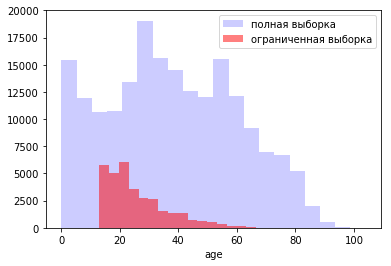

In [75]:
plt.clf()
plt.xlabel('age')
hist_full = plt.hist(list(full['age']), alpha = 0.2, color ='blue', bins = 20)
hist = plt.hist(list(sample['age']), alpha = 0.5, color ='red', bins = 20)
plt.legend(['полная выборка', 'ограниченная выборка'])
plt.show()

In [76]:
len(sample)

32676

In [77]:
from collections import Counter
from collections import OrderedDict

In [78]:
sample_ages = dict(zip(Counter(list(sample['age'])).keys(), Counter(list(sample['age'])).values()))
full_ages = dict(zip(Counter(list(full['age'])).keys(), Counter(list(full['age'])).values()))

In [79]:
percents = dict()
for key in sample_ages.keys():
    percent = sample_ages[key]/full_ages[key]
    percents[key] = percent

In [80]:
percents = OrderedDict(sorted(percents.items()))

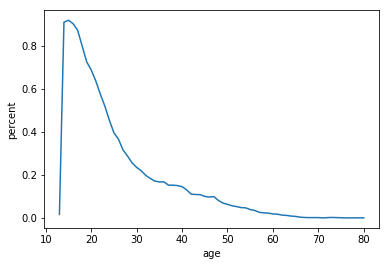

In [81]:
plt.ylabel('percent')
plt.xlabel('age')
plt.plot(list(percents.keys()), list(percents.values()))

In [82]:
checkpoit = id

In [83]:
len(full)

194361

# Parents smoking

In [84]:
n = 0
for dataset in id:
    dataset['parents']= pandas.DataFrame(all_parents[n])
    n = n + 1

In [85]:
n = 0
all_parents_smoking = []
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    parents_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        parent = all_parents[n][child]
        smoking_family = []
        for member in parent:
            mom_dad = household[household[nametag1] == int(member)]
            if list(mom_dad [nametag2]) == []:
                smoking_family.append('nan')
            else:
                if list(mom_dad [nametag2])[0] == 'Äà':
                    smoking_family.append(1)
                else:
                    smoking_family.append(0)
        if 1 in smoking_family:
            parents_smoking.append(1)
        elif 0 in smoking_family:
            parents_smoking.append(0)
        else:
            parents_smoking.append('nan')
    all_parents_smoking.append(parents_smoking)
    n = n + 1

W
V
U
t
s
r
q
p
o
n


# Relatives Smoking

In [86]:
n = 0
all_relatives_smoking = []
for dataset in id:
    relative_smoking = []
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    for child in dataset[dataset['full_info'] == 1].index:
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        relatives = household[household[nametag1] != household[nametag1][child]]
        smoking_family = []
        for member in list(relatives[nametag2]):
            if member == 'Äà':
                smoking_family.append(1)
            elif member == 'nan':
                smoking_family.append('nan')
            else:
                smoking_family.append(0)
        if 1 in smoking_family:
            relative_smoking.append(1)
        elif 0 in smoking_family:
            relative_smoking.append(0)
        else:
            relative_smoking.append('nan')
    all_relatives_smoking.append(relative_smoking)
    n = n + 1

W
V
U
t
s
r
q
p
o
n


# Full Family limiting

In [87]:
n = 0
all_full_family = []
for dataset in id:
    letter = dataset.columns[0][0]
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    full_family = []
    for child in dataset[dataset['full_info'] == 1].index:
        print(child)
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        parent = all_parents[n][child]
        mother = []
        father = []
        for member in parent:
            mom_dad = household[household[nametag1] == int(member)]
            if list(mom_dad[nametag3])[0] == 'ÆÅÍÑÊÈÉ':
                mother = 1
            else:
                father = 1 
        if len(parent) == 2 and mother == 1 and father == 1:
            full_family.append(1)
            print(letter)
        else:
            full_family.append(0)
    all_full_family.append(full_family)
    n = n + 1

5
17
20
W
26
W
27
W
30
32
36
41
W
54
64
W
74
W
79
W
89
104
106
110
W
111
W
112
W
120
133
139
141
W
150
152
163
183
207
W
244
W
249
267
W
271
W
275
W
282
300
W
307
310
314
W
326
335
339
W
342
345
W
366
384
W
385
390
395
396
400
W
402
405
W
414
419
W
421
W
425
430
440
478
495
W
502
507
W
531
537
544
W
548
W
553
554
564
616
626
W
651
659
W
666
W
670
678
W
682
W
696
701
706
W
707
W
722
W
723
W
732
W
736
W
756
W
759
W
764
772
W
780
784
796
798
802
W
819
832
W
836
840
861
869
873
884
902
904
913
922
W
955
W
969
W
974
978
W
982
W
984
W
989
W
993
998
W
1004
1005
W
1010
W
1013
1014
1021
W
1026
1035
1041
W
1050
1051
1054
W
1057
1064
W
1068
W
1082
W
1091
W
1099
1105
W
1111
W
1115
W
1119
W
1127
1133
W
1135
1141
1157
W
1164
W
1173
1177
W
1183
1185
1191
W
1196
W
1203
W
1204
W
1209
W
1212
W
1219
1238
W
1243
1244
1257
W
1264
1266
1271
W
1280
W
1286
1298
W
1304
W
1314
1316
W
1319
1320
1323
1346
1347
1351
W
1357
W
1377
1378
1392
W
1407
W
1421
W
1422
1424
1425
1428
1432
1436
1440
1441
W
1442
W
1452
W
145

W
8909
8911
8918
W
8929
W
8932
W
8933
W
8944
8948
8951
W
8952
W
8960
8977
8983
W
8985
8986
8987
8990
8992
8993
8995
8996
8997
8998
9002
9007
W
9010
W
9020
9026
9027
9029
W
9031
W
9045
W
9054
W
9058
W
9066
9068
9076
W
9082
9083
9089
9090
9091
9097
9102
9107
9108
9112
9114
9117
W
9123
W
9124
9125
9129
9137
W
9146
W
9147
W
9150
W
9153
W
9159
W
9169
W
9171
9177
W
9178
W
9183
9188
9191
9192
9195
W
9196
W
9208
9214
W
9215
W
9219
W
9220
W
9229
9232
W
9259
9262
9275
9278
9284
9285
9291
W
9293
9297
W
9298
W
9302
9306
W
9310
9317
W
9318
W
9324
9327
9328
9329
9333
W
9335
W
9339
9343
9344
9348
9351
W
9357
W
9367
W
9378
W
9390
W
9392
9401
9407
9412
9417
9420
9423
9429
9435
W
9441
W
9445
W
9446
W
9449
W
9456
W
9458
W
9459
W
9462
W
9465
W
9468
W
9469
W
9472
W
9476
9480
W
9481
W
9482
W
9483
W
9484
W
9487
9488
W
9489
W
9491
W
9492
W
9496
9497
9499
9500
W
9501
W
9506
9511
W
9512
W
9513
W
9514
W
9516
9517
W
9521
W
9522
W
9523
W
9524
W
9529
W
9530
W
9531
W
9536
W
9537
9539
W
9540
9541
9545
9547
W
9548
W
9

W
16185
16191
16203
W
16204
W
16207
16214
W
16216
16218
W
16219
W
16240
16263
W
16264
16273
16275
16276
16285
16290
16296
16297
16300
W
16304
16306
W
16313
W
16316
W
16318
16326
16327
16331
W
16333
16339
16356
W
16421
16440
W
16441
W
16452
16466
W
16474
16477
W
16487
16495
W
16496
16497
16500
W
16502
16509
W
16514
W
16515
W
16516
16519
16520
16525
16527
W
16535
16537
16541
16543
W
16551
W
16559
W
16564
16571
16572
16576
W
16583
W
16591
16592
16593
16595
16597
16603
16604
W
16625
16628
16631
16643
16645
16660
W
16661
W
16665
16678
W
16684
16687
16695
W
16696
W
16722
W
16723
W
16730
16742
W
16766
16767
16769
16772
W
16773
W
16779
16780
16782
16792
W
16818
16820
16822
16826
16827
16828
16834
W
16842
W
16845
W
16846
W
16848
W
16851
W
16869
W
16874
16880
16889
16890
16891
16893
16900
W
16922
16956
W
16989
16990
16996
16998
W
17003
17006
17014
17018
17025
17027
17033
17035
17036
17043
17049
17053
17055
17057
17059
W
17069
17070
17080
17081
W
17087
17095
W
17107
17110
17111
17115
W
17123
W
17

V
6360
V
6363
6366
6367
V
6376
6379
6384
6402
V
6414
6418
6420
6421
6422
6425
6434
6438
V
6452
6456
6457
V
6471
V
6474
V
6476
6483
V
6496
V
6497
V
6525
V
6529
V
6533
6539
V
6546
6553
V
6554
V
6559
V
6560
V
6562
V
6565
6571
V
6573
V
6578
6585
V
6590
6597
6599
6610
V
6612
6615
V
6630
V
6632
6641
V
6644
6646
6647
6652
6654
6656
V
6657
V
6658
V
6662
V
6663
V
6668
V
6706
6716
6717
6722
6729
6732
6736
6739
6750
V
6751
6771
6779
6783
6788
6795
6805
6814
6816
6822
6825
V
6835
6838
V
6845
6849
6867
V
6871
6882
6891
V
6893
V
6896
6897
6901
6906
V
6914
6921
6928
6934
6937
V
6944
V
6946
6958
V
6963
V
6972
6978
V
7006
V
7007
V
7009
V
7029
7037
V
7040
V
7045
7046
7051
V
7054
7055
7058
7062
7079
7080
7082
V
7098
V
7106
7117
7123
7147
7157
V
7162
V
7165
7170
7195
7208
V
7211
V
7232
7241
V
7242
V
7243
V
7268
7275
V
7293
V
7303
V
7306
V
7311
V
7316
7320
7336
7343
7347
7350
7359
7369
7378
7385
7388
7391
V
7397
7407
V
7411
7418
V
7441
7442
7451
V
7452
7466
7473
V
7488
7489
7510
7536
7537
V
7548
V
7571
V
7

V
13570
13574
13582
V
13605
V
13610
13614
13632
13635
13637
V
13646
13651
V
13656
V
13657
V
13659
13663
13666
V
13667
V
13675
V
13682
13685
V
13693
V
13697
13698
13703
13705
13724
13733
V
13741
13758
13772
13776
V
13784
13785
13803
V
13805
V
13813
V
13821
V
13824
13838
13841
13850
V
13873
13882
V
13894
13896
V
13917
V
13918
V
13922
V
13925
13930
13934
13940
13942
V
13945
V
13949
13961
13962
13964
V
13974
V
13982
V
13984
V
13992
V
14003
V
14009
V
14013
14014
14020
14025
14036
14037
14038
14044
14052
V
14059
14063
14066
V
14069
14072
14075
V
14094
V
14101
V
14109
14110
V
14111
14113
14129
14144
V
14151
14155
V
14156
V
14174
V
14182
V
14184
14186
V
14189
14193
14206
V
14213
14215
14217
V
14218
14222
14231
14245
14256
14261
V
14262
V
14271
V
14275
14280
14285
V
14292
14294
14308
14313
V
14314
14340
14341
14347
V
14350
14366
14376
14386
V
14389
14409
V
14460
14462
14494
14508
V
14516
V
14520
14529
V
14532
14553
14557
V
14567
14592
14676
V
14677
V
14680
V
14681
V
14694
V
14696
V
14700
14702


U
3385
U
3387
U
3388
3391
3395
3399
3403
3411
U
3413
U
3415
3432
3435
3461
U
3467
U
3469
U
3474
3477
3478
3482
U
3483
U
3487
U
3490
U
3491
U
3501
3502
3506
U
3514
3517
3522
U
3531
U
3536
U
3545
3553
U
3567
U
3568
U
3574
3575
3577
3582
3584
3590
3591
3593
U
3595
U
3597
U
3604
3607
U
3608
U
3611
3612
3626
3636
U
3638
U
3639
U
3649
U
3651
U
3652
U
3658
3660
U
3661
U
3664
3688
3701
3706
3711
U
3713
U
3721
3726
U
3732
3733
3740
3765
U
3768
3769
3770
3771
3773
3780
U
3821
3832
3843
U
3859
U
3860
U
3861
U
3864
U
3867
U
3874
U
3885
U
3893
3896
3905
3906
U
3917
U
3919
U
3923
3928
U
3931
3934
3935
U
3938
3939
U
3941
3943
3946
3958
U
3967
U
3969
3975
3982
U
3986
4000
U
4003
4007
4014
U
4027
U
4033
U
4046
4051
U
4063
4066
4070
U
4071
U
4074
4077
4090
U
4093
4096
4102
U
4108
U
4116
U
4117
U
4129
U
4140
U
4146
4157
U
4174
U
4177
U
4185
U
4196
U
4209
U
4214
U
4237
U
4254
4264
U
4267
U
4269
U
4279
4281
4300
U
4303
U
4306
4307
U
4311
4314
U
4320
U
4332
4336
4340
4344
U
4350
U
4358
4364
4370
4386
4388
4

10957
10960
10961
U
10966
U
10968
10972
10980
10982
10990
U
10997
11047
U
11059
U
11082
11083
11084
U
11087
U
11092
11093
U
11094
U
11103
11113
U
11114
U
11122
11133
U
11135
11151
11154
11157
U
11164
U
11166
U
11189
11197
U
11198
U
11199
11204
11205
11208
U
11220
11221
11222
U
11223
11227
11228
11229
11234
U
11239
11240
11245
11265
U
11278
11282
U
11285
U
11287
11295
U
11303
11329
U
11358
11360
11368
11375
U
11377
11383
U
11386
U
11426
11427
11453
U
11458
U
11461
11462
11476
11480
11485
U
11487
U
11490
11495
11497
11501
11504
11509
11513
11518
11530
11538
11545
11554
U
11561
U
11575
11601
11606
U
11617
11620
11625
11634
U
11650
11666
11686
11690
11701
11707
11715
11727
U
11747
11752
11759
11760
11806
11811
U
11812
U
11821
11822
U
11825
U
11831
U
11840
U
11858
11864
U
11901
11914
U
11915
U
11918
11925
U
11928
11945
11959
11962
U
11963
U
11967
11971
U
11972
U
11975
11986
U
11987
U
11990
U
11994
11995
12001
12005
U
12018
12035
12050
U
12053
12077
U
12078
12083
12091
U
12093
12098
12100
12

U
18743
U
18746
U
18751
18755
4
t
5
11
13
20
23
t
33
34
47
t
58
t
61
t
62
63
70
79
83
t
85
t
93
100
t
114
t
133
148
t
149
t
159
163
t
174
175
178
t
183
192
t
209
t
215
227
t
230
239
249
t
250
t
256
t
262
264
270
t
276
283
t
284
t
289
t
290
294
t
300
301
312
324
343
350
366
t
368
t
374
383
t
392
t
402
t
417
t
430
t
433
t
445
t
453
t
457
t
467
476
481
489
498
t
505
519
t
530
545
t
550
t
553
t
554
t
558
t
563
t
566
569
577
t
579
580
t
582
586
589
602
603
606
612
631
t
639
t
647
648
650
655
t
662
t
674
t
677
t
685
686
689
710
t
721
t
722
726
t
731
736
t
739
t
753
t
773
t
776
t
783
784
t
789
811
819
t
821
823
t
826
844
845
851
t
852
t
853
861
t
864
t
868
t
870
t
880
t
885
t
890
t
893
896
t
897
t
900
902
t
908
t
909
t
911
t
912
t
914
t
915
916
t
923
927
929
t
934
941
951
t
956
962
t
965
t
968
987
t
990
1001
t
1002
t
1007
t
1010
t
1011
t
1014
1020
1023
t
1030
t
1033
t
1037
1038
1041
t
1051
t
1055
t
1060
t
1061
t
1078
t
1085
1088
t
1093
t
1095
1110
1112
t
1161
1163
t
1166
t
1178
t
1181
t
1186


8030
8043
t
8049
t
8071
8119
t
8124
8125
8132
8141
8180
8193
t
8196
8219
t
8221
t
8222
t
8233
8235
8246
8255
t
8258
8271
8273
8277
t
8278
8286
t
8298
t
8304
8305
8319
8358
8359
t
8366
t
8369
t
8383
t
8384
t
8387
8392
8401
8402
8403
8408
8409
8410
8414
t
8418
t
8423
8427
8430
t
8432
t
8433
t
8439
t
8441
t
8443
t
8445
t
8452
8453
8459
8460
8462
t
8467
t
8471
t
8473
t
8479
8482
8483
8490
8498
t
8500
t
8508
t
8512
t
8516
t
8519
8521
8525
8529
8532
8533
8534
8539
8541
8542
8555
t
8562
t
8565
t
8567
t
8568
t
8573
t
8578
8584
t
8585
t
8589
t
8594
t
8597
8600
8606
t
8613
8614
8623
t
8624
t
8628
t
8635
8639
t
8642
t
8644
8645
8650
8651
8659
8662
8666
t
8672
t
8678
8681
t
8688
8693
8697
8700
t
8705
t
8714
8719
8723
8731
8732
8747
t
8751
8755
t
8758
8760
8767
8775
t
8777
t
8783
t
8786
t
8788
8792
8797
t
8810
t
8811
t
8812
8820
t
8824
8825
t
8841
t
8847
8852
t
8857
t
8859
8862
8865
8871
t
8873
8875
8880
t
8881
t
8886
8888
8901
t
8902
t
8906
8915
8922
8941
t
8944
t
8949
t
8955
t
8963
8974
8979
t
89

t
15625
t
15628
t
15635
t
15637
t
15639
15657
15662
t
15663
t
15668
t
15676
15679
t
15684
15696
t
15698
t
15702
t
15710
15714
t
15715
15730
15731
15733
15743
15745
15753
15758
t
15761
15768
t
15781
15782
15796
15797
t
15801
15805
15806
15813
15814
15831
15832
15834
15837
15840
t
15859
15877
15882
15886
15893
t
15907
t
15911
t
15930
t
15932
15933
15935
15964
15965
15976
t
15977
t
15982
15989
t
15990
16009
16013
16022
16023
16028
t
16040
16047
16049
16051
16061
t
16066
16075
16078
16081
16087
t
16116
t
16130
16132
16153
16154
16160
t
16171
16175
16176
16189
t
16194
t
16195
t
16201
16213
t
16214
t
16218
t
16219
t
16223
16226
t
16248
16252
16253
t
16258
16259
t
16260
t
16264
16268
t
16273
t
16285
16288
16300
t
16302
t
16312
t
16315
16317
t
16320
t
16323
t
16325
t
16329
16342
16343
16349
16356
16358
16361
16362
16364
16392
16394
t
16405
16407
16408
16421
16426
16434
t
16436
16438
16462
16472
t
16483
t
16490
t
16493
t
16494
t
16503
t
16511
16512
16519
t
16520
t
16527
16530
16534
16543
16544


5311
5319
s
5320
s
5336
5343
5345
5347
5357
5376
s
5408
5411
5438
s
5450
5455
s
5463
5478
s
5484
5489
5492
5504
5505
5512
5522
5524
5530
s
5538
5560
5562
5566
s
5572
5604
s
5621
5624
s
5642
5644
s
5659
s
5661
5663
5675
s
5684
5686
s
5687
s
5699
s
5705
s
5722
5728
5732
5759
5762
s
5768
s
5780
5781
5798
5799
5807
5820
s
5825
5835
5874
5875
5895
s
5902
5905
s
5910
s
5926
s
5929
s
5931
5934
s
5937
s
5940
5970
s
5984
s
5993
6016
6020
6021
s
6029
6031
6034
6039
6040
6044
6049
6052
s
6056
s
6057
6074
6078
6080
6082
6089
s
6094
s
6112
6115
6117
s
6119
s
6125
s
6126
s
6131
6132
6163
6188
s
6238
6239
6248
s
6253
s
6257
6258
6261
6285
s
6333
6336
s
6342
6344
s
6353
s
6357
6363
s
6365
s
6381
s
6385
6386
6392
s
6393
6400
6404
s
6415
s
6423
s
6426
s
6427
s
6429
6431
s
6435
s
6436
s
6442
s
6449
6468
s
6473
s
6478
s
6491
6492
6502
s
6504
s
6507
6521
s
6523
s
6526
6541
s
6547
6551
s
6560
6561
6562
s
6564
s
6569
s
6594
6598
6602
6604
6610
s
6623
s
6624
6629
s
6641
s
6656
6675
s
6701
s
6720
s
6723
s
6727

13026
s
13033
13040
13047
s
13051
s
13060
13066
13074
13087
13090
13092
13098
13101
13110
13111
13112
13113
s
13121
s
13126
s
13133
s
13134
s
13135
s
13137
s
13144
13149
13151
s
13161
13182
13183
13184
13196
s
13206
s
13212
13222
13229
s
13234
s
13238
13245
13249
13259
13296
13312
13316
s
13324
s
13327
s
13334
13340
s
13355
13365
13367
13376
13382
13383
s
13387
13394
13395
13399
13401
13403
s
13406
13422
s
13425
13428
s
13433
s
13441
13445
13457
s
13464
s
13475
s
13477
13481
13490
13492
13495
s
13496
s
13501
s
13502
s
13514
13515
13528
13529
13542
13549
13553
13556
13560
13562
s
13570
13571
13575
13581
s
13594
13599
s
13608
13611
13614
13621
13624
13625
13629
s
13630
s
13634
s
13636
s
13641
13658
13666
13669
s
13676
13685
13687
s
13690
13700
13708
13711
13715
13717
13724
13729
s
13730
s
13733
s
13734
s
13738
13742
13745
s
13749
13754
s
13760
s
13762
s
13765
13769
s
13770
13772
13777
13780
13783
13786
13792
13801
13811
s
13812
13815
s
13818
s
13839
13846
13853
s
13855
13856
13860
13869


2410
r
2430
r
2449
r
2462
r
2469
2477
2481
r
2497
r
2505
2512
r
2513
r
2515
2522
r
2525
2530
r
2537
r
2553
r
2554
r
2561
r
2570
2574
r
2586
2596
2604
2606
2608
2610
r
2611
r
2614
r
2618
r
2621
r
2624
r
2625
r
2637
2646
r
2648
2678
2682
2690
2711
2728
2729
2760
2761
2762
2763
2774
2776
2786
2792
2795
2801
r
2811
2815
r
2816
r
2819
2822
2828
r
2829
r
2861
2863
r
2864
2874
r
2879
r
2898
2906
2919
2920
2926
2927
2933
2938
r
2941
r
2949
2952
r
2959
2966
r
2972
2979
2982
r
2988
r
2998
r
2999
r
3006
r
3010
3016
3018
r
3019
r
3027
3038
3044
3047
r
3049
r
3052
r
3053
r
3061
r
3067
3068
3079
3087
3092
3105
r
3115
r
3120
3124
3141
3152
3154
3166
3168
r
3171
r
3182
r
3192
3201
3203
3215
r
3223
3224
3226
3231
3244
3250
r
3257
r
3267
r
3271
3277
r
3279
r
3285
r
3290
3301
3307
3310
r
3326
r
3327
r
3330
r
3339
r
3342
r
3349
r
3350
r
3351
r
3355
r
3360
r
3363
r
3369
3374


KeyboardInterrupt: 

# Father/mother smoking

In [ ]:
hetero = []
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    het_family = []
    for child in dataset[dataset['full_info'] == 1].index:
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        parent = all_parents[n][child]
        mother = 0
        father = 0
        for member in parent:
            mom_dad = household[household[nametag1] == int(member)]
            if list(mom_dad[nametag3])[0] == 'ÆÅÍÑÊÈÉ':
                mother = mother + 1
            else:
                father = father + 1
        if mother > 1 or father > 1:
            het_family.append(0)
        else:
            het_family.append(1)
    hetero.append(het_family)
    n = n + 1

## Full info mother/father

In [ ]:
n = 0
full_info_father = []
full_info_mother = []
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    k = 0
    mother = []
    father = []
    for child in list(dataset[dataset['full_info'] == 1].index):
        mother_smoking = []
        father_smoking = []
        if hetero[n][k] == 1:
            parent = all_parents[n][child]
            for member in parent:
                household = dataset[dataset['household_list'] == dataset['household_list'][child]]
                mom_dad = household[household[nametag1] == int(member)]
                if list(mom_dad[nametag3])[0] == 'ÆÅÍÑÊÈÉ':
                    mother_smoking.append(1)
                else:
                    father_smoking.append(1)
            if 1 in mother_smoking:
                mother.append(1)
            else:
                mother.append(0)
            if 1 in father_smoking:
                father.append(1)
            else:
                father.append(0)
        else:
            father.append(0)
            mother.append(0)
        k = k + 1
    full_info_father.append(father)
    full_info_mother.append(mother)
    n = n + 1

In [ ]:
all_father_smoking = []
all_mother_smoking = []
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    k = 0
    mother_smoking = []
    father_smoking = []
    for child in list(dataset[dataset['full_info'] == 1].index):
        if full_info_mother[n][k] == 1 or full_info_father[n][k] == 1:
            mother = 0
            father = 0
            here = []
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            parent = all_parents[n][child]
            for member in parent:
                    mom_dad = household[household[nametag1] == int(member)]
                    if list(mom_dad[nametag3]) != []:
                        if list(mom_dad[nametag3])[0] == 'ÆÅÍÑÊÈÉ':
                            mother = 1
                            if list(mom_dad[nametag2]) == []:
                                mother_smoking.append('nan')
                            else:
                                if list(mom_dad [nametag2])[0] == 'Äà':
                                    mother_smoking.append(1)
                                else:
                                    mother_smoking.append(0)
                        else:
                            father = 1
                            if list(mom_dad[nametag2]) == []:
                                father_smoking.append('nan')
                            else:
                                if list(mom_dad [nametag2])[0] == 'Äà':
                                    father_smoking.append(1)
                                else:
                                    father_smoking.append(0)
                    else:
                        mother_smoking.append('nan')
                        father_smoking.append('nan')
            if mother == 0:
                mother_smoking.append('nan')
            if father == 0:
                father_smoking.append('nan')
            if len(mother_smoking)!= len(father_smoking):
                print('problem', child , n, k)
        else:
            mother_smoking.append('nan')
            father_smoking.append('nan')
        k = k + 1
    all_father_smoking.append(father_smoking)
    all_mother_smoking.append(mother_smoking)
    n = n + 1

# Who has a sibling

In [ ]:
def sibling_func(df):
    generic = []
    for column in all_relatives[n]:
        if 'Ðîäíîé áðàò/ðîäíàÿ ñåñòðà' == df[column]:
            if column[3] == '_':
                ad_surv = column[:3]+ '_1'
            else:
                ad_surv = column[:4]+ '_1'
            if df[ad_surv] == 'Åñòü èíäèâèäóàëüíûé âîïðîñíèê':
                generic.append(1)
            else:
                generic.append(0)
        else:
            generic.append(0)
    if 1 in generic:
        return 1
    else:
        return 0

In [ ]:
siblings = []
n = 0
for dataset in id:
    sibling = dataset.apply(sibling_func, axis = 1)
    siblings.append(sibling)
    n = n + 1

In [ ]:
n = 0
for dataset in id:
    dataset['sibling'] = pandas.DataFrame(siblings[n])
    n = n + 1

## Who are the siblings

In [ ]:
all_sibling_networks = []
k = 0
for dataset in id:
    network = []
    for n in range(len(dataset)):
        new_list = []
        if siblings[k][n] == 1:
            for variable in all_relatives[k]:
                if dataset[variable][n] == 'Ðîäíîé áðàò/ðîäíàÿ ñåñòðà':
                    new_list.append(variable)
                else:
                    pass
        else:
            pass
        network.append(new_list)
    all_sibling_networks.append(network)
    k = k + 1

In [ ]:
all_siblings_numbered_networks = []
for network in all_sibling_networks:
    numbered_sibling_network = []
    for family in network:
        household = []
        for member in family:
            if member[3] == '_':
                if member[-2] == '_':
                    numbered = [member[2],member[-1]]
                else:
                    numbered = [member[2],member[-2] + member[-1]]
            else:
                if member[-2] == '_':
                    numbered = [member[2] + member[3],member[-1]]
                else:
                    numbered = [member[2] + member[3],member[-2] + member[-1]]
            household.append(numbered)
        numbered_sibling_network.append(household)
    all_siblings_numbered_networks.append(numbered_sibling_network)

## Full info siblings

In [ ]:
def full_info_siblings_func(df):
    if df.child_smoking_status == 1 & df.sibling == 1:
        generic = []
        letter = df.keys()[0][0]
        nametag = letter.lower() + 'h4'
        columns = []
        for column in all_relatives[n]:
            if column[3] == '_':
                if int(column[2]) == df[nametag]:
                    columns.append(column)
                else:
                    if column[-2] == '_':
                        if int(column[-1]) == df[nametag]:
                            columns.append(column)
                        else:
                            pass
                    else:
                        if int(column[-2:]) == df[nametag]:
                            columns.append(column)
                        else:
                            pass
            else:
                if int(column[2] + column[3]) == df[nametag]:
                    columns.append(column)
                else:
                    if column[-2] == '_':
                        if int(column[-1]) == df[nametag]:
                            columns.append(column)
                        else:
                            pass
                    else:
                        if int(column[-2:]) == df[nametag]:
                            columns.append(column)
                        else:
                            pass
        for column in columns:
            if 'Ðîäíîé áðàò/ðîäíàÿ ñåñòðà' == df[column]:
                if column[3] == '_':
                    if int(column[2]) == df[nametag]:
                        ad_surv = column[:2] + column[2]+ '_1'
                    else:
                        if column[-2] == '_':
                            if int(column[-1]) == df[nametag]:
                                ad_surv = column[:2] + column[-1]+ '_1'
                        else:
                            if int(column[-2:]) == df[nametag]:
                                ad_surv = column[:2] + column[-2:]+ '_1'
                else:
                    if int(column[2]+column[3]) == df[nametag]:
                        ad_surv = column[:2] + column[2]+ '_1'
                    else:
                        if column[-2] == '_':
                            if int(column[-1]) == df[nametag]:
                                ad_surv = column[:2] + column[-1]+ '_1'
                        else:
                            if int(column[-2:]) == df[nametag]:
                                ad_surv = column[:2] + column[-2:]+ '_1'
                if df[ad_surv] == 'Åñòü èíäèâèäóàëüíûé âîïðîñíèê':
                    generic.append(1)
                else:
                    generic.append(0)
            else:
                generic.append(0)
        if 1 in generic:
            return 1
        else:
            return 0
    else:
        return 0

In [ ]:
n = 0
for dataset in id:
    full_info = dataset.apply(full_info_siblings_func, axis = 1)
    dataset['full_info_sibling'] = pandas.DataFrame(full_info)
    n = n + 1

In [ ]:
def siblings_func(df):
    letter = df.keys()[0][0]
    nametag = letter.lower() + 'h4'
    if df.sibling == 1:
        household = all_siblings_numbered_networks[n][int(df.name)]
        connect = []
        for connection in household:
            if int(connection[0]) == df[nametag]:
                connect.append(connection[-1])
        return connect
    else:
        return []

In [ ]:
all_siblings = []
n = 0
for dataset in id:
    sibling = dataset.apply(siblings_func, axis = 1)
    all_siblings.append(sibling)
    n = n + 1

## Smoking siblings

In [ ]:
n = 0
all_siblings_smoking = []
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    siblings_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        if dataset['full_info_sibling'][child] == 1:
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            sibling = all_siblings[n][child]
            smoking_family = []
            for member in sibling:
                bro_sis = household[household[nametag1] == int(member)]
                if list(bro_sis[nametag2]) == []:
                    smoking_family.append('nan')
                else:
                    if list(bro_sis [nametag2])[0] == 'Äà':
                        smoking_family.append(1)
                    else:
                        smoking_family.append(0)
            if 1 in smoking_family:
                siblings_smoking.append(1)
            elif 0 in smoking_family:
                siblings_smoking.append(0)
            else:
                siblings_smoking.append('nan')
        else:
            siblings_smoking.append('nan')
    all_siblings_smoking.append(siblings_smoking)
    n = n + 1

## Brother

In [ ]:
full_info_brother = []
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    siblings_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        if dataset['full_info_sibling'][child] == 1:
            print(child)
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            sibling = all_siblings[n][child]
            smoking_family = []
            for member in sibling:
                bro_sis = household[household[nametag1] == int(member)]
                if int(member) in list(household[nametag1]):
                    if list(bro_sis[nametag3])[0] != 'ÆÅÍÑÊÈÉ':
                        smoking_family.append(1)
                    else:
                        smoking_family.append(0)
                else:
                    smoking_family.append(0)
            if 1 in smoking_family:
                print(child, 'yes')
                siblings_smoking.append(1)
            else:
                siblings_smoking.append(0)
        else:
            siblings_smoking.append(0)
    full_info_brother.append(siblings_smoking)
    n = n + 1

In [ ]:
brother_smoking = []
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    siblings_smoking = []
    k = 0
    for child in dataset[dataset['full_info'] == 1].index:
        if full_info_brother[n][k] == 1:
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            sibling = all_siblings[n][child]
            smoking_family = []
            for member in sibling:
                bro_sis = household[household[nametag1] == int(member)]
                if int(member) in list(household[nametag1]):
                    if list(bro_sis[nametag3])[0] != 'ÆÅÍÑÊÈÉ':
                        if list(bro_sis[nametag2])[0] == 'Äà':
                            smoking_family.append(1)
                        else:
                            smoking_family.append(0)
                    else:
                        pass
                else:
                    smoking_family.append(0)
            if 1 in smoking_family:
                siblings_smoking.append(1)
            else:
                siblings_smoking.append(0)
        else:
            siblings_smoking.append(0)
        k = k + 1
    brother_smoking.append(siblings_smoking)
    n = n + 1

## Sister

In [ ]:
full_info_sister = []
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    siblings_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        if dataset['full_info_sibling'][child] == 1:
            print(child)
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            sibling = all_siblings[n][child]
            smoking_family = []
            for member in sibling:
                bro_sis = household[household[nametag1] == int(member)]
                if int(member) in list(household[nametag1]):
                    if list(bro_sis[nametag3])[0] == 'ÆÅÍÑÊÈÉ':
                        smoking_family.append(1)
                    else:
                        smoking_family.append(0)
                else:
                    smoking_family.append(0)
            if 1 in smoking_family:
                print(child, 'yes')
                siblings_smoking.append(1)
            else:
                siblings_smoking.append(0)
        else:
            siblings_smoking.append(0)
    full_info_sister.append(siblings_smoking)
    n = n + 1

In [ ]:
sister_smoking = []
n = 0
for dataset in id:
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    nametag3= letter.lower() + 'h5'
    siblings_smoking = []
    k = 0
    for child in dataset[dataset['full_info'] == 1].index:
        if full_info_sister[n][k] == 1:
            household = dataset[dataset['household_list'] == dataset['household_list'][child]]
            sibling = all_siblings[n][child]
            smoking_family = []
            for member in sibling:
                bro_sis = household[household[nametag1] == int(member)]
                if int(member) in list(household[nametag1]):
                    if list(bro_sis[nametag3])[0] != 'ÆÅÍÑÊÈÉ':
                        if list(bro_sis[nametag2])[0] == 'Äà':
                            smoking_family.append(1)
                        else:
                            smoking_family.append(0)
                    else:
                        pass
                else:
                    smoking_family.append(0)
            if 1 in smoking_family:
                siblings_smoking.append(1)
            else:
                siblings_smoking.append(0)
        else:
            siblings_smoking.append(0)
        k = k + 1
    sister_smoking.append(siblings_smoking)
    n = n + 1

# Family Wealth

## Overall wealth

In [1389]:
n = 0
overall_wealth = []
for dataset in id:
    wealth = []
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    wealth = letter.lower() + 'j10'
    relative_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        relatives = household[household[nametag1] != household[nametag1][child]]
        smoking_family = []
        k = 0
        for member in list(relatives[nametag2]):
            if str(list(relatives[wealth])[k]) == list(relatives[wealth])[k]:
                pass
            else:
                smoking_family.append(list(relatives[wealth])[k])
            k = k + 1
        if smoking_family == []:
            relative_smoking.append(0)
        else:
            relative_smoking.append(sum(smoking_family))
    overall_wealth.append(relative_smoking)
    n = n + 1

W
V
U
t
s
r
q
p
o
n


# Family Health

In [1430]:
n = 0
overall_health = []
for dataset in id:
    wealth = []
    letter = dataset.columns[0][0]
    print(letter)
    nametag1= letter.lower() + 'h4'
    nametag2= letter.lower() + 'm71'
    wealth = letter.lower() + 'm3'
    relative_smoking = []
    for child in dataset[dataset['full_info'] == 1].index:
        household = dataset[dataset['household_list'] == dataset['household_list'][child]]
        relatives = household[household[nametag1] != household[nametag1][child]]
        smoking_family = []
        k = 0
        for member in list(relatives[nametag2]):
            if str(list(relatives[wealth])[k]) == 'Ñðåäíåå, íå õîðîøåå, íî è íå ïëîõîå':
                smoking_family.append(3)
            elif str(list(relatives[wealth])[k]) =='Ïëîõîå':
                smoking_family.append(4)
            elif str(list(relatives[wealth])[k]) == 'Õîðîøåå':
                smoking_family.append(2)
            elif str(list(relatives[wealth])[k]) == 'Î÷åíü õîðîøåå':
                smoking_family.append(1)
            elif str(list(relatives[wealth])[k]) == 'Ñîâñåì ïëîõîå':
                smoking_family.append(5)
            else:
                smoking_family.append(0)
            k = k + 1
        if smoking_family == []:
            relative_smoking.append(0)
        else:
            relative_smoking.append(sum(smoking_family)/len(smoking_family))
    overall_health.append(relative_smoking)
    n = n + 1

W
V
U
t
s
r
q
p
o
n


# Data Formating

In [1396]:
checkpoint2 = sample

In [1543]:
full_info = []
for dataset in id:
    full_info.append(dataset[dataset['full_info']==1])

In [1544]:
reindexed = []
for dataset in full_info:
    dataset['numbers'] = range(len(dataset))
    new = dataset.set_index('numbers')
    reindexed.append(new)

/Users/artempchelintsev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1546]:
years = []
n = 0
for dataset in reindexed:
    column = [2018 - n]*len(dataset)
    new = dataset
    new['year'] = column
    years.append(new)
    n = n + 1

In [1547]:
wealth = []
n = 0
for dataset in years:
    new = dataset
    new['wealth'] = overall_wealth[n]
    wealth.append(new)
    n = n + 1

In [1548]:
health = []
n = 0
for dataset in wealth:
    new = dataset
    new['health'] = overall_health[n]
    health.append(new)
    n = n + 1

In [1549]:
dependent = []
for dataset in health:
    new = dataset
    letter = str(dataset.columns[0][0].lower())
    col = letter + 'm71'
    smoke = []
    for name in dataset[col]:
        if name == 'Äà':
            smoke.append(1)
        else:
            smoke.append(0)
    dependent.append(smoke)

In [1551]:
smoke = []
n = 0
for dataset in health:
    new = dataset
    new['smoke'] = dependent[n]
    smoke.append(new)
    n = n + 1

In [1552]:
sex = []
for dataset in smoke:
    new = dataset
    letter = str(dataset.columns[0][0].lower())
    col = letter + 'h5'
    gender = []
    for name in dataset[col]:
        if name == 'ÌÓÆÑÊÎÉ':
            gender.append(1)
        else:
            gender.append(0)
    sex.append(gender)

In [1559]:
gender = []
n = 0
for dataset in smoke:
    new = dataset
    new['gender'] = sex[n]
    gender.append(new)
    n = n + 1

In [1560]:
brother = []
n = 0
for dataset in gender:
    new = dataset
    new['full_info_brother'] = full_info_brother[n]
    brother.append(new)
    n = n + 1

In [1561]:
brother_smoke = []
n = 0
for dataset in brother:
    new = dataset
    new['brother_smoking'] = brother_smoking[n]
    brother_smoke.append(new)
    n = n + 1

In [1562]:
sister = []
n = 0
for dataset in brother_smoke:
    new = dataset
    new['full_info_sister'] = full_info_sister[n]
    sister.append(new)
    n = n + 1

In [1563]:
sister_smoke = []
n = 0
for dataset in sister:
    new = dataset
    new['sister_smoking'] = sister_smoking[n]
    sister_smoke.append(new)
    n = n + 1

In [1564]:
mother = []
n = 0
for dataset in sister_smoke:
    new = dataset
    new['full_info_mother'] = full_info_mother[n]
    mother.append(new)
    n = n + 1

In [1565]:
mother_smoke = []
n = 0
for dataset in mother:
    new = dataset
    new['mother_smoking'] = all_mother_smoking[n]
    mother_smoke.append(new)
    n = n + 1

In [1566]:
father = []
n = 0
for dataset in mother_smoke:
    new = dataset
    new['full_info_father'] = full_info_father[n]
    father.append(new)
    n = n + 1

In [1567]:
father_smoke = []
n = 0
for dataset in father:
    new = dataset
    new['father_smoking'] = all_father_smoking[n]
    father_smoke.append(new)
    n = n + 1

In [1568]:
full_family = []
n = 0
for dataset in father_smoke:
    new = dataset
    new['full_family'] = all_full_family[n]
    full_family.append(new)
    n = n + 1

In [1571]:
parents = []
n = 0
for dataset in full_family:
    new = dataset
    new['parents_smoking'] = all_parents_smoking[n]
    parents.append(new)
    n = n + 1

In [1576]:
relatives = []
n = 0
for dataset in parents:
    new = dataset
    new['relatives_smoking'] = all_relatives_smoking[n]
    relatives.append(new)
    n = n + 1

In [1607]:
formatted = []
n = 0
for dataset in relatives:
    letter = dataset.columns[0][0]
    low_letter = letter.lower()
    names = ['age', 'full_info_sibling', 'full_info_brother', 'full_info_sister', 'full_info_mother', 'full_info_father', 'brother_smoking', 'sister_smoking', 'mother_smoking', 'father_smoking', 'full_family', 'parents_smoking', 'relatives_smoking','gender', 'smoke', 'wealth', 'health','year']
    ind = []
    columns = dataset.columns
    for column in columns:
        if (column[-1] == 'h' or column[-1] == 'i') and 'did' not in column and 'wealth' not in column and 'health' not in column:
            ind.append(column)
    new = dataset[ind + names]
    formatted.append(new)

In [1657]:
final = pandas.concat(formatted, ignore_index=True, sort = False)

In [1658]:
checkpoint3 = final

In [1669]:
final['numbers'] = range(len(final))

In [1670]:
final = final.set_index('numbers')

In [1659]:
final = final[final['age'] >= 14]

In [1660]:
final = final[final['age'] <= 27]

In [1674]:
final.to_csv('/Users/artempchelintsev/PycharmProjects/Diplom/rlms/final.csv')

In [1661]:
indicators = []
for column in final.columns:
    if column[-1] == 'i':
        indicators.append(column)
    else:
        pass

In [1662]:
indicators = sorted(indicators)

In [1663]:
indicators = indicators + ['year']

In [1664]:
final = final.sort_values(indicators)

In [1671]:
ind = []
k = 0
for n in range(len(final)):
    if n == 0:
        ind.append(k)
    else:
        for column in indicators:
            if final[column][n] != 'nan':
                if final[column][n] == final[column][n-1]:
                    ind.append(k)
                    break
                else:
                    k = k + 1
                    ind.append(k)
                    break
            else:
                pass

In [1673]:
final['ind'] = ind